# Oscilloscope Analaysis for Lab 28

#### Header info

In [2]:
#Import needed libraries
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import csv
import datetime
import os,platform
from scipy.optimize import curve_fit
import scipy
from scipy.fft import fft, rfft, irfft,ifft,fftfreq
from scipy.signal import argrelextrema
from scipy.stats import norm
#"check git"
#Read in the runlist and save as dataframe
Runlist_old= pd.read_table("./Runlist.tsv")
Runlist_old["RN"]=pd.to_numeric(Runlist_old["RN"])

#varible for determining the lab pc or other pc, Check if windows or not, then try to grab pc name
pcname=""
if platform.system() == "Windows":
    pcname=platform.uname().node
else:
    try:
        pcname=os.uname()[1]
    except:
        print("Issue with finding pc name")

env_var_wavefromloc ="" #varible for location of waveform data. 
data_dir_mod_old="" #varible for small difference in storage managment between pc 1 and 2
if pcname=='PHYS-PSB02802': #Lab pc 2, (Labview pc)
    env_var_wavefromloc ="A:/DATA/waveforms/"
    env_var_waveformloc_old="C:/Users/KK_Lab28_1/Documents/Waveforms/"
    data_dir_mod_old=""

elif pcname=="PHYS-PSB02801": #Lab pc 1, (solidworks pc)
    env_var_wavefromloc ="data/waveforms/" #This is true for Jason's work atm (June 10th) Needs Updateing to global or user friendly verison
    data_dir_mod_old="/"


def ReadRunlist(filename="C:/Users/jasonbane/Desktop/nexo_code/Run Data (GUI v1)/RunList.csv"):
    return pd.read_csv(filename,index_col=False)



Runlist_DF = ReadRunlist()
Runlist_DF["RN"]=Runlist_DF["Run No."]

number_cols=["Anode V.","Anode Grid V.","Cathode V.","Cathode Grid V.","Drift Length"]


Runlist_DF[number_cols] = Runlist_DF[number_cols].apply(pd.to_numeric)
#Runlist_DF[number_cols] = pd.to_numeric(Runlist_DF[number_cols])

Runlist_DF["Extraction Distance"] = 1.83
Runlist_DF["Collection Distance"] = 1.83
Runlist_DF["Drift Length Error"] = 0.15
Runlist_DF["Extraction Distance Error"] = 1.83*0.01
Runlist_DF["Collection Distance Error"] = 1.83*0.01


Runlist_DF["Drift Field"] = (Runlist_DF["Cathode Grid V."] - Runlist_DF["Anode Grid V."])/(Runlist_DF["Drift Length"]/10.0)
Runlist_DF["Extraction Field"] = (Runlist_DF["Cathode V."] - Runlist_DF["Cathode Grid V."])/(Runlist_DF["Extraction Distance"]/10.0)
Runlist_DF["Collection Field"] = (Runlist_DF["Anode V."] - Runlist_DF["Anode Grid V."])/(Runlist_DF["Collection Distance"]/10.0)







waveform_path="C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/data/waveforms/" # Path for data On left pc


anode_analysis_list=[]
blankBG_DF= pd.DataFrame({"Avg Anode":[0]*50000})

In [3]:
Distance_Database=pd.read_csv("C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/CellDistanceDataBase.csv")
Distance_Database["Date"] = Distance_Database["Date"].astype(str)
Distance_Database["Date"] = pd.to_datetime(Distance_Database["Date"])
Distance_Database

Date  Drift Length  Drift Length Error  Extraction Distance  \
0 2024-10-22      20.90857              0.2445               1.8267   
1 2024-10-01       9.18500              0.1524               1.8300   
2 2024-09-12       9.14000              0.1218               1.8300   
3 2024-08-29       9.79000              0.0940               0.8133   
4 2024-07-30       9.00000              0.1500               0.8133   
5 2024-05-03      20.69000              0.0800               0.0000   

   Extraction Distance Error  Collection Distance  Collection Distance Error  
0                   0.016767               1.8267                   0.016767  
1                   0.016700               1.8300                   0.016700  
2                   0.016700               1.8300                   0.016700  
3                   0.005800               0.8133                   0.005800  
4                   0.005800               0.8133                   0.005800  
5                   0.000000               0.5100                   0.006000

In [4]:
if 1==1:
#def runlist_distance_fix():
    global Runlist_DF
    global Distance_DataBase

    skip=0
    for i,run in enumerate(Runlist_DF["Run No."][skip:]):
        
        Date = pd.to_datetime(Runlist_DF["Date"].iloc[i+skip],format='%Y%m%d')
        # Date = datetime.datetime(Date)
        
        DF =Distance_Database[Distance_Database["Date"]<= Date].iloc[0]
        

        for key in DF.keys()[1:]:
            
            Runlist_DF.loc[i+skip,key] = DF[key]



Runlist_DF["Drift Field"] = (Runlist_DF["Cathode Grid V."] - Runlist_DF["Anode Grid V."])/(Runlist_DF["Drift Length"]/10.0)
Runlist_DF["Extraction Field"] = (Runlist_DF["Cathode V."] - Runlist_DF["Cathode Grid V."])/(Runlist_DF["Extraction Distance"]/10.0)
Runlist_DF["Collection Field"] = (Runlist_DF["Anode V."] - Runlist_DF["Anode Grid V."])/(Runlist_DF["Collection Distance"]/10.0)





In [5]:
def GetRunInfo(runnumber, old=False):
    global Runlist_DF
    if old:
        print("not set up yet")
        return -1
    
    DF=Runlist_DF.query('`Run No.`== %f'%(runnumber))

    if len(DF)==0:
        print("That run not in list")
        return 0
    else:
        return DF

In [6]:
analysis_list=[]

def readoldlist():
    aa=1


def savelist(name):
    aa=1

In [7]:
# Gaussian function definition
def gaussian(x, a, mu, sigma):
    return a * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))
def logarithmic_model(x, a, b):
    return a * np.log(b * x)

def dg(x,a,mu_a,sigma_a,m,b):
    return a * np.exp(-(x - mu_a) ** 2 / (2 * sigma_a ** 2)) +   (m + x*b)


# Define the skewed Gaussian function
def skewed_gaussian(x, alpha, mu, sigma, amplitude):
    # Standard normal PDF
    pdf = amplitude * (2 / sigma) * norm.pdf((x - mu) / sigma)
    # Skew factor
    cdf = norm.cdf(alpha * (x - mu) / sigma)
    return pdf * cdf




def errfunc(x, a, b, z, f):
    return a * scipy.special.erf((x - z)*f) + b

In [8]:
class Run:

    def __init__(self, RI):
        """
        Initialize the Run class with the following attributes:
        :param cathode: The voltage or configuration of the cathode
        :param drift_length: The drift length in the detector (e.g., in mm)
        :param anode_delay: The delay associated with the anode (e.g., in µs)
        """

        self.RunNumber = RI["Run No."]
        self.Date = RI["Date"]
        self.Configuration=RI["Configuration No."]
        self.GridNo=RI["Grid No."]
        self.RunType=RI["Run Type"]
        self.AnodeBias=RI["Anode V."]
        self.AnodeGridBias=RI["Anode Grid V."]
        self.CathodeBias=RI["Cathode V."]
        self.CathodeGridBias=RI["Cathode Grid V."]
        self.LaserCurrent=RI["Laser Current"]
        self.LaserFreq=RI["Laser Freq."]
        self.Media=RI["Media"]
        self.Pressure=RI["Target Pressure"]
        self.Temp=np.mean([RI["RTD 2"],RI["RTD 3"],RI["RTD 1"]])
        self.DriftLength=RI["Drift Length"]
        self.Notes=RI["Notes"]

        
        # Date information to seleect the correct distance

        self.ExtractionDistance=RI["Extraction Distance"]
        self.CollectionDistance=RI["Collection Distance"]
        self.DriftLengthError  =RI["Drift Length Error"]

        self.DriftField = ( RI["Cathode Grid V."] -  RI["Anode Grid V."])/( RI["Drift Length"]/10.0)
        self.ExtractionField = ( RI["Cathode V."] -  RI["Cathode Grid V."])/( RI["Extraction Distance"]/10.0)
        self.collectionField = ( RI["Anode V."] -  RI["Anode Grid V."])/( RI["Collection Distance"]/10.0)


        # Analyzed results

        self.CathodeDelay=0
        self.AnodeDelay=0
        self.DriftTime=0
        
        self.NumDensity=0


## Functions 

In [5]:

# waveform_date=20240801
# #def grab_waveform_avg(waveform_path):
# if 1==1:
#     Runs=[]

#     if 1==1:
#         #print(waveform_path)
#         dirlist = glob.glob(waveform_path+"*")
#         #print(dirlist)
#         for  dir in dirlist:
#             dir = dir.replace("\\","/")
#             subname= dir.replace(waveform_path,"")
#             delim="-"
#             name_sep= subname.split(delim)
            
#             subname=subname.replace("\\","")
#             subname=subname.replace(str(waveform_date),"")
#             subname=subname.replace("%sL"%(delim),"L")
                 
#             if "noise" in dir:
#                 LaserCur=0
#                 Voltags=[0,0,0]
                        
#             key="L"
#             item =[ i for i in name_sep if i.find(key) >= 0]
            
#             result=[ i.replace(key,"") for i in item ]
#             LaserCur=result[0] if len(result)>0  else 0

#             key="C"
#             item =[ i for i in name_sep if i.find(key) >= 0]
#             result=[ i.replace(key,"") for i in item ]
#             CathPot=  result[0] if len(result)>0  else 0
#             print(subname,result)

#             key="G"
#             item =[ i for i in name_sep if i.find(key) >= 0]
#             result=[ i.replace(key,"") for i in item ]
#             GridPot=  result[0] if len(result)>0  else 0

#             key="A"
#             item =[ i for i in name_sep if i.find(key) >= 0]
#             result=[ i.replace(key,"") for i in item ]
#             AnodePot=  result[0] if len(result)>0  else 0

#             #print("check" ,spec_loc,Apos_end)
#             #print(stringtest[:Apos_end])
#             #if AnodePos

#             Voltags=[CathPot,GridPot,AnodePot]
          

#             #Build up file name from the base name and path
#             subname=subname.replace("-n","n")
#             #print(waveform_path)
#             file_base=waveform_path+"/"+str(waveform_date)+delim +subname
#             if subname.find("vac_uv")>=0:
#                 continue
#             #print(file_base)
#             file_list= glob.glob(file_base+"/*.csv")

#             #print("list\n",file_list)
#             #prepare list for each channel for every waveform
#             waveforms=[]
#             ChAs=[] 
#             ChBs=[]
#             ChCs=[]
#             Times=[]
#             #print(file_base)
#             if len(file_list)<0:
#                 print("No files found")
#                 break
#         #        return 0

#             #Loop through each file(waveform) 
#             print("Number of waveforms: ", len(file_list))
#             for file in file_list:
#                 #print("/t",file)
#                 waveform=pd.read_csv(file,skiprows=[1,2])#Read in the csv info into datafram
                
#                 #Grab each column and build 2D array with time steps for each channel then appended through each waveform
#                 Times.append(np.array(waveform["Time"]))
#                 ChAs.append(np.array(waveform["Channel A"]))
#                 ChBs.append(np.array(waveform["Channel B"]))
#                 ChCs.append(np.array(waveform["Channel C"]))
                

                            
#             #average each channel
#             Time=np.average(Times, axis=0)
#             ChA=np.average(ChAs, axis=0)*1000
#             ChB=np.average(ChBs, axis=0)
#             ChC=np.average(ChCs, axis=0)

#             waveform_dict={}
#             waveform_dict["Time"]=Time
#             waveform_dict["Pickoff"]=ChA
#             waveform_dict["PreAmp"]=ChB
#             waveform_dict["Shaper"]=ChC

#             waveform_dict["LaserCur"]=LaserCur
#             waveform_dict["Cathode"]=int(Voltags[0])
#             waveform_dict["Grid"]   =int(Voltags[1])
#             waveform_dict["Anode"]  =int(Voltags[2])
#             waveform_dict["Info"]   =name_sep[-2]+"-" +name_sep[-1]
 
#         # print(waveform_dict["LaserCur"])
#             Runs.append(waveform_dict)
#         print(len(Runs))
#     #    return waveform_dict


# #        return Runs



In [6]:
# waveform_date=20231110
# waveform_path="%s%s"%(env_var_waveformloc_old,str(waveform_date))

# Runs= grab_waveform_avg(waveform_path)


In [7]:
print(waveform_path[-1])


glob.glob("C:/Users/KK_Lab28_1/Documents/Waveforms/20231110*")

/


[]

# Analysis

# July 10th data

## Run 1 = vac

In [11]:
wafeform_path="/Users/KK_Lab28_1/Documents/Waveforms/" # Path for data on July 7th

waveform_date="240710"
runnumber="00001"

waveform_dir=wafeform_path+waveform_date+"_"+runnumber
waveform_wavenumber="0001"
waveform_filename=waveform_date+"_"+runnumber+"_"+waveform_wavenumber
waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
DF=pd.read_csv(waveform_fullpath,skiprows=[1])
DF["Avg UV"]=DF["Avg UV"]*1000 # Change from V to mV


plt.errorbar(x=DF["Time"],y=DF["Avg Anode"], label="Anode")
plt.errorbar(x=DF["Time"],y=DF["Avg UV"], label="Cathode")

plt.xlabel("Time [uS]")
plt.ylabel("Preamp Signal [mV]")
plt.grid()
plt.legend()
plt.title("Vac signal on 20240711")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/KK_Lab28_1/Documents/Waveforms/240710_00001/240710_00001_0001.csv'

Text(0.5, 1.0, 'Vac signal on 20240711')

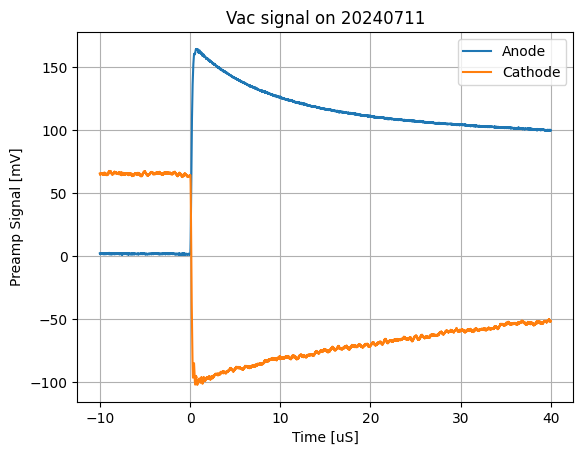

In [ ]:
wafeform_path="/Users/KK_Lab28_1/Documents/Waveforms/" # Path for data on July 7th

waveform_date="240710"
runnumber="00001"

waveform_dir=wafeform_path+waveform_date+"_"+runnumber
waveform_wavenumber="1"
waveform_filename=waveform_date+"_"+runnumber+"_"+waveform_wavenumber
waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
DF=pd.read_csv(waveform_fullpath,skiprows=[1])
DF["Avg UV"]=DF["Avg UV"]*1000 # Change from V to mV


plt.errorbar(x=DF["Time"],y=DF["Avg Anode"], label="Anode")
plt.errorbar(x=DF["Time"],y=DF["Avg UV"], label="Cathode")

plt.xlabel("Time [uS]")
plt.ylabel("Preamp Signal [mV]")
plt.grid()
plt.legend()
plt.title("Vac signal on 20240711")

## Run 3

In [12]:
wafeform_path="/Users/KK_Lab28_1/Documents/Waveforms/" # Path for data on July 7th

waveform_date="240710"
runnumber="00003"

waveform_dir=wafeform_path+waveform_date+"_"+runnumber
waveform_wavenumber="1"
waveform_filename=waveform_date+"_"+runnumber+"_"+waveform_wavenumber
waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
DF=pd.read_csv(waveform_fullpath,skiprows=[1])
DF["Avg UV"]=DF["Avg UV"]*1000 # Change from V to mV


plt.errorbar(x=DF["Time"],y=DF["Avg Anode"], label="Anode")
plt.errorbar(x=DF["Time"],y=DF["Avg UV"], label="Cathode")

plt.xlabel("Time [uS]")
plt.ylabel("Preamp Signal [mV]")
plt.grid()
plt.legend()
plt.title("Vac signal on 20240711")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/KK_Lab28_1/Documents/Waveforms/240710_00003/240710_00003_1.csv'

## Run 4

In [13]:
wafeform_path="/Users/KK_Lab28_1/Documents/Waveforms/" # Path for data on July 7th

waveform_date="240710"
runnumber="00004"

waveform_dir=wafeform_path+waveform_date+"_"+runnumber
waveform_wavenumber="2"
waveform_filename=waveform_date+"_"+runnumber+"_"+waveform_wavenumber
waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
DF=pd.read_csv(waveform_fullpath,skiprows=[1])
DF["Avg UV"]=DF["Avg UV"]*1000 # Change from V to mV
DF["Time"]=DF["Time"]*1000 # Change from mS to uS


plt.errorbar(x=DF["Time"],y=DF["Channel Anode"], label="Anode")
plt.errorbar(x=DF["Time"],y=DF["Channel UV"], label="Cathode")

plt.xlabel("Time [uS]")
plt.ylabel("Preamp Signal [mV]")
plt.grid()
plt.legend()
plt.title("Vac signal on 20240711")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/KK_Lab28_1/Documents/Waveforms/240710_00004/240710_00004_2.csv'

In [14]:
os.path.exists

<function genericpath.exists(path)>

# Grabbing data form early aug

In [15]:
#wafeform_path="/Users/KK_Lab28_1/Documents/Waveforms/" # Path for data on July 7th
wafeform_path="A:/DATA/waveforms/"
waveform_date="20240801"
runnumber="00029"


waveform_dir=wafeform_path+waveform_date+"-"+runnumber
waveform_wavenumber="10"
waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
DF=pd.read_csv(waveform_fullpath,skiprows=[1])
try:
    DF["Avg UV"]=DF["Avg UV (2)"]*1000 # Change from V to mV
except:
    DF["Avg UV"]=DF["Avg UV"]*1000 # Change from V to mV
DF["Time"]=DF["Time"] # Change from mS to uS


plt.errorbar(x=DF["Time"],y=DF["Avg Anode"]*1000, label="Anode")
plt.errorbar(x=DF["Time"],y=DF["Avg UV"], label="Cathode")

plt.xlabel("Time [uS]")
plt.ylabel("Preamp Signal [mV]")
plt.grid()
plt.legend()
plt.title("Gas Signal on 20240801")
#plt.xlim(-1000,10000)

FileNotFoundError: [Errno 2] No such file or directory: 'A:/DATA/waveforms/20240801-00029/20240801-00029_10.csv'

In [16]:
"%05i"%(rn)

NameError: name 'rn' is not defined

## Aug 1st 30-34

Run 00030   Field 312.500000  anode time Delay  6.98999986  Cathode delay  0.66200004
Run 00031   Field 437.500000  anode time Delay  6.73599986  Cathode delay  0.67200004
Run 00032   Field 562.500000  anode time Delay  6.38799987  Cathode delay  0.66400004
Run 00033   Field 687.500000  anode time Delay  6.06799988  Cathode delay  0.66400004
Run 00034   Field 812.500000  anode time Delay  5.67199989  Cathode delay  0.66000004
Drift time
[6.32799982 6.06399982 5.72399983 5.40399984 5.01199985]
[312.5, 437.5, 562.5, 687.5, 812.5]


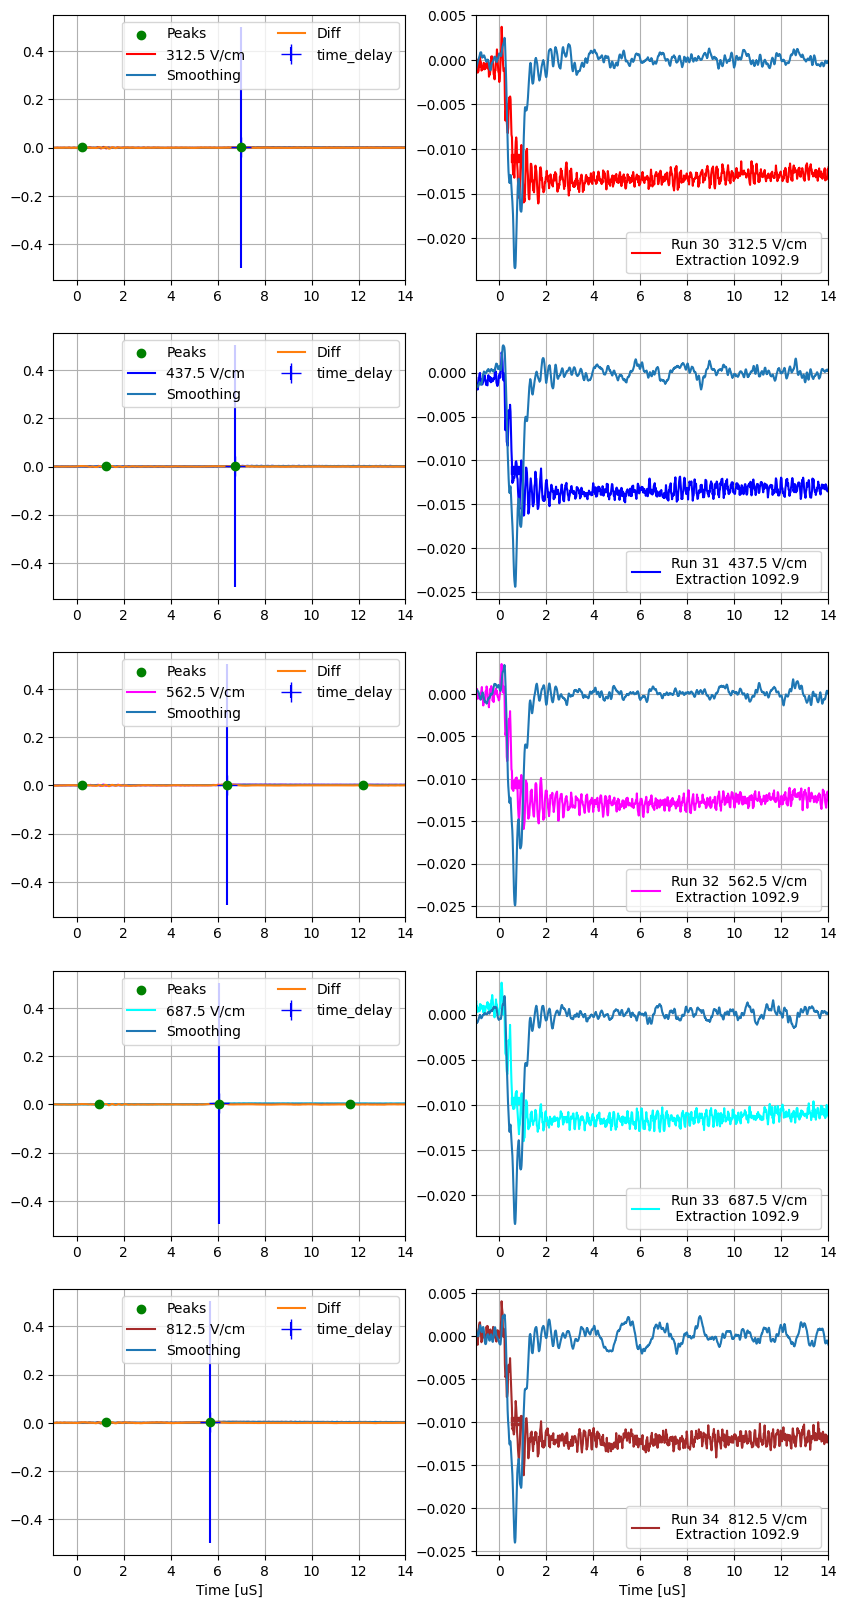

In [17]:

wafeform_path="C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/data/waveforms/" # Path for data On left pc


runnumbers= [30,31,32,33,34]

bg_runs = ""
c=["red","blue","magenta","cyan","brown","grey","skyblue","teal","red","blue","magenta","cyan","brown","grey","skyblue"]

#chann_names=["Avg Cathode","Avg Anode"]
#chann_names=["average(Cathode)","average(Anode)"]
chann_names=["Avg UV","Avg Anode"]


anode_time_delay=[]
catho_delay=[]
drift_field_list=[]
fig, axs = plt.subplots(len(runnumbers), 2,figsize=(10,20))


for i,rn  in enumerate(runnumbers):
    
    RI = GetRunInfo(rn)
    
    waveform_date ="%i"%(RI["Date"].iloc[0])
    runnumber="%05i"%(rn)
    stepcount=5
    waveform_dir=wafeform_path+waveform_date+"/"+waveform_date+"-"+runnumber
    waveform_wavenumber="10"
    waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
    waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
    DF=pd.read_csv(waveform_fullpath,skiprows=[1])
    
    anodenorm=np.average(DF[chann_names[1]][:100])
    cathnorm=np.average(DF[chann_names[0]][:100])

    ###Background - if bg run is there

    if bg_runs != "":
        bg_runnumber="00%i"%(bg_runs[i])
        BG_dir =wafeform_path +waveform_date+"/"+waveform_date+"-"+bg_runnumber
        bg_filename=waveform_date+"-"+bg_runnumber+"_"+waveform_wavenumber
        bg_fullpath= BG_dir + "/"+bg_filename + ".csv"
        bgDF=pd.read_csv(bg_fullpath,skiprows=[1])
        bg_anodenorm=np.average(bgDF[chann_names[1]][:100])
        bg_y=(bgDF[chann_names[1]]- bg_anodenorm)*bg_norm
        
        sub = (DF[chann_names[1]] - anodenorm) - bg_y
        
        ## Plot subtracted version
        axs[i][0].errorbar(x = DF["Time"][::stepcount],y=sub[::stepcount] , color="black", label="Subtracted")

        ##BG
        axs[i][0].errorbar(x=bgDF["Time"][::stepcount*2], fmt="--",
            y=(bgDF[chann_names[1]][::stepcount*2] - bg_anodenorm)*bg_norm, 
            color="grey", label="BackGround")
        ##


    else :
        bg_y=0
        sub=(DF[chann_names[1]] - anodenorm)


    ####



    drift_field = RI["Drift Field"].iloc[0]#RI["Cathode Grid V."].iloc[0]/(9.14/10)
    extract_field=RI["Extraction Field"].iloc[0]


    #print(drift_field)



    bg_norm=1# np.max(DF[chann_names[1]][::stepcount] - anodenorm) / np.max(bgDF[chann_names[1]][::stepcount*2] - bg_anodenorm)

    axs[i][0].errorbar(x=DF["Time"][::stepcount],y=DF[chann_names[1]][::stepcount] - anodenorm, color= c[i], label="%0.1f V/cm "%(drift_field))

    stepsize=100
    diffsize=50
    diff_timestep= (DF["Time"].iloc[diffsize]-DF["Time"].iloc[0])

    xdata=np.array(DF["Time"])
    ydata= sub                 #DF[chann_names[1]]-np.average(DF[chann_names[1]][:20])
    yrolling= sub.rolling(stepsize).mean()              #ydata.rolling(stepsize).mean()
    yprime=np.array(yrolling.diff(diffsize))/(diff_timestep)

    ydata_nparray=np.array(ydata)



    local_minima_indices = argrelextrema(np.array(yprime), np.greater,order=1050)
    #local_minima_indices = argrelextrema(np.array(yprime), np.less,order=350)

    #print(local_minima_indices)
    # Get the x and y values of the local minima
    x_minima = xdata[local_minima_indices]
    y_minima = yprime[local_minima_indices]
    axs[i][0].scatter(x_minima, y_minima, color='green', label='Peaks', zorder=5)
    axs[i][0].errorbar(xdata,yrolling,label="Smoothing")
    axs[i][0].errorbar(xdata,yprime,label="Diff")
    
    ydata_minima = ydata_nparray[local_minima_indices[0][0]]
    #axs[i].scatter(x_minima[1], ydata_minima, color=c[i])
    
    time_delay_ind=0
    time_delay=xdata[np.array(local_minima_indices)[0][0]]
    while time_delay <3.5 :
        time_delay_ind=1 +time_delay_ind
        time_delay=xdata[np.array(local_minima_indices)[0][time_delay_ind]]
        if time_delay_ind > len(np.array(local_minima_indices)[0]) -1:
            print("Breaking out of while loop")
            break
        

    


    anode_time_delay.append(xdata[np.array(local_minima_indices)[0][time_delay_ind]])
    ydata_minima = ydata_nparray[local_minima_indices[0][time_delay_ind]]


    #print( x_minima[time_delay_ind], ydata_minima )
    axs[i][0].errorbar(x_minima[time_delay_ind], ydata_minima,yerr=0.5, markersize=15,
                       fmt=" ", marker="+", color="blue", label="time_delay")



    axs[i][0].grid()
    axs[i][0].legend()

##cathods

    axs[i][1].errorbar(x=DF["Time"][::stepcount],y=DF[chann_names[0]][::stepcount] - cathnorm, color= c[i]
                       , label="Run %i  %0.1f V/cm  \n Extraction %0.1f"%(rn, drift_field,extract_field))
    axs[i][1].grid()
    axs[i][1].legend()

    Time=np.array(DF["Time"])
    Cath =DF[chann_names[0]] - cathnorm
    diff = Cath.rolling(stepsize).mean().diff(diffsize)/diff_timestep

    axs[i][1].errorbar(Time,diff,label="Diff")


    cond= np.abs(diff)== np.max(np.abs(diff))
    #cond= np.abs(diff)>=5

    

    try:
        aa="a"
        #    print(Time[np.where(cond)][-1])
    except:
        print("issue with cathode timing")
    cd=Time[np.where(cond)][-1]
    cd_amp=np.array(Cath.iloc[np.where(cond)])[-1]
    catho_delay.append(cd)
    #print(cd_amp)

    axs[i][1].scatter(cd,cd_amp,marker="s",color=c[i])
    #catho_delay.append(Time[np.where(Cath == Cath_min)][0])
    #axs[i].set_xlim(-1,3)
    drift_field_list.append(drift_field)
    #print(i)
    axs[i][0].legend(ncol=2)

    axs[i][1].set_xlim(-1,14)

    axs[i][0].set_xlim(-1,14)
    #axs[i][0].set_ylim(-6,8)

    print("Run %s"%(runnumber), "  Field %f"%(drift_field) , " anode time Delay ",time_delay, " Cathode delay ", cd )

axs[i][1].set_xlabel("Time [uS]")




# print("cath")
# print(catho_delay)
# print("anode")
#print(anode_time_delay)

Drift_time=np.array(anode_time_delay)-np.array(catho_delay)

print("Drift time")
print(Drift_time)
print(drift_field_list)



    

#axs[0].set_xlabel("Time [uS]")
#axs[0].set_ylabel("Preamp Signal [mV]")

#axs[0].grid()
#axs[0][0].legend()


axs[i][0].set_xlabel("Time [uS]")
#axs[1].set_ylabel("Preamp Signal [mV]")
#axs[1].grid()
#axs[1].legend()

    #plt.title("Signal on 20240926")
#plt.xlim(-1000,10000)
drift_time_Sept18=np.array(Drift_time)
drift_field_list_Sept18=drift_field_list

## Sept 17th gas data using new script

Run 00103   Field 599.562363  anode time Delay  9.17066646  Cathode delay  1.87066667
Run 00104   Field 500.000000  anode time Delay  9.37466646  Cathode delay  1.96666666
Run 00105   Field 400.437637  anode time Delay  9.66499978  Cathode delay  2.081
Run 00106   Field 299.781182  anode time Delay  9.81799978  Cathode delay  2.15799999
Run 00107   Field 200.218818  anode time Delay  9.77599978  Cathode delay  2.072
Drift time
[7.29999979 7.4079998  7.58399978 7.65999979 7.70399978]
[599.562363238512, 500.0, 400.43763676148797, 299.781181619256, 200.21881838074398]


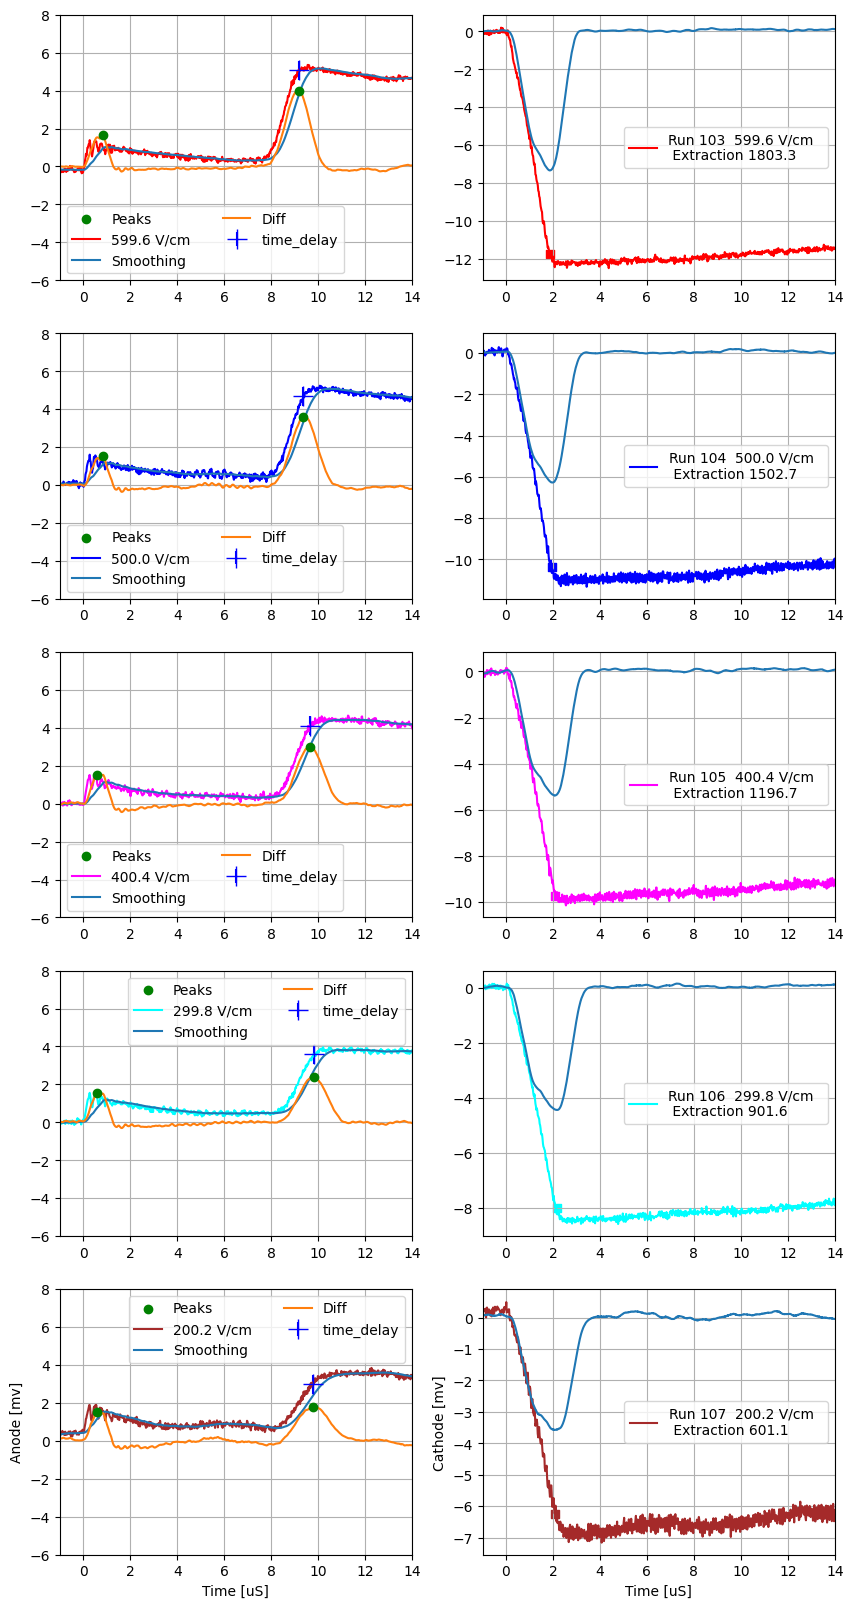

In [12]:

wafeform_path="C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/data/waveforms/" # Path for data On left pc


runnumbers= [103,104,105,106,107]

bg_runs = ""
c=["red","blue","magenta","cyan","brown","grey","skyblue","teal","red","blue","magenta","cyan","brown","grey","skyblue"]

#chann_names=["Avg Cathode","Avg Anode"]
chann_names=["average(Cathode)","average(Anode)"]

anode_time_delay=[]
catho_delay=[]
drift_field_list=[]
fig, axs = plt.subplots(len(runnumbers), 2,figsize=(10,20))


for i,rn  in enumerate(runnumbers):
    
    RI = GetRunInfo(rn)
    
    waveform_date ="%i"%(RI["Date"].iloc[0])
    runnumber="00%i"%(rn)
    stepcount=5
    waveform_dir=wafeform_path+waveform_date+"/"+waveform_date+"-"+runnumber
    waveform_wavenumber="10"
    waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
    waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
    DF=pd.read_csv(waveform_fullpath,skiprows=[1])
    
    anodenorm=np.average(DF[chann_names[1]][:100])
    cathnorm=np.average(DF[chann_names[0]][:100])

    ###Background - if bg run is there

    if bg_runs != "":
        bg_runnumber="00%i"%(bg_runs[i])
        BG_dir =wafeform_path +waveform_date+"/"+waveform_date+"-"+bg_runnumber
        bg_filename=waveform_date+"-"+bg_runnumber+"_"+waveform_wavenumber
        bg_fullpath= BG_dir + "/"+bg_filename + ".csv"
        bgDF=pd.read_csv(bg_fullpath,skiprows=[1])
        bg_anodenorm=np.average(bgDF[chann_names[1]][:100])
        bg_y=(bgDF[chann_names[1]]- bg_anodenorm)*bg_norm
        
        sub = (DF[chann_names[1]] - anodenorm) - bg_y
        
        ## Plot subtracted version
        axs[i][0].errorbar(x = DF["Time"][::stepcount],y=sub[::stepcount] , color="black", label="Subtracted")

        ##BG
        axs[i][0].errorbar(x=bgDF["Time"][::stepcount*2], fmt="--",
            y=(bgDF[chann_names[1]][::stepcount*2] - bg_anodenorm)*bg_norm, 
            color="grey", label="BackGround")
        ##


    else :
        bg_y=0
        sub=(DF[chann_names[1]] - anodenorm)


    ####



    drift_field = RI["Drift Field"].iloc[0]#RI["Cathode Grid V."].iloc[0]/(9.14/10)
    extract_field=RI["Extraction Field"].iloc[0]


    #print(drift_field)



    bg_norm=1# np.max(DF[chann_names[1]][::stepcount] - anodenorm) / np.max(bgDF[chann_names[1]][::stepcount*2] - bg_anodenorm)

    axs[i][0].errorbar(x=DF["Time"][::stepcount],y=DF[chann_names[1]][::stepcount] - anodenorm, color= c[i], label="%0.1f V/cm "%(drift_field))

    stepsize=200
    diffsize=100
    diff_timestep= (DF["Time"].iloc[diffsize]-DF["Time"].iloc[0])

    xdata=np.array(DF["Time"])
    ydata= sub                 #DF[chann_names[1]]-np.average(DF[chann_names[1]][:20])
    yrolling= sub.rolling(stepsize).mean()              #ydata.rolling(stepsize).mean()
    yprime=np.array(yrolling.diff(diffsize))/(diff_timestep)

    ydata_nparray=np.array(ydata)



    local_minima_indices = argrelextrema(np.array(yprime), np.greater,order=1050)
    #local_minima_indices = argrelextrema(np.array(yprime), np.less,order=350)

    #print(local_minima_indices)
    # Get the x and y values of the local minima
    x_minima = xdata[local_minima_indices]
    y_minima = yprime[local_minima_indices]
    axs[i][0].scatter(x_minima, y_minima, color='green', label='Peaks', zorder=5)
    axs[i][0].errorbar(xdata,yrolling,label="Smoothing")
    axs[i][0].errorbar(xdata,yprime,label="Diff")
    
    ydata_minima = ydata_nparray[local_minima_indices[0][0]]
    #axs[i].scatter(x_minima[1], ydata_minima, color=c[i])
    
    time_delay_ind=0
    time_delay=xdata[np.array(local_minima_indices)[0][0]]
    while time_delay <3.5 :
        time_delay_ind=1 +time_delay_ind
        time_delay=xdata[np.array(local_minima_indices)[0][time_delay_ind]]
        if time_delay_ind > len(np.array(local_minima_indices)[0]) -1:
            print("Breaking out of while loop")
            break
        

    


    anode_time_delay.append(xdata[np.array(local_minima_indices)[0][time_delay_ind]])
    ydata_minima = ydata_nparray[local_minima_indices[0][time_delay_ind]]


    #print( x_minima[time_delay_ind], ydata_minima )
    axs[i][0].errorbar(x_minima[time_delay_ind], ydata_minima,yerr=0.5, markersize=15,
                       fmt=" ", marker="+", color="blue", label="time_delay")



    axs[i][0].grid()
    axs[i][0].legend()

##cathods

    axs[i][1].errorbar(x=DF["Time"][::stepcount],y=DF[chann_names[0]][::stepcount] - cathnorm, color= c[i]
                       , label="Run %i  %0.1f V/cm  \n Extraction %0.1f"%(rn, drift_field,extract_field))
    axs[i][1].grid()
    axs[i][1].legend()

    Time=np.array(DF["Time"])
    Cath =DF[chann_names[0]] - cathnorm
    diff = Cath.rolling(stepsize).mean().diff(diffsize)/diff_timestep

    axs[i][1].errorbar(Time,diff,label="Diff")


    cond= np.abs(diff)== np.max(np.abs(diff))
    #cond= np.abs(diff)>=5

    

    try:
        aa="a"
        #    print(Time[np.where(cond)][-1])
    except:
        print("issue with cathode timing")
    cd=Time[np.where(cond)][-1]
    cd_amp=np.array(Cath.iloc[np.where(cond)])[-1]
    catho_delay.append(cd)
    #print(cd_amp)

    axs[i][1].scatter(cd,cd_amp,marker="s",color=c[i])
    #catho_delay.append(Time[np.where(Cath == Cath_min)][0])
    #axs[i].set_xlim(-1,3)
    drift_field_list.append(drift_field)
    #print(i)
    axs[i][0].legend(ncol=2)

    axs[i][1].set_xlim(-1,14)

    axs[i][0].set_xlim(-1,14)
    axs[i][0].set_ylim(-6,8)

    print("Run %s"%(runnumber), "  Field %f"%(drift_field) , " anode time Delay ",time_delay, " Cathode delay ", cd )

axs[i][1].set_xlabel("Time [uS]")
axs[i][1].set_ylabel("Cathode [mv]")
axs[i][0].set_ylabel("Anode [mv]")




# print("cath")
# print(catho_delay)
# print("anode")
#print(anode_time_delay)

Drift_time=np.array(anode_time_delay)-np.array(catho_delay)

print("Drift time")
print(Drift_time)
print(drift_field_list)



    

#axs[0].set_xlabel("Time [uS]")
#axs[0].set_ylabel("Preamp Signal [mV]")

#axs[0].grid()
#axs[0][0].legend()


axs[i][0].set_xlabel("Time [uS]")
#axs[1].set_ylabel("Preamp Signal [mV]")
#axs[1].grid()
#axs[1].legend()

    #plt.title("Signal on 20240926")
#plt.xlim(-1000,10000)
drift_time_Sept18=np.array(Drift_time)
drift_field_list_Sept18=drift_field_list

In [13]:
N_Sept18= ((25 *6894.76)/( (1.38*10**(-23))* 293)) 
N_Sept18

4.262971756442599e+25

## Electron Drift and Longitudinal Diffusion in High Pressure Xenon-Helium Gas Mixtures
FERMILAB-PUB-19-518-ND-SCD (accepted)
DOI: 10.1088/1748-0221/14/08/P08009
arXiv:1902.05544 [physics.ins-det]

In [403]:
NEXT_2018_RedF =(np.array([5.295,10.591, 11.405,13.849, 24.44, 31.365, 39.919, 48.88, 63.137, 78.615, 92.872])/100000)/( (1.38*10**(-23))* 293) *10**(-21) 
NEXT_2018_vel = [0.088, 0.369, 0.417, 0.617, 0.82, 0.877, 0.908, 0.936, 0.999, 1.041, 1.068]  #[mm/us]


Text(0.5, 0, 'Drift Field [V/cm]')

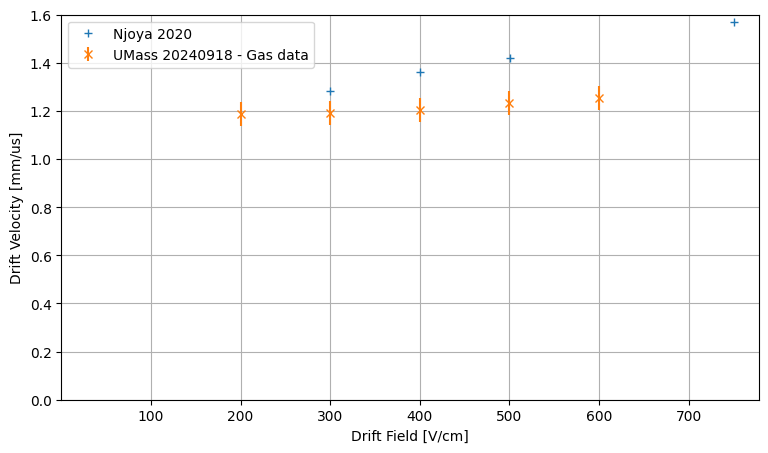

In [15]:
fig,ax= plt.subplots(1, 1, figsize=(9,5))


njyl=np.array([1.568,1.422, 1.36, 1.285])
njxl=np.array([750.98,500.98,400,300])
#njoya_x=[200*2,200*2,300*2,400*2,500*2,1000*2]

njoya_x=njxl
njoya_y=njyl
BNL_N= ((14.7 *6894.76)/( (1.38*10**(-23))* 293)) 

ax.errorbar(x=njoya_x,y=njoya_y,fmt=" ",marker="+",label="Njoya 2020")

#ax.errorbar(x=NEXT_2018_RedF*1000 ,y=NEXT_2018_vel,fmt=" ",marker="s",label="NEXT 2018")



ax.errorbar(x=np.array(drift_field_list_Sept18) ,y=(9.14)/drift_time_Sept18, yerr= 0.05,fmt=" " ,marker="x",label="UMass 20240918 - Gas data")
ax.grid()
ax.legend()
ax.set_ylim(0.0,1.6)
ax.set_xlim(0.01)

#ax.text(0.4,1.15,"%0.0f [v/cm]"%(drift_field_list_Sept18[-1]))
#ax.text(1.4,1.18,"%0.0f [v/cm]"%(drift_field_list_Sept18[0]))


ax.set_ylabel("Drift Velocity [mm/us]")
ax.set_xlabel("Drift Field [V/cm]")

Text(0.5, 0, 'Reduced Field V/N [ Td]')

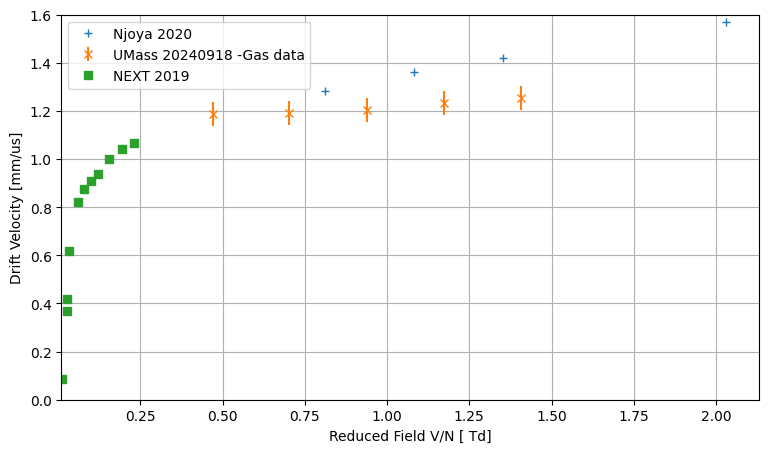

In [16]:
fig,ax= plt.subplots(1, 1, figsize=(9,5))


njyl=np.array([1.568,1.422, 1.36, 1.285])
njxl=np.array([750.98,500.98,400,300])
#njoya_x=[200*2,200*2,300*2,400*2,500*2,1000*2]

njoya_x=njxl
njoya_y=njyl
BNL_N= (((21.7) *6894.76)/( (1.38*10**(-23))* 293)) 

ax.errorbar(x=njoya_x/BNL_N*100 / 10**(-21),y=njoya_y,fmt=" ",marker="+",label="Njoya 2020 ")

ax.errorbar(x=(np.array(drift_field_list_Sept18)/N_Sept18 )*100/ 10**(-21) ,y=(9.14)/drift_time_Sept18,
            yerr=0.05,fmt=" " ,marker="x",label="UMass 20240918 -Gas data")

ax.errorbar(x=NEXT_2018_RedF*1000 ,y=NEXT_2018_vel,fmt=" ",marker="s",label="NEXT 2019")




ax.grid()
ax.legend()
#ax.set_ylim(0.6,1.7)
#ax.set_xlim(0.01,1.7)

#ax.text(0.4,1.15,"%0.0f [v/cm]"%(drift_field_list_Sept18[-1]))
#ax.text(1.4,1.18,"%0.0f [v/cm]"%(drift_field_list_Sept18[0]))
ax.set_ylim(0.0,1.6)
ax.set_xlim(0.01)

ax.set_ylabel("Drift Velocity [mm/us]")
ax.set_xlabel("Reduced Field V/N [ Td]")

# Data form Sept 17

PHYS-PSB02801
Run:  00054  Anode str:  1.951637699999992  Cathode str:  7.7283449
Run:  00062  Anode str:  1.806094299999998  Cathode str:  6.118642099999999
Run:  00063  Anode str:  1.5500383000000042  Cathode str:  4.763031699999999


Text(0.5, 1.0, 'Gas Signal on 20240917')

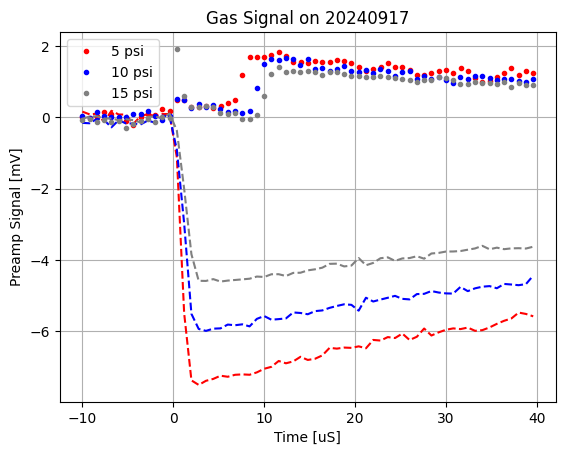

In [411]:
#wafeform_path="/Users/KK_Lab28_1/Documents/Waveforms/" # Path for data on July 7th
#wafeform_path="A:/DATA/waveforms/"
wafeform_path="C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/data/waveforms/" # Path for data On left pc
waveform_date="20240917"
runnumber="00054"

stepcount=200
print(pcname)
if pcname == "PHYS-PSB02801":
    waveform_dir=wafeform_path+waveform_date+"/"+waveform_date+"-"+runnumber
else:
    waveform_dir=wafeform_path+waveform_date+"-"+runnumber

waveform_wavenumber="10"
waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
DF=pd.read_csv(waveform_fullpath,skiprows=[1])



anodenorm=np.average(DF["Average Anode (2)"][:100])
cathnorm=np.average(DF["Average Cathode (2)"][:100])


plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Anode (2)"][::stepcount] - anodenorm, color= "red", fmt=".",label="5 psi")
plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Cathode (2)"][::stepcount] - cathnorm, color= "red", fmt="--",)
Anode_amp   =abs(np.average(DF["Average Anode (2)"][:100])-np.max(DF["Average Anode (2)"][2700:]))
Cathode_amp =abs(np.average(DF["Average Cathode (2)"][:100])-np.min(DF["Average Cathode (2)"]))
print("Run: ",runnumber," Anode str: ", Anode_amp, " Cathode str: ", Cathode_amp)


runnumber="00062"


waveform_dir=wafeform_path+waveform_date+"-"+runnumber
waveform_wavenumber="10"
if pcname == "PHYS-PSB02801":
    waveform_dir=wafeform_path+waveform_date+"/"+waveform_date+"-"+runnumber
else:
    waveform_dir=wafeform_path+waveform_date+"-"+runnumber
waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
DF=pd.read_csv(waveform_fullpath,skiprows=[1])


anodenorm=np.average(DF["Average Anode (2)"][:100])
cathnorm=np.average(DF["Average Cathode (2)"][:100])

plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Anode (2)"][::stepcount] - anodenorm, color= "Blue", fmt=".",label="10 psi")
plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Cathode (2)"][::stepcount] - cathnorm, color= "Blue", fmt="--",)
Anode_amp   =abs(np.average(DF["Average Anode (2)"][:100])-np.max(DF["Average Anode (2)"][2700:]))
Cathode_amp =abs(np.average(DF["Average Cathode (2)"][:100])-np.min(DF["Average Cathode (2)"]))
print("Run: ",runnumber," Anode str: ", Anode_amp, " Cathode str: ", Cathode_amp)

runnumber="00063"

if pcname == "PHYS-PSB02801":
    waveform_dir=wafeform_path+waveform_date+"/"+waveform_date+"-"+runnumber
else:
    waveform_dir=wafeform_path+waveform_date+"-"+runnumber
waveform_wavenumber="10"
waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
DF=pd.read_csv(waveform_fullpath,skiprows=[1])

anodenorm=np.average(DF["Average Anode (2)"][:100])
cathnorm=np.average(DF["Average Cathode (2)"][:100])

plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Anode (2)"][0::stepcount] - anodenorm, color= "Gray", fmt=".",label="15 psi")
plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Cathode (2)"][::stepcount] - cathnorm, color= "Gray", fmt="--",)


Anode_amp   =abs(np.average(DF["Average Anode (2)"][:100])-np.max(DF["Average Anode (2)"][2700:]))
Cathode_amp =abs(np.average(DF["Average Cathode (2)"][:100])-np.min(DF["Average Cathode (2)"]))
print("Run: ",runnumber," Anode str: ", Anode_amp, " Cathode str: ", Cathode_amp)

plt.xlabel("Time [uS]")
plt.ylabel("Preamp Signal [mV]")
plt.grid()
plt.legend()
plt.title("Gas Signal on 20240917")
#plt.xlim(-1000,10000)



Text(0.5, 1.0, 'Gas Signal on 20240917')

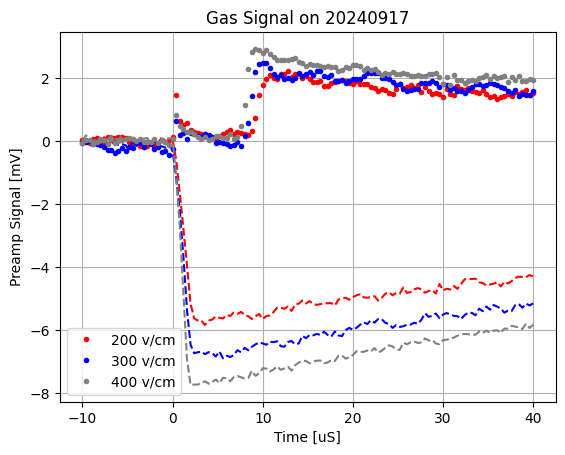

In [29]:
#wafeform_path="/Users/KK_Lab28_1/Documents/Waveforms/" # Path for data on July 7th
wafeform_path="A:/DATA/waveforms/"
waveform_date="20240917"
runnumber="00064"

stepcount=100
waveform_dir=wafeform_path+waveform_date+"-"+runnumber
waveform_wavenumber="10"
waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
DF=pd.read_csv(waveform_fullpath,skiprows=[1])



anodenorm=np.average(DF["Average Anode (2)"][:100])
cathnorm=np.average(DF["Average Cathode (2)"][:100])


plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Anode (2)"][::stepcount] - anodenorm, color= "red", fmt=".",label="200 v/cm")
plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Cathode (2)"][::stepcount] - cathnorm, color= "red", fmt="--",)



runnumber="00065"


waveform_dir=wafeform_path+waveform_date+"-"+runnumber
waveform_wavenumber="10"
waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
DF=pd.read_csv(waveform_fullpath,skiprows=[1])


anodenorm=np.average(DF["Average Anode (2)"][:100])
cathnorm=np.average(DF["Average Cathode (2)"][:100])

plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Anode (2)"][::stepcount] - anodenorm, color= "Blue", fmt=".",label="300 v/cm")
plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Cathode (2)"][::stepcount] - cathnorm, color= "Blue", fmt="--",)


runnumber="00066"


waveform_dir=wafeform_path+waveform_date+"-"+runnumber
waveform_wavenumber="10"
waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
DF=pd.read_csv(waveform_fullpath,skiprows=[1])

anodenorm=np.average(DF["Average Anode (2)"][:100])
cathnorm=np.average(DF["Average Cathode (2)"][:100])

plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Anode (2)"][0::stepcount] - anodenorm, color= "Gray", fmt=".",label="400 v/cm")
plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Cathode (2)"][::stepcount] - cathnorm, color= "Gray", fmt="--",)




plt.xlabel("Time [uS]")
plt.ylabel("Preamp Signal [mV]")
plt.grid()
plt.legend()
plt.title("Gas Signal on 20240917")
#plt.xlim(-1000,10000)

## Run55 cathode off

Text(0.5, 1.0, 'Gas Signal on 20240917')

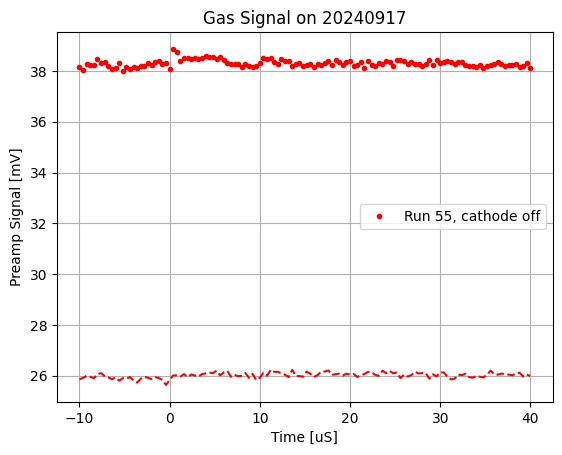

In [53]:
#wafeform_path="/Users/KK_Lab28_1/Documents/Waveforms/" # Path for data on July 7th
wafeform_path="A:/DATA/waveforms/"
waveform_date="20240917"
runnumber="00055"

stepcount=100
waveform_dir=wafeform_path+waveform_date+"-"+runnumber
waveform_wavenumber="10"
waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
DF=pd.read_csv(waveform_fullpath,skiprows=[1])



anodenorm=0#np.average(DF["Average Anode (2)"][:100])
cathnorm=-20#np.average(DF["Average Cathode (2)"][:100])


plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Anode (2)"][::stepcount] - anodenorm, color= "red", fmt=".",label="Run 55, cathode off")
plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Cathode (2)"][::stepcount] - cathnorm, color= "red", fmt="--",)



# runnumber="00065"


# waveform_dir=wafeform_path+waveform_date+"-"+runnumber
# waveform_wavenumber="10"
# waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
# waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
# DF=pd.read_csv(waveform_fullpath,skiprows=[1])


# anodenorm=np.average(DF["Average Anode (2)"][:100])
# cathnorm=np.average(DF["Average Cathode (2)"][:100])

# plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Anode (2)"][::stepcount] - anodenorm, color= "Blue", fmt=".",label="300 v/cm")
# plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Cathode (2)"][::stepcount] - cathnorm, color= "Blue", fmt="--",)


# runnumber="00066"


# waveform_dir=wafeform_path+waveform_date+"-"+runnumber
# waveform_wavenumber="10"
# waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
# waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
# DF=pd.read_csv(waveform_fullpath,skiprows=[1])

# anodenorm=np.average(DF["Average Anode (2)"][:100])
# cathnorm=np.average(DF["Average Cathode (2)"][:100])

# plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Anode (2)"][0::stepcount] - anodenorm, color= "Gray", fmt=".",label="400 v/cm")
# plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Cathode (2)"][::stepcount] - cathnorm, color= "Gray", fmt="--",)




plt.xlabel("Time [uS]")
plt.ylabel("Preamp Signal [mV]")
plt.grid()
plt.legend()
plt.title("Gas Signal on 20240917")
#plt.xlim(-1000,10000)

# Data From Sept 20th

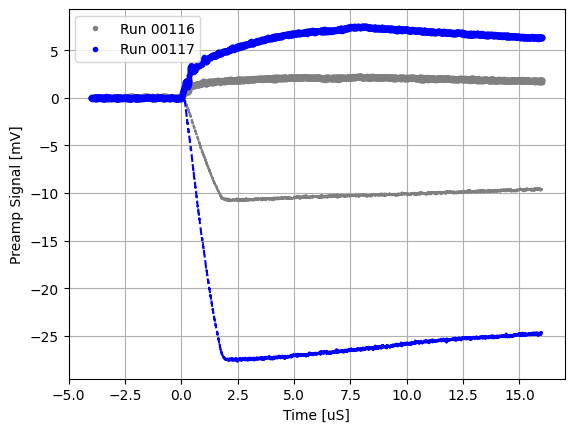

In [159]:
#wafeform_path="/Users/KK_Lab28_1/Documents/Waveforms/" # Path for data on July 7th
wafeform_path="A:/DATA/waveforms/"
wafeform_path="C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/data/waveforms/" # Path for data On left pc

# waveform_date="20240920"
# runnumber="00115"

# stepcount=100
# waveform_dir=wafeform_path+waveform_date+"-"+runnumber
# waveform_wavenumber="10"
# waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
# waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
# DF=pd.read_csv(waveform_fullpath,skiprows=[1])



# anodenorm=np.average(DF["average(Anode)"][:100])
# cathnorm=np.average(DF["average(Cathode)"][:100])


# plt.errorbar(x=DF["Time"][::stepcount],y=DF["average(Anode)"][::stepcount] - anodenorm, color= "Gray", fmt=".",label="Run %s"%(runnumber))
# plt.errorbar(x=DF["Time"][::stepcount],y=DF["average(Cathode)"][::stepcount] - cathnorm, color= "Gray", fmt="--",)

waveform_date="20240926"
runnumber="00116"

stepcount=1
waveform_dir=wafeform_path+waveform_date+"/"+waveform_date+"-"+runnumber
waveform_wavenumber="10"
waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
DF=pd.read_csv(waveform_fullpath,skiprows=[1])



anodenorm=np.average(DF["average(Anode)"][:100])
cathnorm=np.average(DF["average(Cathode)"][:100])


plt.errorbar(x=DF["Time"][::stepcount],y=DF["average(Anode)"][::stepcount] - anodenorm, color= "Grey", fmt=".",label="Run %s"%(runnumber))
plt.errorbar(x=DF["Time"][::stepcount],y=DF["average(Cathode)"][::stepcount] - cathnorm, color= "Grey", fmt="--",)



# waveform_date="20240920"
# runnumber="00113"

# stepcount=1#00
# waveform_dir=wafeform_path+waveform_date+"-"+runnumber
# waveform_wavenumber="10"
# waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
# waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
# DF=pd.read_csv(waveform_fullpath,skiprows=[1])



# anodenorm=np.average(DF["average(Anode)"][:100])
# cathnorm=np.average(DF["average(Cathode)"][:100])


# plt.errorbar(x=DF["Time"][::stepcount],y=DF["average(Anode)"][::stepcount] - anodenorm, color= "red", fmt=".",label="Run %s"%(runnumber))
# plt.errorbar(x=DF["Time"][::stepcount],y=DF["average(Cathode)"][::stepcount] - cathnorm, color= "red", fmt="--",)


waveform_date="20240926"
runnumber="00117"

stepcount=1
waveform_dir=wafeform_path+waveform_date+"/"+waveform_date+"-"+runnumber
waveform_wavenumber="10"
waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
DF=pd.read_csv(waveform_fullpath,skiprows=[1])



anodenorm=np.average(DF["average(Anode)"][:100])
cathnorm=np.average(DF["average(Cathode)"][:100])


plt.errorbar(x=DF["Time"][::stepcount],y=DF["average(Anode)"][::stepcount] - anodenorm, color= "blue", fmt=".",label="Run %s"%(runnumber))
plt.errorbar(x=DF["Time"][::stepcount],y=DF["average(Cathode)"][::stepcount] - cathnorm, color= "blue", fmt="--",)



# runnumber="00065"


# waveform_dir=wafeform_path+waveform_date+"-"+runnumber
# waveform_wavenumber="10"
# waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
# waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
# DF=pd.read_csv(waveform_fullpath,skiprows=[1])


# anodenorm=np.average(DF["Average Anode (2)"][:100])
# cathnorm=np.average(DF["Average Cathode (2)"][:100])

# plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Anode (2)"][::stepcount] - anodenorm, color= "Blue", fmt=".",label="300 v/cm")
# plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Cathode (2)"][::stepcount] - cathnorm, color= "Blue", fmt="--",)


# runnumber="00066"


# waveform_dir=wafeform_path+waveform_date+"-"+runnumber
# waveform_wavenumber="10"
# waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
# waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
# DF=pd.read_csv(waveform_fullpath,skiprows=[1])

# anodenorm=np.average(DF["Average Anode (2)"][:100])
# cathnorm=np.average(DF["Average Cathode (2)"][:100])

# plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Anode (2)"][0::stepcount] - anodenorm, color= "Gray", fmt=".",label="400 v/cm")
# plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Cathode (2)"][::stepcount] - cathnorm, color= "Gray", fmt="--",)




plt.xlabel("Time [uS]")
plt.ylabel("Preamp Signal [mV]")
plt.grid()
plt.legend()
#plt.title()
#plt.xlim(-1000,10000)

# Sept 26th


Text(0.5, 1.0, 'Signal on 20240926')

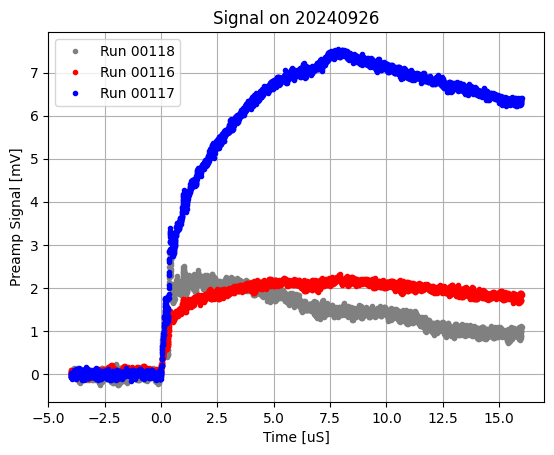

In [155]:
#wafeform_path="/Users/KK_Lab28_1/Documents/Waveforms/" # Path for data on July 7th
wafeform_path="A:/DATA/waveforms/"
wafeform_path="C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/data/waveforms/" # Path for data On left pc

# waveform_date="20240920"
# runnumber="00115"

# stepcount=100
# waveform_dir=wafeform_path+waveform_date+"-"+runnumber
# waveform_wavenumber="10"
# waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
# waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
# DF=pd.read_csv(waveform_fullpath,skiprows=[1])



# anodenorm=np.average(DF["average(Anode)"][:100])
# cathnorm=np.average(DF["average(Cathode)"][:100])


# plt.errorbar(x=DF["Time"][::stepcount],y=DF["average(Anode)"][::stepcount] - anodenorm, color= "Gray", fmt=".",label="Run %s"%(runnumber))
# plt.errorbar(x=DF["Time"][::stepcount],y=DF["average(Cathode)"][::stepcount] - cathnorm, color= "Gray", fmt="--",)

waveform_date="20240926"
runnumber="00118"

stepcount=1
waveform_dir=wafeform_path+"/"+waveform_date+"/"+waveform_date+"-"+runnumber
waveform_wavenumber="10"
waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
DF=pd.read_csv(waveform_fullpath,skiprows=[1])



anodenorm=np.average(DF["average(Anode)"][:100])
cathnorm=np.average(DF["average(Cathode)"][:100])


plt.errorbar(x=DF["Time"][::stepcount],y=DF["average(Anode)"][::stepcount] - anodenorm, color= "Grey", fmt=".",label="Run %s"%(runnumber))
#plt.errorbar(x=DF["Time"][::stepcount],y=DF["average(Cathode)"][::stepcount] - cathnorm, color= "Grey", fmt="--",)



waveform_date="20240926"
runnumber="00116"

stepcount=1
waveform_dir=wafeform_path+"/"+waveform_date+"/"+waveform_date+"-"+runnumber
waveform_wavenumber="10"
waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
DF=pd.read_csv(waveform_fullpath,skiprows=[1])



anodenorm=np.average(DF["average(Anode)"][:100])
cathnorm=np.average(DF["average(Cathode)"][:100])


plt.errorbar(x=DF["Time"][::stepcount],y=DF["average(Anode)"][::stepcount] - anodenorm, color= "red", fmt=".",label="Run %s"%(runnumber))
#plt.errorbar(x=DF["Time"][::stepcount],y=DF["average(Cathode)"][::stepcount] - cathnorm, color= "red", fmt="--",)


waveform_date="20240926"
runnumber="00117"

stepcount=1
waveform_dir=wafeform_path+"/"+waveform_date+"/"+waveform_date+"-"+runnumber
waveform_wavenumber="10"
waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
DF=pd.read_csv(waveform_fullpath,skiprows=[1])



anodenorm=np.average(DF["average(Anode)"][:100])
cathnorm=np.average(DF["average(Cathode)"][:100])


plt.errorbar(x=DF["Time"][::stepcount],y=DF["average(Anode)"][::stepcount] - anodenorm, color= "blue", fmt=".",label="Run %s"%(runnumber))
#plt.errorbar(x=DF["Time"][::stepcount],y=DF["average(Cathode)"][::stepcount] - cathnorm, color= "blue", fmt="--",)



# runnumber="00065"


# waveform_dir=wafeform_path+waveform_date+"-"+runnumber
# waveform_wavenumber="10"
# waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
# waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
# DF=pd.read_csv(waveform_fullpath,skiprows=[1])


# anodenorm=np.average(DF["Average Anode (2)"][:100])
# cathnorm=np.average(DF["Average Cathode (2)"][:100])

# plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Anode (2)"][::stepcount] - anodenorm, color= "Blue", fmt=".",label="300 v/cm")
# plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Cathode (2)"][::stepcount] - cathnorm, color= "Blue", fmt="--",)


# runnumber="00066"


# waveform_dir=wafeform_path+waveform_date+"-"+runnumber
# waveform_wavenumber="10"
# waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
# waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
# DF=pd.read_csv(waveform_fullpath,skiprows=[1])

# anodenorm=np.average(DF["Average Anode (2)"][:100])
# cathnorm=np.average(DF["Average Cathode (2)"][:100])

# plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Anode (2)"][0::stepcount] - anodenorm, color= "Gray", fmt=".",label="400 v/cm")
# plt.errorbar(x=DF["Time"][::stepcount],y=DF["Average Cathode (2)"][::stepcount] - cathnorm, color= "Gray", fmt="--",)




plt.xlabel("Time [uS]")
plt.ylabel("Preamp Signal [mV]")
plt.grid()
plt.legend()
plt.title("Signal on 20240926")
#plt.xlim(-1000,10000)

In [5]:
waveform_date="20240926"
runnumber="00116"
waveform_dir=wafeform_path+waveform_date+"-"+runnumber
waveform_wavenumber="10"
waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
DF116=pd.read_csv(waveform_fullpath,skiprows=[1])
waveform_date="20240926"
runnumber="00117"
waveform_dir=wafeform_path+waveform_date+"-"+runnumber
waveform_wavenumber="10"
waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
DF117=pd.read_csv(waveform_fullpath,skiprows=[1])
waveform_date="20240926"
runnumber="00118"
waveform_dir=wafeform_path+waveform_date+"-"+runnumber
waveform_wavenumber="10"
waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
DF118=pd.read_csv(waveform_fullpath,skiprows=[1])

Text(0.5, 1.0, 'Signal on 20240926')

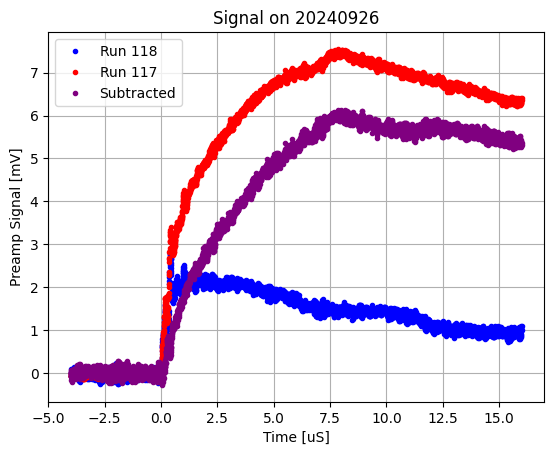

In [7]:
anodenorm118=np.average(DF118["average(Anode)"][:100])
cathnorm118 =np.average(DF118["average(Cathode)"][:100])


plt.errorbar(x=DF118["Time"][::stepcount],y=DF118["average(Anode)"][::stepcount] - anodenorm118, color= "blue", fmt=".",label="Run 118")

anodenorm117=np.average(DF117["average(Anode)"][:100])
cathnorm117= np.average(DF117["average(Cathode)"][:100])


plt.errorbar(x=DF117["Time"][::stepcount],y=DF117["average(Anode)"][::stepcount] - anodenorm117, color= "red", fmt=".",label="Run 117")

plt.errorbar(x=DF117["Time"][::stepcount],y=(DF117["average(Anode)"][::stepcount] - anodenorm117) -(DF118["average(Anode)"][::stepcount] - anodenorm118), color= "purple", fmt=".",label="Subtracted")



plt.xlabel("Time [uS]")
plt.ylabel("Preamp Signal [mV]")
plt.grid()
plt.legend()
plt.title("Signal on 20240926")
#plt.xlim(-1000,10000)

In [541]:
print()

TypeError: object of type 'Axes' has no len()

# Data analysis for LXe data from Sept 20th and 26th

0
(array([ 802, 1593, 2683, 3336, 4194, 4823], dtype=int64),)
[6.72399979]


Text(0.5, 0, 'Time [uS]')

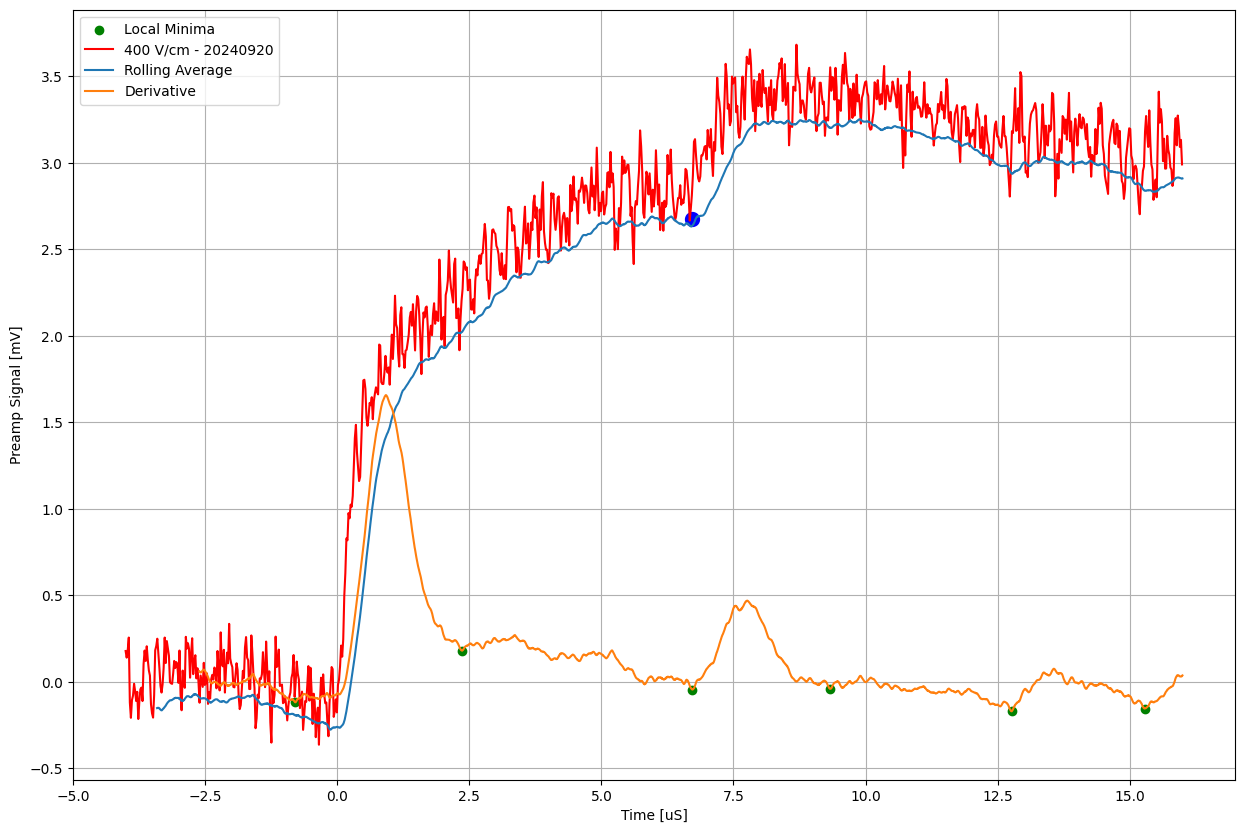

In [542]:

wafeform_path="C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/data/waveforms/" # Path for data On left pc

dates =     [20240920,20240920,20240920,20240926,20240926,20240926,20240926,20240926]
runnumbers= [112     ,114     ,115     ,116     ,117,119,120,121]
labels=[400,500,500,400,400,500,600,700]

c=["red","blue","magenta","cyan","brown","grey","skyblue","teal"]


anode_time_delay=[]

fig, axs = plt.subplots(1, 1,figsize=(15,10))

axs=[axs]


for i,rn  in enumerate(runnumbers[1:2]):
    print(i)
    waveform_date ="%i"%(dates[i])
    runnumber="00%i"%(rn)
    stepcount=5
    waveform_dir=wafeform_path+waveform_date+"/"+waveform_date+"-"+runnumber
    waveform_wavenumber="10"
    waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
    waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
    DF=pd.read_csv(waveform_fullpath,skiprows=[1])



    anodenorm=np.average(DF["average(Anode)"][:100])
    cathnorm=np.average(DF["average(Cathode)"][:100])


    axs
    axs[i].errorbar(x=DF["Time"][::stepcount],y=DF["average(Anode)"][::stepcount] - anodenorm, color= c[i], label="%i V/cm - %s"%(labels[i],waveform_date))
    #axs[1].errorbar(x=DF["Time"][::stepcount],y=DF["average(Cathode)"][::stepcount] - cathnorm, color= c[i], label="%i V/cm"%(labels[i]))

    stepsize=150
    diffsize=200

    xdata=np.array(DF["Time"])
    ydata=DF["average(Anode)"]-np.average(DF["average(Anode)"][:20])
    yrolling=ydata.rolling(stepsize).mean()
    yprime=np.array(yrolling.diff(diffsize))
    ydata_nparray=np.array(ydata)
    axs[i].errorbar(xdata,yrolling,label="Rolling Average")
    axs[i].errorbar(xdata,yprime,label="Derivative")


    local_minima_indices = argrelextrema(np.array(yprime), np.less,order=250)

    print(local_minima_indices)
    # Get the x and y values of the local minima
    x_minima = xdata[local_minima_indices]
    y_minima = yprime[local_minima_indices]
    axs[i].scatter(x_minima, y_minima, color='green', label='Local Minima', zorder=1)
    
    
    ydata_minima = ydata_nparray[local_minima_indices[0][0]]
    #axs[i].scatter(x_minima[1], ydata_minima, color=c[i])
    
    time_delay_ind=0
    time_delay=xdata[np.array(local_minima_indices)[0][0]]
    if time_delay <5:
        time_delay_ind=1
        time_delay=xdata[np.array(local_minima_indices)[0][time_delay_ind]]
        if time_delay <5:
            time_delay_ind=2
            time_delay=xdata[np.array(local_minima_indices)[0][time_delay_ind]]
    
    anode_time_delay.append(xdata[np.array(local_minima_indices)[0][time_delay_ind]])
    ydata_minima = ydata_nparray[local_minima_indices[0][time_delay_ind]]
    axs[i].scatter(x_minima[time_delay_ind], ydata_minima, color=c[i+1],marker="o",lw=5)



    axs[i].grid()
    axs[i].legend()
print(anode_time_delay)
#axs[0].set_xlabel("Time [uS]")
axs[0].set_ylabel("Preamp Signal [mV]")
#axs[0].grid()
axs[0].legend()

axs[0].set_xlabel("Time [uS]")
#axs[1].set_ylabel("Preamp Signal [mV]")
#axs[1].grid()
#axs[1].legend()

    #plt.title("Signal on 20240926")
#plt.xlim(-1000,10000)


##  Anode delay time extraction for runs 112     ,114     ,115     ,116     ,117,119,120,121

(array([2728, 3304, 4493, 4992], dtype=int64),)
Run 00112  - time Delay  6.90399979
(array([ 802, 1593, 2683, 4194, 4823], dtype=int64),)
Run 00114  - time Delay  6.72399979
(array([ 986, 1664, 2473, 3375, 4913], dtype=int64),)
Run 00115  - time Delay  5.88399981
(array([ 991, 2685, 3792, 4188], dtype=int64),)
Run 00116  - time Delay  6.73199979
(array([ 965, 2748, 3309, 3789, 4320, 4881], dtype=int64),)
Run 00117  - time Delay  6.98399978
(array([1006, 3400, 4897], dtype=int64),)
Run 00119  - time Delay  9.59399971
(array([1003, 2645, 3203, 4312], dtype=int64),)
Run 00120  - time Delay  6.5719998
(array([ 713, 3091, 3688, 4999], dtype=int64),)
Run 00121  - time Delay  8.35599975
[6.90399979, 6.72399979, 5.88399981, 6.73199979, 6.98399978, 9.59399971, 6.5719998, 8.35599975]


Text(0.5, 0, 'Time [uS]')

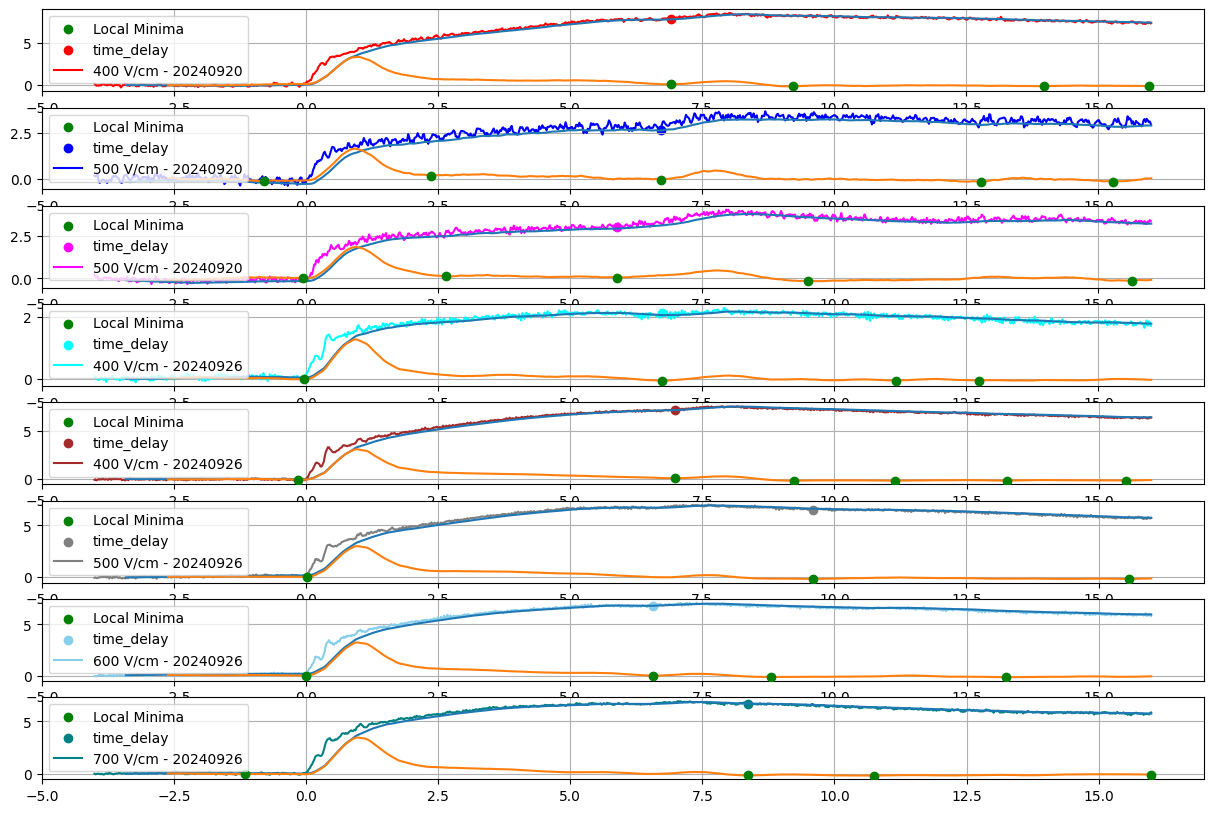

In [281]:

wafeform_path="C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/data/waveforms/" # Path for data On left pc

dates =     [20240920,20240920,20240920,20240926,20240926,20240926,20240926,20240926]
runnumbers= [112     ,114     ,115     ,116     ,117,119,120,121]
labels=[400,500,500,400,400,500,600,700]

c=["red","blue","magenta","cyan","brown","grey","skyblue","teal"]


anode_time_delay=[]

fig, axs = plt.subplots(len(runnumbers), 1,figsize=(15,10))


for i,rn  in enumerate(runnumbers):
    
    waveform_date ="%i"%(dates[i])
    runnumber="00%i"%(rn)
    stepcount=5
    waveform_dir=wafeform_path+waveform_date+"/"+waveform_date+"-"+runnumber
    waveform_wavenumber="10"
    waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
    waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
    DF=pd.read_csv(waveform_fullpath,skiprows=[1])



    anodenorm=np.average(DF["average(Anode)"][:100])
    cathnorm=np.average(DF["average(Cathode)"][:100])


    axs
    axs[i].errorbar(x=DF["Time"][::stepcount],y=DF["average(Anode)"][::stepcount] - anodenorm, color= c[i], label="%i V/cm - %s"%(labels[i],waveform_date))
    #axs[1].errorbar(x=DF["Time"][::stepcount],y=DF["average(Cathode)"][::stepcount] - cathnorm, color= c[i], label="%i V/cm"%(labels[i]))

    stepsize=150
    diffsize=200

    xdata=np.array(DF["Time"])
    ydata=DF["average(Anode)"]-np.average(DF["average(Anode)"][:20])
    yrolling=ydata.rolling(stepsize).mean()
    yprime=np.array(yrolling.diff(diffsize))
    ydata_nparray=np.array(ydata)
    axs[i].errorbar(xdata,yrolling)
    axs[i].errorbar(xdata,yprime)


    #local_minima_indices = argrelextrema(np.array(yprime), np.greater,order=350)
    local_minima_indices = argrelextrema(np.array(yprime), np.less,order=350)

    print(local_minima_indices)
    # Get the x and y values of the local minima
    x_minima = xdata[local_minima_indices]
    y_minima = yprime[local_minima_indices]
    axs[i].scatter(x_minima, y_minima, color='green', label='Local Minima', zorder=5)
    
    
    ydata_minima = ydata_nparray[local_minima_indices[0][0]]
    #axs[i].scatter(x_minima[1], ydata_minima, color=c[i])
    
    time_delay_ind=0
    time_delay=xdata[np.array(local_minima_indices)[0][0]]
    if time_delay <5:
        time_delay_ind=1
        time_delay=xdata[np.array(local_minima_indices)[0][time_delay_ind]]
        if time_delay <5:
            time_delay_ind=2
            time_delay=xdata[np.array(local_minima_indices)[0][time_delay_ind]]
    

    print("Run %s  - time Delay "%(runnumber) ,xdata[np.array(local_minima_indices)[0][time_delay_ind]],   )

    anode_time_delay.append(xdata[np.array(local_minima_indices)[0][time_delay_ind]])
    ydata_minima = ydata_nparray[local_minima_indices[0][time_delay_ind]]
    axs[i].scatter(x_minima[time_delay_ind], ydata_minima, color=c[i], label="time_delay")



    axs[i].grid()
    axs[i].legend()
print(anode_time_delay)
#axs[0].set_xlabel("Time [uS]")
#axs[0].set_ylabel("Preamp Signal [mV]")
#axs[0].grid()
axs[0].legend()

axs[3].set_xlabel("Time [uS]")
#axs[1].set_ylabel("Preamp Signal [mV]")
#axs[1].grid()
#axs[1].legend()

    #plt.title("Signal on 20240926")
#plt.xlim(-1000,10000)


##  Cathode delay time extraction for runs 112     ,114     ,115     ,116     ,117,119,120,121

1.08399995
-19.186422299999997
1.17199995
-10.276239169999998
1.22799995
-11.034281299999998
0.97199995
-6.062645800000009
0.96799995
-15.674215500000003
1.00199995
-17.529075099999996
0.96399995
-19.765023
0.94399995
-27.445324299999996


Text(0.5, 0, 'Time [uS]')

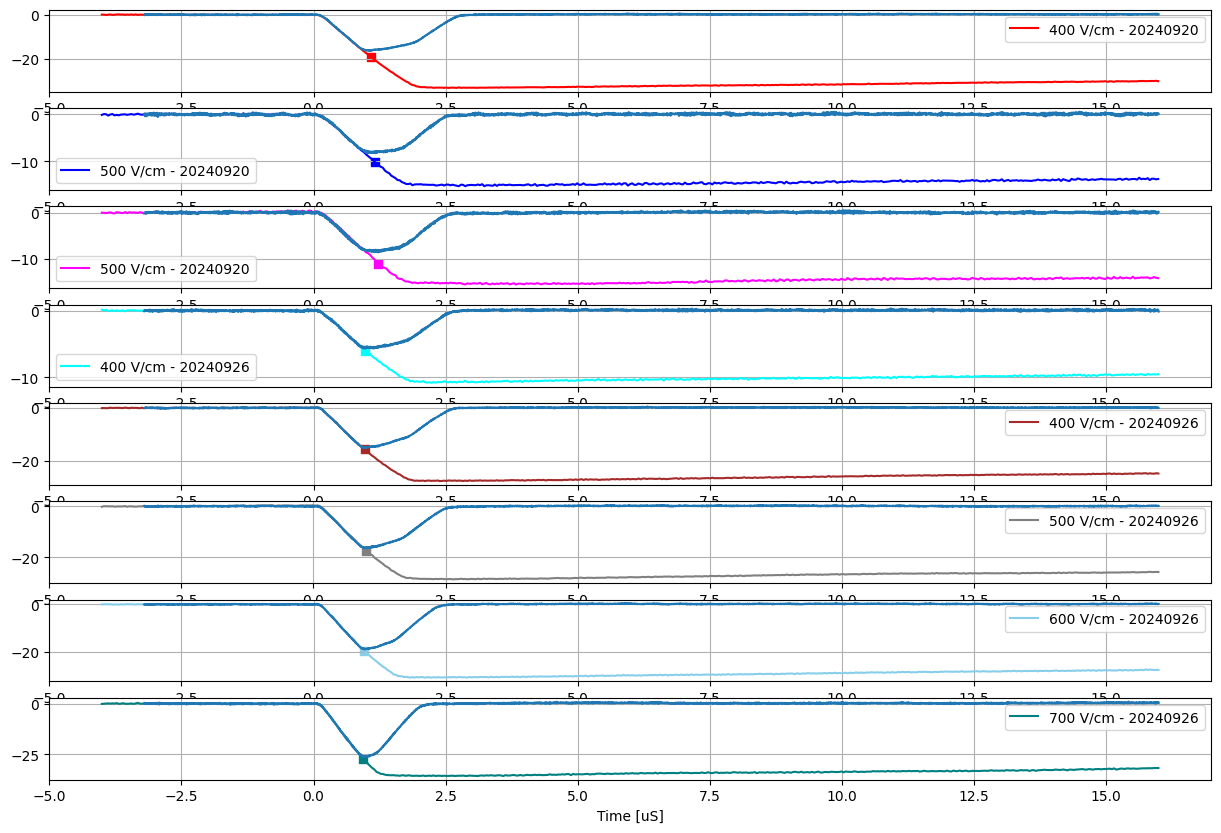

In [277]:
wafeform_path="C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/data/waveforms/" # Path for data On left pc

# dates = [20240926,20240926,20240926,20240926]
# runnumbers= [117,119,120,121]

# voltages_raw= np.array([400,500,600,700])
voltages_raw=labels
#c=["red","blue","magenta","cyan"]





fig, axs = plt.subplots(len(runnumbers), 1,figsize=(15,10))

catho_delay=[]
for i,rn  in enumerate(runnumbers):
    
    waveform_date ="%i"%(dates[i])
    runnumber="00%i"%(rn)
    stepcount=10
    waveform_dir=wafeform_path+waveform_date+"/"+waveform_date+"-"+runnumber
    waveform_wavenumber="10"
    waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
    waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
    DF=pd.read_csv(waveform_fullpath,skiprows=[1])



    anodenorm=np.average(DF["average(Anode)"][:100])
    cathnorm=np.average(DF["average(Cathode)"][:100])


    axs
    #axs[i].errorbar(x=DF["Time"][::stepcount],y=DF["average(Anode)"][::stepcount] - anodenorm, color= c[i], label="%i V/cm"%(labels[i]))
    axs[i].errorbar(x=DF["Time"][::stepcount],y=DF["average(Cathode)"][::stepcount] - cathnorm, color= c[i], label="%i V/cm - %s"%(labels[i],waveform_date))
    
    axs[i].grid()

    axs[i].legend()

    Time=np.array(DF["Time"])
    Cath =DF["average(Cathode)"] - cathnorm
    diff = Cath.diff(200)

    axs[i].errorbar(Time,diff,label="Diff")


    cond= np.abs(diff)== np.max(np.abs(diff))
    #cond= np.abs(diff)>=1


    print(Time[np.where(cond)][-1])
    cd=Time[np.where(cond)][-1]
    cd_amp=np.array(Cath.iloc[np.where(cond)])[-1]
    catho_delay.append(cd)
    print(cd_amp)

    axs[i].scatter(cd,cd_amp,marker="s",color=c[i])
    #catho_delay.append(Time[np.where(Cath == Cath_min)][0])
    #axs[i].set_xlim(-1,3)

axs[i].set_xlabel("Time [uS]")
#print(catho_delay)


#axs[i].set_ylim(-37,-28)
#axs[i].set_xlim(-1,3)

2.7159999
-33.2136333


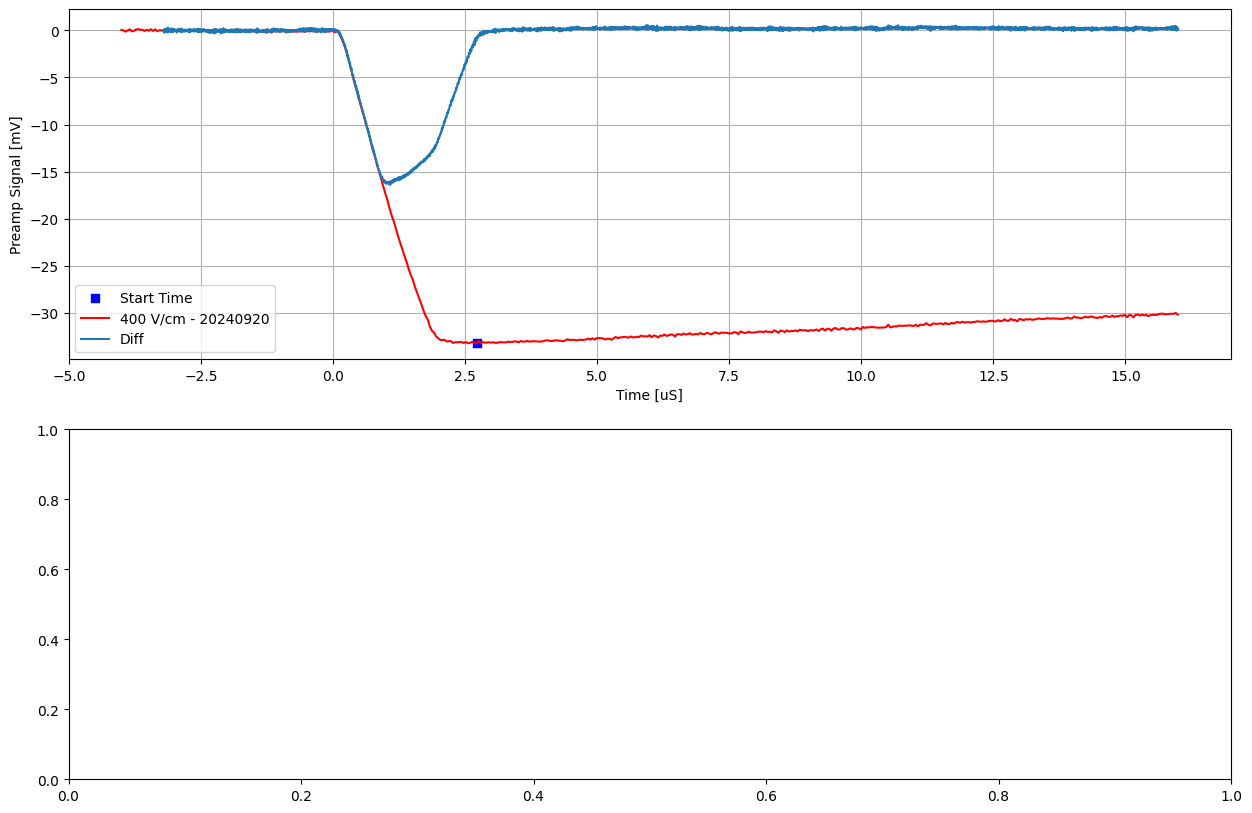

In [255]:
wafeform_path="C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/data/waveforms/" # Path for data On left pc

# dates = [20240926,20240926,20240926,20240926]
# runnumbers= [117,119,120,121]

# voltages_raw= np.array([400,500,600,700])
voltages_raw=labels
#c=["red","blue","magenta","cyan"]





fig, axs = plt.subplots(2, 1,figsize=(15,10))

catho_delay=[]
for i,rn  in enumerate(runnumbers[:1]):
    
    waveform_date ="%i"%(dates[i])
    runnumber="00%i"%(rn)
    stepcount=10
    waveform_dir=wafeform_path+waveform_date+"/"+waveform_date+"-"+runnumber
    waveform_wavenumber="10"
    waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
    waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
    DF=pd.read_csv(waveform_fullpath,skiprows=[1])



    anodenorm=np.average(DF["average(Anode)"][:100])
    cathnorm=np.average(DF["average(Cathode)"][:100])


    axs
    #axs[i].errorbar(x=DF["Time"][::stepcount],y=DF["average(Anode)"][::stepcount] - anodenorm, color= c[i], label="%i V/cm"%(labels[i]))
    axs[i].errorbar(x=DF["Time"][::stepcount],y=DF["average(Cathode)"][::stepcount] - cathnorm, color= c[i], label="%i V/cm - %s"%(labels[i],waveform_date))
    
    axs[i].grid()

    axs[i].legend()

    Time=np.array(DF["Time"])
    Cath =DF["average(Cathode)"] - cathnorm
    diff = Cath.diff(200)

    axs[i].errorbar(Time,diff,label="Diff")


    #cond= np.abs(diff) == np.max(np.abs(diff))
    cond= np.abs(diff) >1


    
    cd=Time[np.where(cond)][-1]
    cd_amp=np.array(Cath.iloc[np.where(cond)])[-1]
    print(cd)
    catho_delay.append(cd)
    print(cd_amp)

    axs[i].scatter(cd,cd_amp,marker="s",color=c[i+1],label="Start Time")
    #catho_delay.append(Time[np.where(Cath == Cath_min)][0])
    #axs[i].set_xlim(-1,3)

axs[i].set_xlabel("Time [uS]")
axs[i].set_ylabel("Preamp Signal [mV]")
axs[i].legend()
#print(catho_delay)


#axs[i].set_ylim(-37,-28)
#axs[i].set_xlim(-1,3)

## Error analysis

In [87]:


drift_length_stddev = 0.12
drift_length=9.14


dl_per_error=drift_length_stddev/drift_length



voltage_uncertainty = 5*2
volt_per_error=np.array(voltage_uncertainty)/voltages_raw


drift_field_pre_error = np.sqrt( volt_per_error**2 + dl_per_error**2 )
drift_field_error=drift_field_pre_error*voltages_raw

In [88]:
np.round((np.array(anode_time_delay)-catho_delay),3)

array([6.044, 5.648, 5.516, 5.344])

In [89]:
drift_time_LXe_Sept=np.array([5.224, 5.348, 5.364, 5.564, 5.336, 5.116, 5.044, 5.3])
#drift_time_main=np.array([5.068, 5.136, 5.164, 5.524, 5.228,5.08, 5.008, 5.212])

drift_time_2nd =np.array([4.79999986, 4.71199986, 4.65599986, 4.91199986, 4.91599986,
       4.88199986, 4.91999986, 4.93999986])

delta_v_1 = abs(drift_length/drift_time_LXe_Sept - drift_length/drift_time_2nd)

print(delta_v_1)





[0.15454957 0.2306783  0.2591062  0.21804615 0.14634165 0.08563159
 0.0456697  0.12567418]


## Phys. Rev. 166, 871 - data

In [47]:
ChT_Vs=np.array([41.368,128.825, 194.984, 395.063, 579.874, 794.328])

ChT_dv= np.array([0.763 ,1.416, 1.59, 1.813, 1.899, 2.052])


## J. Yoo and W.F. Jaskierny 2015 JINST 10 P08011    --Data

In [46]:
ChT_Vs=np.array([41.368,128.825, 194.984, 395.063, 579.874, 794.328])

ChT_dv= np.array([0.763 ,1.416, 1.59, 1.813, 1.899, 2.052])

AAA = [200, 0.148 , 0.003, 0.181 , 0.003, 1.22,
250, 0.157 , 0.004, 0.200 , 0.004, 1.27,
300, 0.162 , 0.003, 0.227 , 0.004, 1.40,
350, 0.166 , 0.003, 0.245 , 0.005, 1.48,
400, 0.167 , 0.003, 0.255 , 0.004, 1.53,
450, 0.174 , 0.004, 0.266 , 0.004, 1.53,
500, 0.177 , 0.003, 0.274 , 0.004, 1.55,
550, 0.180 , 0.004, 0.288 , 0.005, 1.60,
600, 0.184 , 0.003, 0.302 , 0.006, 1.64,
650, 0.186 , 0.003, 0.325 , 0.006, 1.74,
700, 0.189 , 0.006, 0.343 , 0.005, 1.82,
750, 0.191 , 0.003, 0.357 , 0.005, 1.87,
800, 0.193 , 0.003, 0.382 , 0.007, 1.98,
850, 0.194 , 0.003, 0.390 , 0.007, 2.01,
900, 0.193 , 0.003, 0.397 , 0.006, 2.05]


JINST_2015_dict={}

vs=[]
lds=[]
lds_e=[]
for i in np.arange(0,15,1):
    vs.append(AAA[i*6])
    lds.append(AAA[i*6+1]*10)
    lds_e.append(AAA[i*6+2])
JINST_2015_dict["Voltage"]=vs
JINST_2015_dict["DriftSpeed"]=lds
JINST_2015_dict["Error"]=lds_e




## Drift veloctity plot for njoya, Sept 20th, and 26th

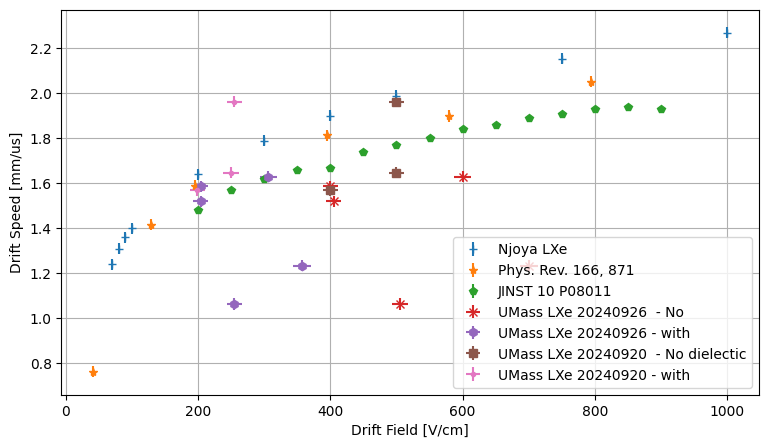

In [286]:
fig,ax= plt.subplots(1, 1, figsize=(9,5))


#print(bx)
colors=["r","blue","darkgrey","green","cyan","purple"]
marker=["o","x","p","s","h","*"]
markersize=7

sec=0

##Njoya liquid data
#njoya_y1=np.array([20,20/1.1,20/1.3,20/1.4,20/1.5,20/1.7])-1
#njoya_y2=np.array([20,20/1.1,20/1.3,20/1.4,20/1.5,20/1.7])+1
njyl=np.array([1.24,1.31,1.36,1.4,1.64,1.79,1.9,1.99,2.154,2.2685])
njxl=np.array([70,80,90,100,200,300,400,500,750,1000])
#njoya_x=[200*2,200*2,300*2,400*2,500*2,1000*2]

njoya_x=njxl
njoya_y=njyl

ax.errorbar(x=njoya_x,y=njoya_y,yerr=0.025,fmt=" ",marker="+",label="Njoya LXe")
ax.errorbar(x=ChT_Vs,y=ChT_dv,yerr=0.025,fmt=" ", marker="*",label="Phys. Rev. 166, 871 ")

ax.errorbar(x= JINST_2015_dict["Voltage"],y=JINST_2015_dict["DriftSpeed"],fmt=" ",marker="p",
            yerr=JINST_2015_dict["Error"],label="JINST 10 P08011 ")




voltages_raw=np.array(labels)


offset=[-5,-5,0,0,5,5,0,0]

ax.errorbar(x=voltages_raw[3:]+offset[3:],y=9.14/(np.array(anode_time_delay)-catho_delay)[3:]
            ,xerr=drift_field_error[3:]
            ,yerr=0.025,fmt=" ",marker="x",label="UMass LXe 20240926  - No ")
ax.errorbar(x=voltages_raw[3:]/1.96,y=9.14/(np.array(anode_time_delay)-catho_delay)[3:]
            ,xerr=drift_field_error[3:]
            ,yerr=0.025,fmt=" ",marker="h",label="UMass LXe 20240926 - with")

ax.errorbar(x=voltages_raw[:3],y=9.14/(np.array(anode_time_delay)-catho_delay)[:3]
            ,xerr=drift_field_error[:3]
            ,yerr=0.025,fmt=" ",marker="s",label="UMass LXe 20240920  - No dielectic")
ax.errorbar(x=voltages_raw[:3]/1.96 +offset[:3],y=9.14/(np.array(anode_time_delay)-catho_delay)[:3]
            ,xerr=drift_field_error[:3]
            ,yerr=0.025,fmt=" ",marker=".",label="UMass LXe 20240920 - with")


ax.set_ylabel("Drift Speed [mm/us]")
ax.set_xlabel("Drift Field [V/cm]")


ax.grid()
ax.legend()


In [102]:
#drift_time_main=np.array([5.068, 5.136, 5.164, 5.524, 5.228,5.08, 5.008, 5.212])

In [90]:
voltages_raw

array([400, 500, 500, 400, 400, 500, 600, 700])

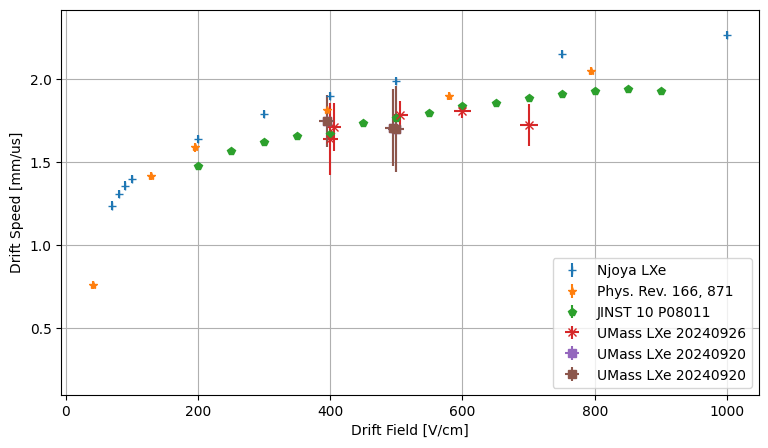

In [140]:
fig,ax= plt.subplots(1, 1, figsize=(9,5))


#print(bx)
colors=["r","blue","darkgrey","green","cyan","purple"]
marker=["o","x","p","s","h","*"]
markersize=7

sec=0

##Njoya liquid data
#njoya_y1=np.array([20,20/1.1,20/1.3,20/1.4,20/1.5,20/1.7])-1
#njoya_y2=np.array([20,20/1.1,20/1.3,20/1.4,20/1.5,20/1.7])+1
njyl=np.array([1.24,1.31,1.36,1.4,1.64,1.79,1.9,1.99,2.154,2.2685])
njxl=np.array([70,80,90,100,200,300,400,500,750,1000])
#njoya_x=[200*2,200*2,300*2,400*2,500*2,1000*2]

njoya_x=njxl
njoya_y=njyl


ax.errorbar(x=njoya_x,y=njoya_y,yerr=0.025,fmt=" ",marker="+",label="Njoya LXe")

ax.errorbar(x=ChT_Vs,y=ChT_dv,yerr=0.025,fmt=" ", marker="*",label="Phys. Rev. 166, 871 ")

ax.errorbar(x= JINST_2015_dict["Voltage"],y=JINST_2015_dict["DriftSpeed"],fmt=" ",marker="p",
            yerr=JINST_2015_dict["Error"],label="JINST 10 P08011 ")



voltages_raw=np.array(labels)

offset=[-5,-5,0,0,5,5,0,0]


ax.errorbar(x=voltages_raw[3:]+offset[3:],y=9.14/drift_time_LXe_Sept[3:]
            ,xerr=drift_field_error[3:]
           ,yerr=delta_v_1[3:],fmt=" ",marker="x",label="UMass LXe 20240926")
ax.errorbar(x=voltages_raw[:3] +offset[:3],y=9.14/drift_time_LXe_Sept[:3]
           ,xerr=drift_field_error[:3]
           ,yerr=delta_v_1[:3],fmt=" ",marker="s",label="UMass LXe 20240920")
# ax.errorbar(x=voltages_raw[3:]/1.96 +offset[3:],y=9.14/drift_time_main[3:]
#             ,xerr=drift_field_error[3:]
#             ,yerr=delta_v_1[3:],fmt=" ",marker="x",label="UMass LXe 20240926 ")

ax.errorbar(x=voltages_raw[:3] +offset[:3],y=9.14/drift_time_LXe_Sept[:3]
           ,xerr=drift_field_error[:3]
           ,yerr=delta_v_1[:3],fmt=" ",marker="s",label="UMass LXe 20240920")
# ax.errorbar(x=voltages_raw[:3]/1.96 +offset[:3],y=9.14/drift_time_main[:3]
#             ,xerr=drift_field_error[:3]
#             ,yerr=delta_v_1[:3],fmt=" ",marker=".",label="UMass LXe 20240920")





ax.set_ylabel("Drift Speed [mm/us]")
ax.set_xlabel("Drift Field [V/cm]")


ax.set_ylim(0.1,2.42)
ax.grid()
ax.legend()

# Playing around with background modeling

In [29]:
DF[:1]

Time  Channel Trigger  Channel Cathode  Channel Anode  Channel UV  \
0 -4.008              0.0         55.56409       23.68971         0.0   

   average(Cathode)  average(Anode)  
0          51.41853        21.55292

4.336202200000001
[1264]
(array([ 420, 1264, 2816, 4812], dtype=int64),)
1.04799995
Err func fit par
[3.15164567 3.14885332 0.89079997 0.86589952] 
 [[ 4.46207765e-05 -2.73048256e-05 -2.49176512e-05 -3.62776229e-05]
 [-2.73048256e-05  4.24026245e-05  3.10044075e-05  2.49198199e-05]
 [-2.49176512e-05  3.10044075e-05  1.24837064e-04  8.54133514e-05]
 [-3.62776229e-05  2.49198199e-05  8.54133514e-05  1.71548815e-04]]
[7.84998283e-78 1.85256703e-77 3.30402006e-77 ... 5.62294698e+00
 5.62294698e+00 5.62294698e+00]
[0 0 0 ... 0 0 0]


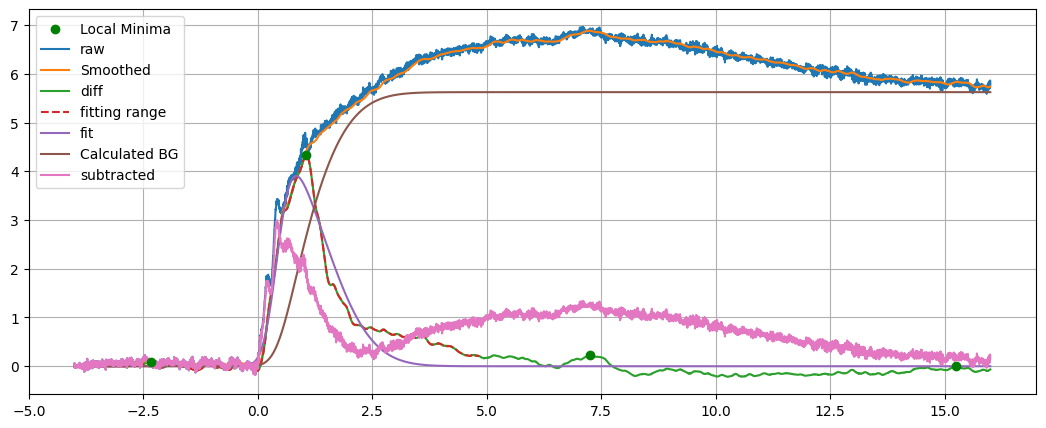

In [292]:
stepsize=50
diffsize=250

xdata=np.array(DF["Time"])
ydata=DF["average(Anode)"]-np.average(DF["average(Anode)"][:20])
yrolling=ydata.rolling(stepsize).mean()
yprime=np.array(yrolling.diff(diffsize))
yprime = np.nan_to_num(yprime,nan=0)

Fpeak_amp=np.max(yprime)

cond= yprime ==Fpeak_amp

print(Fpeak_amp)


#print(yprime.where("=%d"%(Fpeak_amp)))
Fpeak_loc=np.where( np.abs(yprime - Fpeak_amp) <=0.0001)[0]
print(Fpeak_loc)



x_fit_data=xdata[:int(Fpeak_loc[0]*1.750)]
y_fit_data=yprime[:int(Fpeak_loc[0]*1.750)]


fig = plt.figure(figsize=(13,5))
plt.errorbar(xdata,ydata, label="raw")
plt.errorbar(xdata,yrolling,label= "Smoothed")
plt.errorbar(xdata,yprime,label="diff")
plt.errorbar(x_fit_data,y_fit_data, fmt="--", label="fitting range")




local_minima_indices = argrelextrema(np.array(yprime), np.greater,order=350)
x_minima = xdata[local_minima_indices]
y_minima = yprime[local_minima_indices]
plt.scatter(x_minima, y_minima, color='green', label='Local Minima', zorder=5)

print(local_minima_indices)
second_peak_ind=local_minima_indices[0][1]
second_peak_time=xdata[second_peak_ind]
print(second_peak_time)



errguas_FR=np.concatenate([np.where(xdata <=-0.1)[0] , np.where( xdata > second_peak_time )[0]])


#ydata_err = ydata[errguas_FR]
errguass_guess=[np.max(ydata),np.min(ydata),second_peak_time,-0.5]
errguass_p_range=[ [-10,-10,second_peak_time*0.85,-2],[10,10,second_peak_time*1.25,2]]

params_err, cov_err = curve_fit(errfunc, xdata[errguas_FR], ydata[errguas_FR], p0=errguass_guess,bounds=errguass_p_range)
print("Err func fit par")
print(params_err,"\n",cov_err)
#plt.errorbar(xdata[errguas_FR], ydata[errguas_FR],fmt=" .", label="err fitrange")

yfit_err=errfunc(xdata, params_err[0],params_err[1],params_err[2],params_err[3])

#plt.errorbar(xdata,yfit_err,label="Errfunc")

# plt.errorbar(xdata,subtracted)

# # Fit the data using curve_fit
# initial_guess = [Fpeak_amp, xdata[Fpeak_loc][0], 2]  # Initial guess for a, mu, sigma
# print(initial_guess)
# params, covariance = curve_fit(gaussian, x_fit_data, y_fit_data, p0=initial_guess)
# # Extract the fitting parameters
# a_fit, mu_fit, sigma_fit = params
# # Generate the fitted Gaussian curve
# y_fit = gaussian(xdata, a_fit, mu_fit, sigma_fit)

# p0=[Fpeak_amp, xdata[Fpeak_loc][0], 2,0,-1]

# params, covariance = curve_fit(dg, x_fit_data, y_fit_data)
# # Extract the fitting parameters
# a, mu_a, sigma_a ,b,m = params
# # Generate the fitted Gaussian curve
# y_fit = dg(xdata, a, mu_a, sigma_a ,b,m )

# print(params)
# Initial guesses for the fitting parameters
initial_guess = [5, 0, 2, 8]  # Initial guess for alpha, mu, sigma, amplitude

# Fit the data
popt, pcov = curve_fit(skewed_gaussian, x_fit_data, y_fit_data, p0=initial_guess)

# Extract the optimal parameters
alpha_opt, mu_opt, sigma_opt, amplitude_opt = popt

# Generate fitted y values with the optimized parameters
y_fit = skewed_gaussian(xdata, alpha_opt, mu_opt, sigma_opt, amplitude_opt)



plt.errorbar(xdata,y_fit,label="fit")

Fpeak_int=np.cumsum(y_fit* (xdata[1]-xdata[0]))

Fpeak_valid=np.where(np.diff(Fpeak_int,50) > .005,1,0)
print(Fpeak_int)
print(Fpeak_valid)

subtracted = ydata-Fpeak_int


dsub=ydata-subtracted
plt.errorbar(xdata,Fpeak_int,label="Calculated BG")
plt.errorbar(xdata,subtracted,label="subtracted")



#plt.ylim(-0.1,8)
#plt.xlim(-2.15,15)
plt.legend()

plt.grid()

array([   0,    1,    2, ..., 5000, 5001, 5002], dtype=int64)

In [339]:
from lmfit.models import SkewedGaussianModel

In [45]:
xdata[2250:2500]

2250    4.992
2251    4.996
2252    5.000
2253    5.004
2254    5.008
        ...  
2495    5.972
2496    5.976
2497    5.980
2498    5.984
2499    5.988
Name: Time, Length: 250, dtype: float64

['A:/DATA/waveforms/20240926-00119\\20240926-000119_01.csv', 'A:/DATA/waveforms/20240926-00119\\20240926-000119_02.csv', 'A:/DATA/waveforms/20240926-00119\\20240926-000119_03.csv', 'A:/DATA/waveforms/20240926-00119\\20240926-000119_04.csv', 'A:/DATA/waveforms/20240926-00119\\20240926-000119_05.csv', 'A:/DATA/waveforms/20240926-00119\\20240926-000119_06.csv', 'A:/DATA/waveforms/20240926-00119\\20240926-000119_07.csv', 'A:/DATA/waveforms/20240926-00119\\20240926-000119_08.csv', 'A:/DATA/waveforms/20240926-00119\\20240926-000119_09.csv', 'A:/DATA/waveforms/20240926-00119\\20240926-000119_10.csv', 'A:/DATA/waveforms/20240926-00119\\20240926-000119_11.csv']
A:/DATA/waveforms/20240926-00119/20240926-000119_01.csv 
 A:/DATA/waveforms/20240926-00119/20240926-00119_01.csv


FileNotFoundError: [WinError 2] The system cannot find the file specified

In [31]:
r=21.5
d=803
rho = 2* np.pi *r/d


Rmin = (1+rho)/(1-rho)
Rmin,rho

(1.4045101211444562, 0.16822974359198145)

In [60]:
r=37/2
d=217
rho = 2* np.pi *r/d


Rmin = (1+rho)/(1-rho)
Rmin

3.3072189703128196

In [41]:
( + (d/(4 *np.pi *1.8 ))* (rho**2 - 4* np.log(rho) ) )

254.1118254637591

In [47]:
(220/1.8) / (366/9.14)

3.0522161505768066

In [61]:
Eq_2_Num=(1 + (d/(4 *np.pi *1.8 ))* (rho**2 - 4* np.log(rho) ) )*(1+rho)
Eq_2_den=(1 + (d/(4 *np.pi *9.14))* (rho**2 - 4* np.log(rho) ) )*(1+rho)


Eq_2_Num/Eq_2_den


4.426346291708176

# 20241007 data

## Gas data runs 137,138,139

500.0
(array([  796,  2160,  2722,  4742,  6241,  6996,  9055,  9985, 11231,
       11808, 12274], dtype=int64),)
Run 00137  - time Delay  8.9599998
2.17599999
-60.45843909999999
400.43763676148797
(array([ 1200,  1654,  2726,  4852,  6844,  7551,  8175,  8889, 10488,
       11924], dtype=int64),)
Run 00138  - time Delay  9.40239979
2.34639999
-52.19277890000001
299.781181619256
(array([ 1337,  2722,  4968,  6101,  7719,  8899, 10415, 10851, 12275],
      dtype=int64),)
Run 00139  - time Delay  9.86599978
2.43799999
-43.09558009999999
cath
[2.17599999, 2.34639999, 2.43799999]
anode
[8.9599998, 9.40239979, 9.86599978]
Drift time
[6.78399981 7.0559998  7.42799979]
[500.0, 400.43763676148797, 299.781181619256]


Text(0.5, 0, 'Time [uS]')

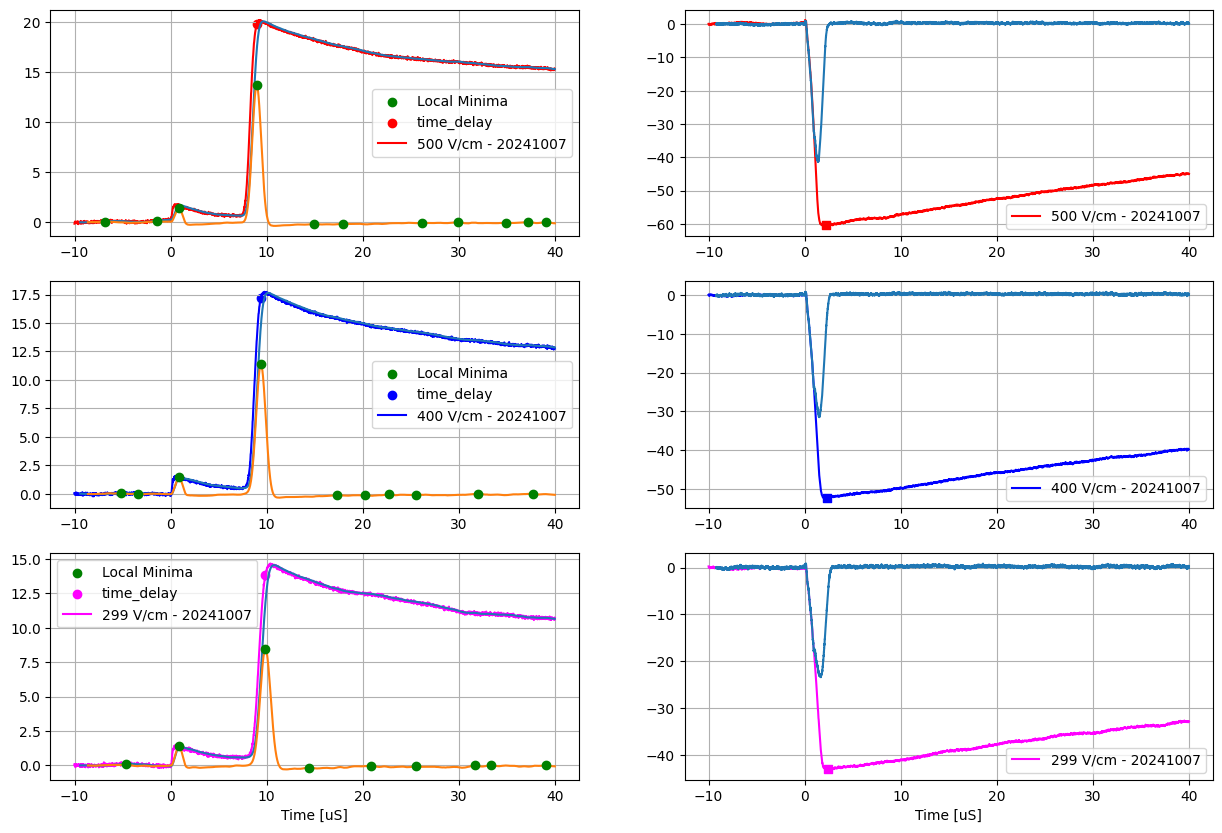

In [223]:

wafeform_path="C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/data/waveforms/" # Path for data On left pc

dates =     [20241007,20241007,20241007]
runnumbers= [137     ,138     ,139]
labels=[400,500,500,400,400,500,600,700]

c=["red","blue","magenta","cyan","brown","grey","skyblue","teal"]

chann_names=["Avg Cathode","Avg Anode"]

anode_time_delay=[]
catho_delay=[]
drift_field_list=[]
fig, axs = plt.subplots(len(runnumbers), 2,figsize=(15,10))


for i,rn  in enumerate(runnumbers):
    
    waveform_date ="%i"%(dates[i])
    runnumber="00%i"%(rn)
    stepcount=5
    waveform_dir=wafeform_path+waveform_date+"/"+waveform_date+"-"+runnumber
    waveform_wavenumber="10"
    waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
    waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
    DF=pd.read_csv(waveform_fullpath,skiprows=[1])
    RI = GetRunInfo(rn)

    drift_field = RI["Cathode Grid V."].iloc[0]/(9.14/10)
    print(drift_field)

    anodenorm=np.average(DF[chann_names[1]][:100])
    cathnorm=np.average(DF[chann_names[0]][:100])


    axs
    axs[i][0].errorbar(x=DF["Time"][::stepcount],y=DF[chann_names[1]][::stepcount] - anodenorm, color= c[i], label="%i V/cm - %s"%(drift_field,waveform_date))
    #axs[1].errorbar(x=DF["Time"][::stepcount],y=DF["average(Cathode)"][::stepcount] - cathnorm, color= c[i], label="%i V/cm"%(labels[i]))

    stepsize=150
    diffsize=200

    xdata=np.array(DF["Time"])
    ydata=DF[chann_names[1]]-np.average(DF[chann_names[1]][:20])
    yrolling=ydata.rolling(stepsize).mean()
    yprime=np.array(yrolling.diff(diffsize))
    ydata_nparray=np.array(ydata)
    axs[i][0].errorbar(xdata,yrolling)
    axs[i][0].errorbar(xdata,yprime)


    local_minima_indices = argrelextrema(np.array(yprime), np.greater,order=350)
    #local_minima_indices = argrelextrema(np.array(yprime), np.less,order=350)

    print(local_minima_indices)
    # Get the x and y values of the local minima
    x_minima = xdata[local_minima_indices]
    y_minima = yprime[local_minima_indices]
    axs[i][0].scatter(x_minima, y_minima, color='green', label='Local Minima', zorder=5)
    
    
    ydata_minima = ydata_nparray[local_minima_indices[0][0]]
    #axs[i].scatter(x_minima[1], ydata_minima, color=c[i])
    
    time_delay_ind=0
    time_delay=xdata[np.array(local_minima_indices)[0][0]]
    while time_delay <3 :
        time_delay_ind=1 +time_delay_ind
        time_delay=xdata[np.array(local_minima_indices)[0][time_delay_ind]]
        if time_delay_ind > len(np.array(local_minima_indices)[0]) -1:
            print("Breaking out of while loop")
            break
        

    print("Run %s  - time Delay "%(runnumber) ,xdata[np.array(local_minima_indices)[0][time_delay_ind]],   )

    anode_time_delay.append(xdata[np.array(local_minima_indices)[0][time_delay_ind]])
    ydata_minima = ydata_nparray[local_minima_indices[0][time_delay_ind]]
    axs[i][0].scatter(x_minima[time_delay_ind], ydata_minima, color=c[i], label="time_delay")



    axs[i][0].grid()
    axs[i][0].legend()

##cathods

    axs[i][1].errorbar(x=DF["Time"][::stepcount],y=DF[chann_names[0]][::stepcount] - cathnorm, color= c[i], label="%i V/cm - %s"%(drift_field,waveform_date))
    axs[i][1].grid()
    axs[i][1].legend()

    Time=np.array(DF["Time"])
    Cath =DF[chann_names[0]] - cathnorm
    diff = Cath.diff(200)

    axs[i][1].errorbar(Time,diff,label="Diff")


    #cond= np.abs(diff)== np.max(np.abs(diff))
    cond= np.abs(diff)>=5


    print(Time[np.where(cond)][-1])
    cd=Time[np.where(cond)][-1]
    cd_amp=np.array(Cath.iloc[np.where(cond)])[-1]
    catho_delay.append(cd)
    print(cd_amp)

    axs[i][1].scatter(cd,cd_amp,marker="s",color=c[i])
    #catho_delay.append(Time[np.where(Cath == Cath_min)][0])
    #axs[i].set_xlim(-1,3)
    drift_field_list.append(drift_field)
axs[i][1].set_xlabel("Time [uS]")




print("cath")
print(catho_delay)
print("anode")
print(anode_time_delay)

Drift_time=np.array(anode_time_delay)-np.array(catho_delay)

print("Drift time")
print(Drift_time)
print(drift_field_list)


    

#axs[0].set_xlabel("Time [uS]")
#axs[0].set_ylabel("Preamp Signal [mV]")
#axs[0].grid()
axs[0][0].legend()


axs[i][0].set_xlabel("Time [uS]")
#axs[1].set_ylabel("Preamp Signal [mV]")
#axs[1].grid()
#axs[1].legend()

    #plt.title("Signal on 20240926")
#plt.xlim(-1000,10000)


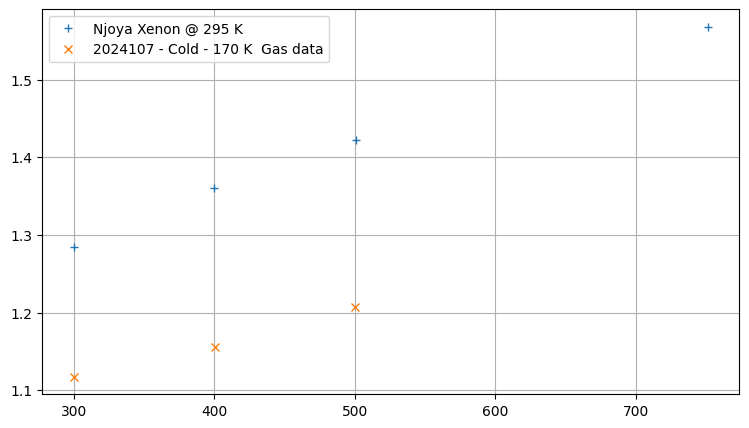

In [103]:
Runlist_DF["Extraction Distance"] = 1.83
Runlist_DF["Collection Distance"] = 1.83
Runlist_DF["Drift Distance"] = 9.185
Runlist_DF["Drift Distance Error"] = 0.15


# LXe data runs 143-147

Run 00143   Field 599.562363  time Delay  8.05799983
2.046
-60.208840499999994
0
Run 00144   Field 700.218818  time Delay  7.73149984
2.0835
-185.061368
1
Run 00145   Field 799.781182  time Delay  7.55679984
2.0408
-202.3755627
2
Run 00146   Field 900.000000  time Delay  7.36079985
2.0168
-210.6503851
3
cath
[2.046, 2.0835, 2.0408, 2.0168]
anode
[8.05799983, 7.73149984, 7.55679984, 7.36079985]
Drift time
[6.01199983 5.64799984 5.51599984 5.34399985]
[599.562363238512, 700.218818380744, 799.781181619256, 900.0]


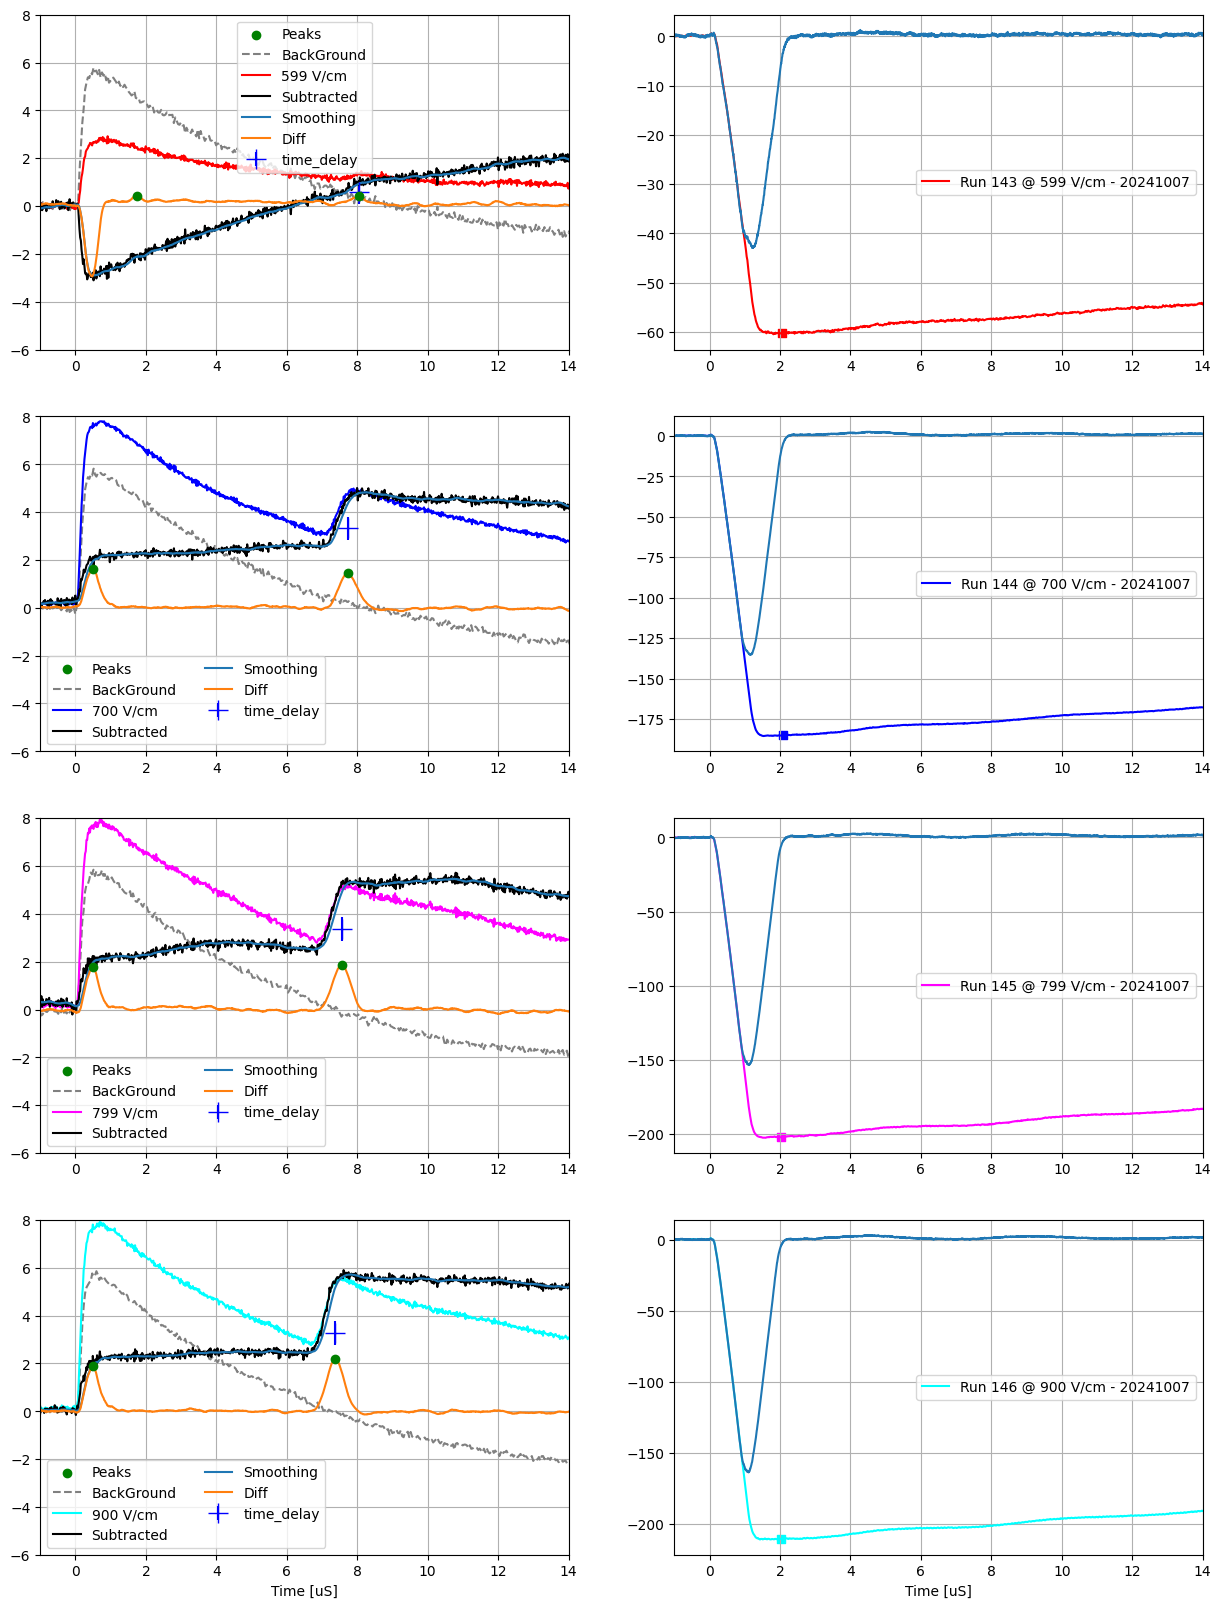

In [370]:

wafeform_path="C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/data/waveforms/" # Path for data On left pc

dates =     [20241007,20241007,20241007]
runnumbers= [143     ,144  ,145, 146,]#147]
bg_runs = [160,159,158,157]
labels=[400,500,500,400,400,500,600,700]
bg_runs = [160,159,158,157]
c=["red","blue","magenta","cyan","brown","grey","skyblue","teal"]

chann_names=["Avg Cathode","Avg Anode"]

anode_time_delay=[]
catho_delay=[]
drift_field_list=[]
fig, axs = plt.subplots(len(runnumbers), 2,figsize=(15,20))


for i,rn  in enumerate(runnumbers):
    
    RI = GetRunInfo(rn)
    
    waveform_date ="%i"%(RI["Date"].iloc[0])
    runnumber="00%i"%(rn)
    stepcount=5
    waveform_dir=wafeform_path+waveform_date+"/"+waveform_date+"-"+runnumber
    waveform_wavenumber="10"
    waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
    waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
    DF=pd.read_csv(waveform_fullpath,skiprows=[1])
    


    ###Background

    bg_runnumber="00%i"%(bg_runs[i])
    BG_dir =wafeform_path +waveform_date+"/"+waveform_date+"-"+bg_runnumber
    bg_filename=waveform_date+"-"+bg_runnumber+"_"+waveform_wavenumber
    bg_fullpath= BG_dir + "/"+bg_filename + ".csv"
    bgDF=pd.read_csv(bg_fullpath,skiprows=[1])
    bg_anodenorm=np.average(bgDF[chann_names[1]][:100])
    ####



    drift_field = RI["Cathode Grid V."].iloc[0]/(9.14/10)
    #print(drift_field)

    anodenorm=np.average(DF[chann_names[1]][:100])
    cathnorm=np.average(DF[chann_names[0]][:100])

    bg_norm=1# np.max(DF[chann_names[1]][::stepcount] - anodenorm) / np.max(bgDF[chann_names[1]][::stepcount*2] - bg_anodenorm)



    bg_y=(bgDF[chann_names[1]]- bg_anodenorm)*bg_norm


    sub = (DF[chann_names[1]] - anodenorm) - bg_y
    
    ##BG
    axs[i][0].errorbar(x=bgDF["Time"][::stepcount*2], fmt="--",
        y=(bgDF[chann_names[1]][::stepcount*2] - bg_anodenorm)*bg_norm, 
        color="grey", label="BackGround")
    ##

    axs[i][0].errorbar(x=DF["Time"][::stepcount],y=DF[chann_names[1]][::stepcount] - anodenorm, color= c[i], label="%i V/cm "%(drift_field))
    
    #axs[1].errorbar(x=DF["Time"][::stepcount],y=DF["average(Cathode)"][::stepcount] - cathnorm, color= c[i], label="%i V/cm"%(labels[i]))
    
    ## Plot subtracted version
    axs[i][0].errorbar(x = DF["Time"][::stepcount],y=sub[::stepcount] , color="black", label="Subtracted")

    

    stepsize=50
    diffsize=100

    xdata=np.array(DF["Time"])
    ydata= sub                 #DF[chann_names[1]]-np.average(DF[chann_names[1]][:20])
    yrolling= sub.rolling(stepsize).mean()              #ydata.rolling(stepsize).mean()
    yprime=np.array(yrolling.diff(diffsize))
    ydata_nparray=np.array(np.roll(ydata,diffsize))
    



    local_minima_indices = argrelextrema(np.array(yprime), np.greater,order=1050)
    #local_minima_indices = argrelextrema(np.array(yprime), np.less,order=350)

    #print(local_minima_indices)
    # Get the x and y values of the local minima
    x_minima = xdata[local_minima_indices]
    y_minima = yprime[local_minima_indices]
    axs[i][0].scatter(x_minima, y_minima, color='green', label='Peaks', zorder=5)
    axs[i][0].errorbar(xdata,yrolling,label="Smoothing")
    axs[i][0].errorbar(xdata,yprime,label="Diff")
    
    ydata_minima = ydata_nparray[local_minima_indices[0][0]]
    #axs[i].scatter(x_minima[1], ydata_minima, color=c[i])
    
    time_delay_ind=0
    time_delay=xdata[np.array(local_minima_indices)[0][0]]
    while time_delay <3.5 :
        time_delay_ind=1 +time_delay_ind
        time_delay=xdata[np.array(local_minima_indices)[0][time_delay_ind]]
        if time_delay_ind > len(np.array(local_minima_indices)[0]) -1:
            print("Breaking out of while loop")
            break
        

    print("Run %s"%(runnumber), "  Field %f"%(drift_field) , " time Delay ",xdata[np.array(local_minima_indices)[0][time_delay_ind]] )


    anode_time_delay.append(xdata[np.array(local_minima_indices)[0][time_delay_ind]])
    ydata_minima = ydata_nparray[local_minima_indices[0][time_delay_ind]]


    #print( x_minima[time_delay_ind], ydata_minima )
    axs[i][0].errorbar(x_minima[time_delay_ind], ydata_minima,yerr=0.5, markersize=15,
                       fmt=" ", marker="+", color="blue", label="time_delay")



    axs[i][0].grid()
    axs[i][0].legend()

##cathods

    axs[i][1].errorbar(x=DF["Time"][::stepcount],y=DF[chann_names[0]][::stepcount] - cathnorm, color= c[i], label="Run %i @ %i V/cm - %s"%(rn, drift_field,waveform_date))
    axs[i][1].grid()
    axs[i][1].legend()

    Time=np.array(DF["Time"])
    Cath =DF[chann_names[0]] - cathnorm
    diff = Cath.diff(200)

    axs[i][1].errorbar(Time,diff,label="Diff")


    #cond= np.abs(diff)== np.max(np.abs(diff))
    cond= np.abs(diff)>=5


    print(Time[np.where(cond)][-1])
    cd=Time[np.where(cond)][-1]
    cd_amp=np.array(Cath.iloc[np.where(cond)])[-1]
    catho_delay.append(cd)
    print(cd_amp)

    axs[i][1].scatter(cd,cd_amp,marker="s",color=c[i])
    #catho_delay.append(Time[np.where(Cath == Cath_min)][0])
    #axs[i].set_xlim(-1,3)
    drift_field_list.append(drift_field)
    print(i)
    axs[i][0].legend(ncol=2)

    axs[i][1].set_xlim(-1,14)

    axs[i][0].set_xlim(-1,14)
    axs[i][0].set_ylim(-6,8)

axs[i][1].set_xlabel("Time [uS]")




print("cath")
print(catho_delay)
print("anode")
print(anode_time_delay)

Drift_time=np.array(anode_time_delay)-np.array(catho_delay)

print("Drift time")
print(Drift_time)
print(drift_field_list)



    

#axs[0].set_xlabel("Time [uS]")
#axs[0].set_ylabel("Preamp Signal [mV]")

#axs[0].grid()
axs[0][0].legend()


axs[i][0].set_xlabel("Time [uS]")
#axs[1].set_ylabel("Preamp Signal [mV]")
#axs[1].grid()
#axs[1].legend()

    #plt.title("Signal on 20240926")
#plt.xlim(-1000,10000)
drift_time_Oct7th_v1=np.array(Drift_time)
drift_field_list_Oct7th_v1=drift_field_list

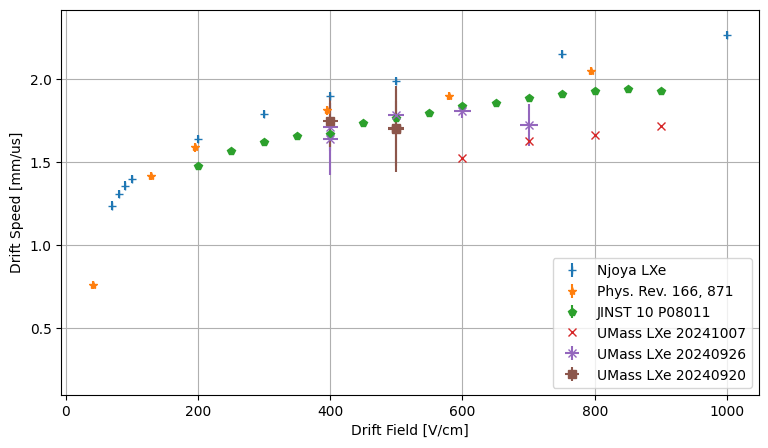

In [244]:
fig,ax= plt.subplots(1, 1, figsize=(9,5))


#print(bx)
colors=["r","blue","darkgrey","green","cyan","purple"]
marker=["o","x","p","s","h","*"]
markersize=7

sec=0

##Njoya liquid data
#njoya_y1=np.array([20,20/1.1,20/1.3,20/1.4,20/1.5,20/1.7])-1
#njoya_y2=np.array([20,20/1.1,20/1.3,20/1.4,20/1.5,20/1.7])+1
njyl=np.array([1.24,1.31,1.36,1.4,1.64,1.79,1.9,1.99,2.154,2.2685])
njxl=np.array([70,80,90,100,200,300,400,500,750,1000])
#njoya_x=[200*2,200*2,300*2,400*2,500*2,1000*2]

njoya_x=njxl
njoya_y=njyl


ax.errorbar(x=njoya_x,y=njoya_y,yerr=0.025,fmt=" ",marker="+",label="Njoya LXe")

ax.errorbar(x=ChT_Vs,y=ChT_dv,yerr=0.025,fmt=" ", marker="*",label="Phys. Rev. 166, 871 ")

ax.errorbar(x= JINST_2015_dict["Voltage"],y=JINST_2015_dict["DriftSpeed"],fmt=" ",marker="p",
            yerr=JINST_2015_dict["Error"],label="JINST 10 P08011 ")



voltages_raw=np.array(labels)

offset=[0,0,0,0]


ax.errorbar(x=drift_field_list_Oct7th_v1,
            y=9.185/drift_time_Oct7th_v1
           # ,xerr=drift_field_error[3:]
           #,yerr=delta_v_1[3:]
           ,fmt=" ",marker="x",label="UMass LXe 20241007")



ax.errorbar(x=voltages_raw[3:]+offset[3:],y=9.14/drift_time_LXe_Sept[3:]
            ,xerr=drift_field_error[3:]
           ,yerr=delta_v_1[3:],fmt=" ",marker="x",label="UMass LXe 20240926")
ax.errorbar(x=voltages_raw[:3] +offset[:3],y=9.14/drift_time_LXe_Sept[:3]
           ,xerr=drift_field_error[:3]
           ,yerr=delta_v_1[:3],fmt=" ",marker="s",label="UMass LXe 20240920")

ax.set_ylabel("Drift Speed [mm/us]")
ax.set_xlabel("Drift Field [V/cm]")


ax.set_ylim(0.1,2.42)
ax.grid()
ax.legend()

## Example back ground subtraction

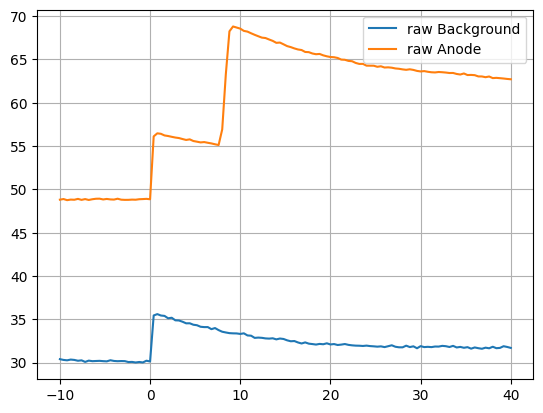

In [462]:
plt.errorbar(bgDF["Time"][::100], y=bgDF["Avg Anode"][::100],label="raw Background")
plt.errorbar(DF["Time"][::100], y=DF["Avg Anode"][::100], label="raw Anode")
plt.legend()
plt.grid()


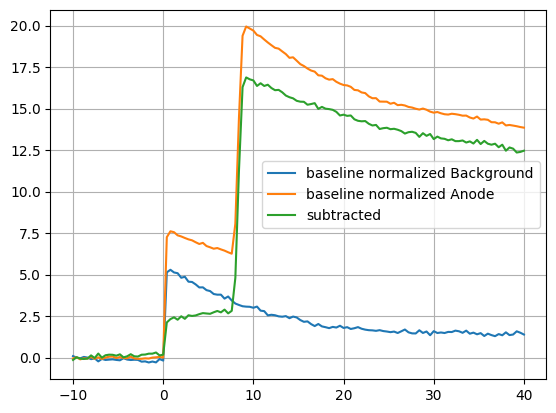

In [467]:
plt.errorbar(bgDF["Time"][::100], y=bgDF["Avg Anode"][::100]-np.average(bgDF["Avg Anode"][:100]),label="baseline normalized Background")
plt.errorbar(DF["Time"][::100], y=DF["Avg Anode"][::100]-np.average(DF["Avg Anode"][:100]), label="baseline normalized Anode")
sub=(DF["Avg Anode"]-np.average(DF["Avg Anode"][:100]))-(bgDF["Avg Anode"]-np.average(bgDF["Avg Anode"][:100]))
plt.errorbar(bgDF["Time"][::100], y=sub[::100],label="subtracted")
plt.legend()
plt.grid()

0.5999999799999998
2657     0.623111
4654     8.611111
6554    16.211111
9351    27.399110
Name: Time, dtype: float64


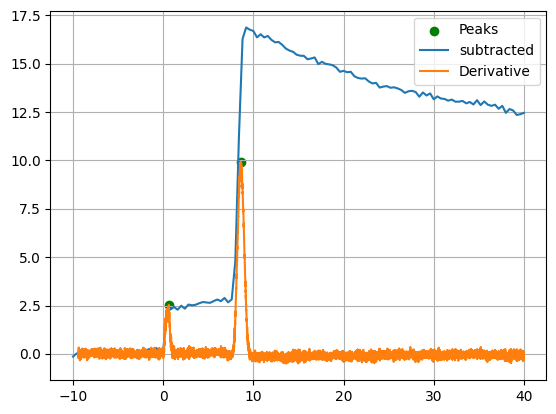

In [470]:
sub=(DF["Avg Anode"]-np.average(DF["Avg Anode"][:100]))-(bgDF["Avg Anode"]-np.average(bgDF["Avg Anode"][:100]))
diff = sub.diff(150)


print(bgDF["Time"].iloc[150] - bgDF["Time"].iloc[0])
plt.errorbar(bgDF["Time"][::100], y=sub[::100],label="subtracted")
plt.errorbar(bgDF["Time"],diff[1:],label="Derivative")


local_minima_indices = argrelextrema(np.array(diff), np.greater,order=1500)
print(bgDF["Time"].iloc[local_minima_indices])
x_minima = np.array(bgDF["Time"])[local_minima_indices]
y_minima = np.array(diff)[local_minima_indices]
plt.scatter(x_minima[:2], y_minima[:2], color='green', label='Peaks')

plt.legend()
plt.grid()

## Runs 151,152

Run 00151   Field 435.492651  time Delay  8.48114267
2.44514284
-32.226444799999996
0
Run 00152   Field 435.492651  time Delay  8.62199981
2.19399999
-137.0728187
1
cath
[2.44514284, 2.19399999]
anode
[8.48114267, 8.62199981]
Drift time
[6.03599983 6.42799982]
[435.4926510615133, 435.4926510615133]


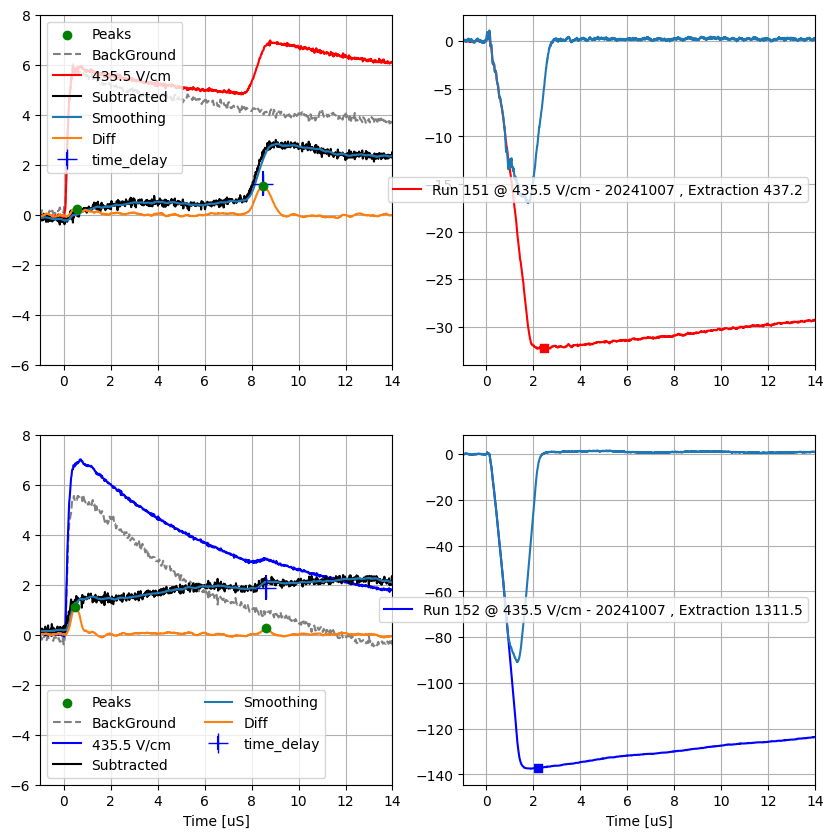

In [267]:

wafeform_path="C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/data/waveforms/" # Path for data On left pc

dates =     [20241007,20241007,20241007]
runnumbers= [151,152]
labels=[400,500,500,400,400,500,600,700]
bg_runs = [161,162]
c=["red","blue","magenta","cyan","brown","grey","skyblue","teal"]

chann_names=["Avg Cathode","Avg Anode"]

anode_time_delay=[]
catho_delay=[]
drift_field_list=[]
fig, axs = plt.subplots(len(runnumbers), 2,figsize=(10,10))


for i,rn  in enumerate(runnumbers):
    
    RI = GetRunInfo(rn)
    
    waveform_date ="%i"%(RI["Date"].iloc[0])
    runnumber="00%i"%(rn)
    stepcount=5
    waveform_dir=wafeform_path+waveform_date+"/"+waveform_date+"-"+runnumber
    waveform_wavenumber="10"
    waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
    waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
    DF=pd.read_csv(waveform_fullpath,skiprows=[1])
    


    ###Background

    bg_runnumber="00%i"%(bg_runs[i])
    BG_dir =wafeform_path +waveform_date+"/"+waveform_date+"-"+bg_runnumber
    bg_filename=waveform_date+"-"+bg_runnumber+"_"+waveform_wavenumber
    bg_fullpath= BG_dir + "/"+bg_filename + ".csv"
    bgDF=pd.read_csv(bg_fullpath,skiprows=[1])
    bg_anodenorm=np.average(bgDF[chann_names[1]][:100])
    ####



    drift_field = RI["Drift Field"].iloc[0]#RI["Cathode Grid V."].iloc[0]/(9.14/10)
    extract_field=RI["Extraction Field"].iloc[0]


    #print(drift_field)

    anodenorm=np.average(DF[chann_names[1]][:100])
    cathnorm=np.average(DF[chann_names[0]][:100])

    bg_norm=1# np.max(DF[chann_names[1]][::stepcount] - anodenorm) / np.max(bgDF[chann_names[1]][::stepcount*2] - bg_anodenorm)



    bg_y=(bgDF[chann_names[1]]- bg_anodenorm)*bg_norm


    sub = (DF[chann_names[1]] - anodenorm) - bg_y
    
    ##BG
    axs[i][0].errorbar(x=bgDF["Time"][::stepcount*2], fmt="--",
        y=(bgDF[chann_names[1]][::stepcount*2] - bg_anodenorm)*bg_norm, 
        color="grey", label="BackGround")
    ##

    axs[i][0].errorbar(x=DF["Time"][::stepcount],y=DF[chann_names[1]][::stepcount] - anodenorm, color= c[i], label="%0.1f V/cm "%(drift_field))
    
    #axs[1].errorbar(x=DF["Time"][::stepcount],y=DF["average(Cathode)"][::stepcount] - cathnorm, color= c[i], label="%i V/cm"%(labels[i]))
    
    ## Plot subtracted version
    axs[i][0].errorbar(x = DF["Time"][::stepcount],y=sub[::stepcount] , color="black", label="Subtracted")

    

    stepsize=50
    diffsize=100

    xdata=np.array(DF["Time"])
    ydata= sub                 #DF[chann_names[1]]-np.average(DF[chann_names[1]][:20])
    yrolling= sub.rolling(stepsize).mean()              #ydata.rolling(stepsize).mean()
    yprime=np.array(yrolling.diff(diffsize))
    ydata_nparray=np.array(np.roll(ydata,diffsize))



    local_minima_indices = argrelextrema(np.array(yprime), np.greater,order=1050)
    #local_minima_indices = argrelextrema(np.array(yprime), np.less,order=350)

    #print(local_minima_indices)
    # Get the x and y values of the local minima
    x_minima = xdata[local_minima_indices]
    y_minima = yprime[local_minima_indices]
    axs[i][0].scatter(x_minima, y_minima, color='green', label='Peaks', zorder=5)
    axs[i][0].errorbar(xdata,yrolling,label="Smoothing")
    axs[i][0].errorbar(xdata,yprime,label="Diff")
    
    ydata_minima = ydata_nparray[local_minima_indices[0][0]]
    #axs[i].scatter(x_minima[1], ydata_minima, color=c[i])
    
    time_delay_ind=0
    time_delay=xdata[np.array(local_minima_indices)[0][0]]
    while time_delay <3.5 :
        time_delay_ind=1 +time_delay_ind
        time_delay=xdata[np.array(local_minima_indices)[0][time_delay_ind]]
        if time_delay_ind > len(np.array(local_minima_indices)[0]) -1:
            print("Breaking out of while loop")
            break
        

    print("Run %s"%(runnumber), "  Field %f"%(drift_field) , " time Delay ",xdata[np.array(local_minima_indices)[0][time_delay_ind]] )


    anode_time_delay.append(xdata[np.array(local_minima_indices)[0][time_delay_ind]])
    ydata_minima = ydata_nparray[local_minima_indices[0][time_delay_ind]]


    #print( x_minima[time_delay_ind], ydata_minima )
    axs[i][0].errorbar(x_minima[time_delay_ind], ydata_minima,yerr=0.5, markersize=15,
                       fmt=" ", marker="+", color="blue", label="time_delay")



    axs[i][0].grid()
    axs[i][0].legend()

##cathods

    axs[i][1].errorbar(x=DF["Time"][::stepcount],y=DF[chann_names[0]][::stepcount] - cathnorm, color= c[i]
                       , label="Run %i @ %0.1f V/cm - %s , Extraction %0.1f"%(rn, drift_field,waveform_date,extract_field))
    axs[i][1].grid()
    axs[i][1].legend()

    Time=np.array(DF["Time"])
    Cath =DF[chann_names[0]] - cathnorm
    diff = Cath.diff(200)

    axs[i][1].errorbar(Time,diff,label="Diff")


    #cond= np.abs(diff)== np.max(np.abs(diff))
    cond= np.abs(diff)>=5


    print(Time[np.where(cond)][-1])
    cd=Time[np.where(cond)][-1]
    cd_amp=np.array(Cath.iloc[np.where(cond)])[-1]
    catho_delay.append(cd)
    print(cd_amp)

    axs[i][1].scatter(cd,cd_amp,marker="s",color=c[i])
    #catho_delay.append(Time[np.where(Cath == Cath_min)][0])
    #axs[i].set_xlim(-1,3)
    drift_field_list.append(drift_field)
    print(i)
    axs[i][0].legend(ncol=2)

    axs[i][1].set_xlim(-1,14)

    axs[i][0].set_xlim(-1,14)
    axs[i][0].set_ylim(-6,8)

axs[i][1].set_xlabel("Time [uS]")




print("cath")
print(catho_delay)
print("anode")
print(anode_time_delay)

Drift_time=np.array(anode_time_delay)-np.array(catho_delay)

print("Drift time")
print(Drift_time)
print(drift_field_list)



    

#axs[0].set_xlabel("Time [uS]")
#axs[0].set_ylabel("Preamp Signal [mV]")

#axs[0].grid()
axs[0][0].legend()


axs[i][0].set_xlabel("Time [uS]")
#axs[1].set_ylabel("Preamp Signal [mV]")
#axs[1].grid()
#axs[1].legend()

    #plt.title("Signal on 20240926")
#plt.xlim(-1000,10000)
drift_time_Oct7th_v2=np.array(Drift_time)
drift_field_list_Oct7th_v2=drift_field_list

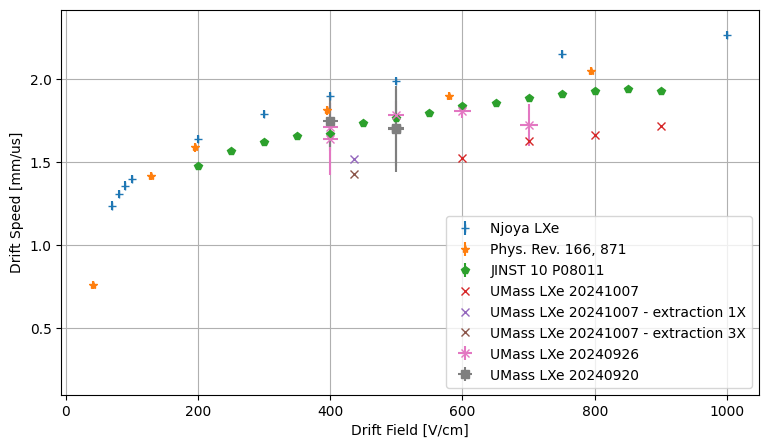

In [268]:
fig,ax= plt.subplots(1, 1, figsize=(9,5))


#print(bx)
colors=["r","blue","darkgrey","green","cyan","purple"]
marker=["o","x","p","s","h","*"]
markersize=7

sec=0

##Njoya liquid data
#njoya_y1=np.array([20,20/1.1,20/1.3,20/1.4,20/1.5,20/1.7])-1
#njoya_y2=np.array([20,20/1.1,20/1.3,20/1.4,20/1.5,20/1.7])+1
njyl=np.array([1.24,1.31,1.36,1.4,1.64,1.79,1.9,1.99,2.154,2.2685])
njxl=np.array([70,80,90,100,200,300,400,500,750,1000])
#njoya_x=[200*2,200*2,300*2,400*2,500*2,1000*2]

njoya_x=njxl
njoya_y=njyl


ax.errorbar(x=njoya_x,y=njoya_y,yerr=0.025,fmt=" ",marker="+",label="Njoya LXe")

ax.errorbar(x=ChT_Vs,y=ChT_dv,yerr=0.025,fmt=" ", marker="*",label="Phys. Rev. 166, 871 ")

ax.errorbar(x= JINST_2015_dict["Voltage"],y=JINST_2015_dict["DriftSpeed"],fmt=" ",marker="p",
            yerr=JINST_2015_dict["Error"],label="JINST 10 P08011 ")



voltages_raw=np.array(labels)

offset=[0,0,0,0]


ax.errorbar(x=drift_field_list_Oct7th_v1,
            y=9.185/drift_time_Oct7th_v1
           # ,xerr=drift_field_error[3:]
           #,yerr=delta_v_1[3:]
           ,fmt=" ",marker="x",label="UMass LXe 20241007")


ax.errorbar(x=drift_field_list_Oct7th_v2[:1],
            y=9.185/drift_time_Oct7th_v2[:1]
           # ,xerr=drift_field_error[3:]
           #,yerr=delta_v_1[3:]
           ,fmt=" ",marker="x",label="UMass LXe 20241007 - extraction 1X")
ax.errorbar(x=drift_field_list_Oct7th_v2[1:],
            y=9.185/drift_time_Oct7th_v2[1:]
           # ,xerr=drift_field_error[3:]
           #,yerr=delta_v_1[3:]
           ,fmt=" ",marker="x",label="UMass LXe 20241007 - extraction 3X")




ax.errorbar(x=voltages_raw[3:]+offset[3:],y=9.14/drift_time_LXe_Sept[3:]
            ,xerr=drift_field_error[3:]
           ,yerr=delta_v_1[3:],fmt=" ",marker="x",label="UMass LXe 20240926")
ax.errorbar(x=voltages_raw[:3] +offset[:3],y=9.14/drift_time_LXe_Sept[:3]
           ,xerr=drift_field_error[:3]
           ,yerr=delta_v_1[:3],fmt=" ",marker="s",label="UMass LXe 20240920")

ax.set_ylabel("Drift Speed [mm/us]")
ax.set_xlabel("Drift Field [V/cm]")


ax.set_ylim(0.1,2.42)
ax.grid()
ax.legend()

# Building useful functions to  standardize analysis

In [12]:
runnumber =154


def GetWaveForm(runnumber,wavenumber=10):
    global waveform_path
    RI = GetRunInfo(runnumber) 
    
    if type(RI)==type(0):
        return 0

    waveform_date ="%i"%(RI["Date"].iloc[0])
    runnumber="%05i"%(runnumber)

    # For left PC
    waveform_dir=waveform_path+waveform_date+"/"+waveform_date+"-"+runnumber
    waveform_wavenumber="%s"%(wavenumber)


    waveform_filename=waveform_date+"-"+runnumber+"_"+"*"+waveform_wavenumber
    waveform_fullpath_wild=waveform_dir+"/"+waveform_filename+".csv"
    try: 
        waveform_fullpath=glob.glob(waveform_fullpath_wild )[-1].replace("\\","/")
    except:
        waveform_fullpath=glob.glob(waveform_dir+"/"+waveform_date+"-"+runnumber+"_"+"*" )[-1].replace("\\","/")
  

    
    if os.path.exists(waveform_fullpath):
        unit_line=open(waveform_fullpath).readlines()[1]
        units=unit_line.replace("(","").replace(")","").strip().split(",")


        DF=pd.read_csv(waveform_fullpath,skiprows=[1])
        
        for i,key in enumerate(DF.keys()):
            if units[i] == "V":
                DF[key]=DF[key]*1000 
            if units[i] == "ms":
                print("time convertion")
                DF[key]=DF[key]*1000 

        
        return DF
    else:
        print("Issue with file")
        return 0





    






In [13]:
GetWaveForm(73,10)


Time  Channel Trigger  Channel Cathode  Channel Anode  Channel UV  \
0     -10.008000        -39.52387        12.684550       56.84055         0.0   
1     -10.004000          0.00000        15.852610       55.25959         0.0   
2     -10.000000        -39.52387        19.026820       53.67864         0.0   
3      -9.996000          0.00000        19.026820       53.67864         0.0   
4      -9.992000          0.00000        15.852610       53.67864         0.0   
...          ...              ...              ...            ...         ...   
12498  39.983999          0.00000         9.510334       69.46973         0.0   
12499  39.987999          0.00000         4.755167       69.46973         0.0   
12500  39.991999          0.00000         7.923228       67.88878         0.0   
12501  39.995999          0.00000        12.684550       67.88878         0.0   
12502  39.999999          0.00000        15.852610       67.88878         0.0   

       Average Anode (2)  Average Cathode (2)  
0               53.40487             20.67062  
1               53.39231             20.73958  
2               53.31852             20.50997  
3               53.37107             20.70449  
4               53.31612             20.73196  
...                  ...                  ...  
12498           55.19597             13.96695  
12499           55.54198             13.92680  
12500           55.40959             13.89669  
12501           55.25341             13.93435  
12502           55.60442             13.68095  

[12503 rows x 7 columns]

In [34]:
rs="171	172	173	174	175	176	177	178	179	180	181	182	183	184	185	186	187	188	189	190	191	192	193	194	195	196	197	198	199	200	201	202"
bs="203	204	205	206	207	208	209	210	211	212	213	214	215	216	217	218	219	220	208	210	212	214	216	221	222	223	224	225	226	227	228	229"

r_sep=rs.split("\t")
b_sep=bs.split("\t")
run_to_back =[r_sep,b_sep]


In [300]:


#Clean analysis list untill finalized
analysis_list=[]


### step by step analysis - Single run plots for cathode and anode


Run  143   BG-  160
C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/data/waveforms/20241007/20241007-00143/20241007-00143_10.csv
C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/data/waveforms/20241007/20241007-00160/20241007-00160_10.csv
bg too big
12502 12502
12502 12502
Anode p0  [0.8661525647851881, 7.91799983, 14.34599959]
3.681298670565265 -0.8162740430964853
3.062362492195056e-05 3.062362492195056e-05 0.04244794374300407
3.6808874230548776 -0.816266197010108
3.1400878569443404e-05 3.1400878569443404e-05 0.043548574496797034
3.2935203334681686 -0.8116948387481053
3.62222031492879e-05 3.62222031492879e-05 0.06245926235280466
3.0590676771095606 -0.8021695850623254
0.00010290328299056935 0.00010290328299056935 0.16739021898844844
0.17752832795211507 -0.10064602130297057
0.004045008232106414 0.004045008232106414 0.0006494445615351236
0.6618547841740984 -0.7885642148836598
0.0001444049216613441 0.0001444049216613441 0.0025331249925158623
-1.460818591342863 135.421085411594


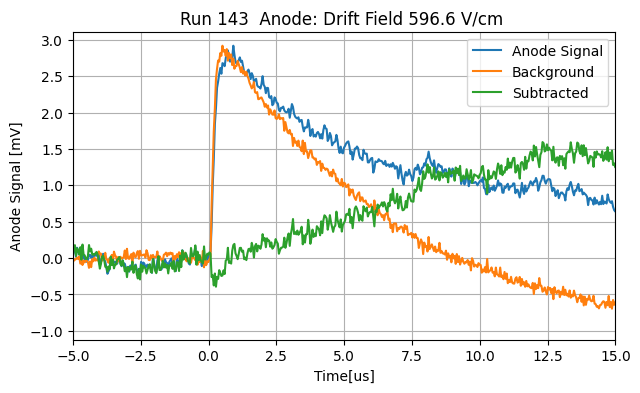

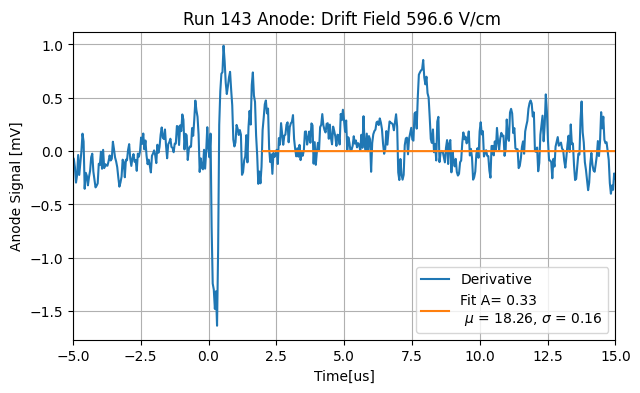

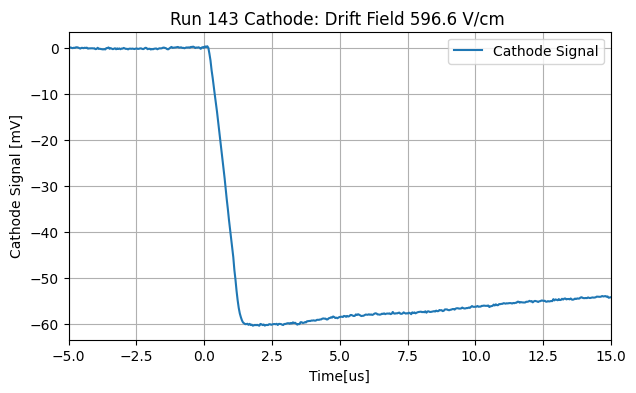

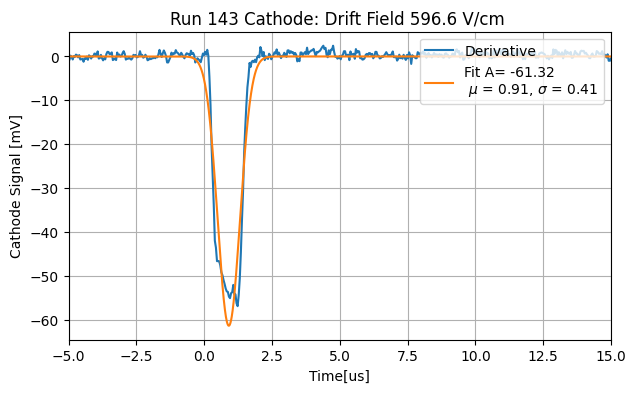

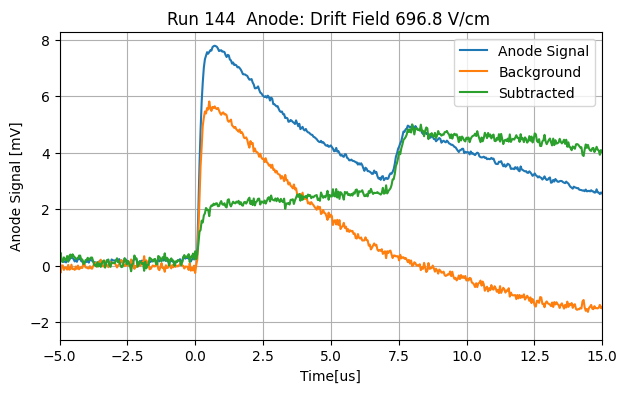

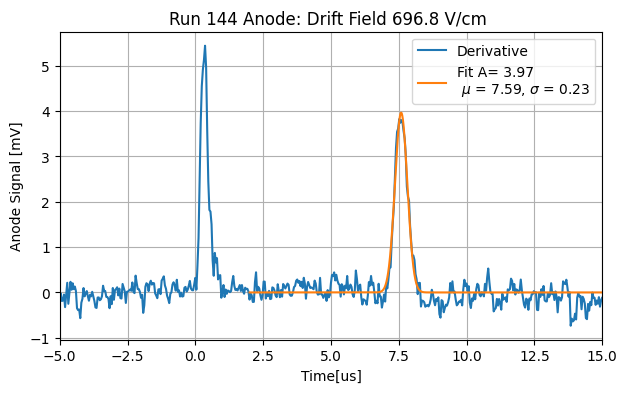

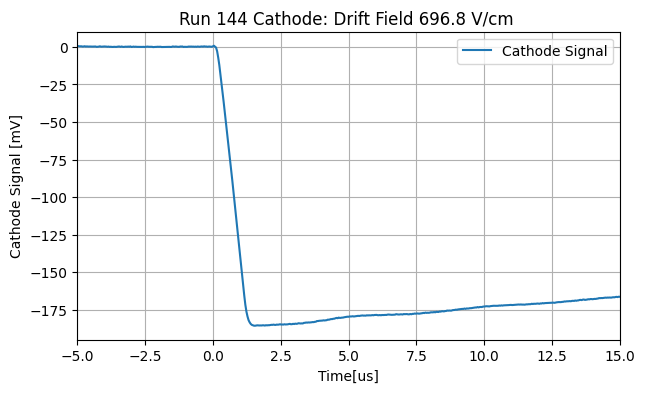

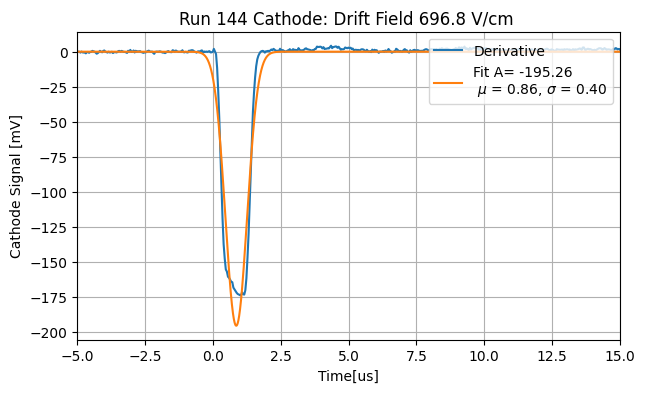

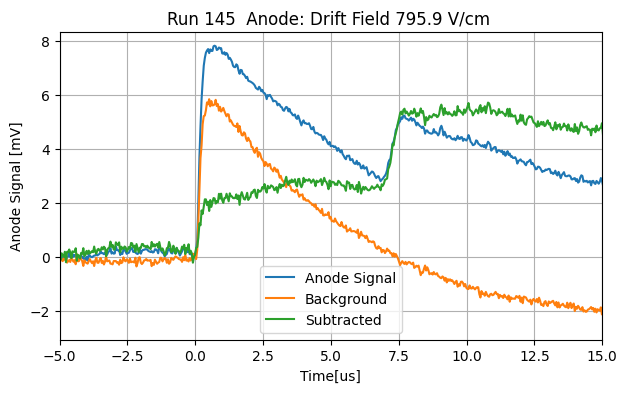

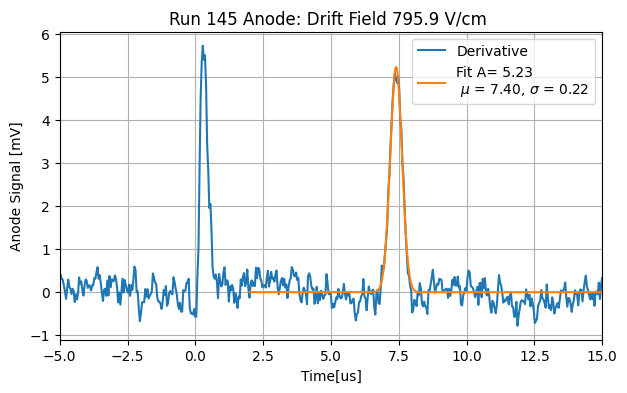

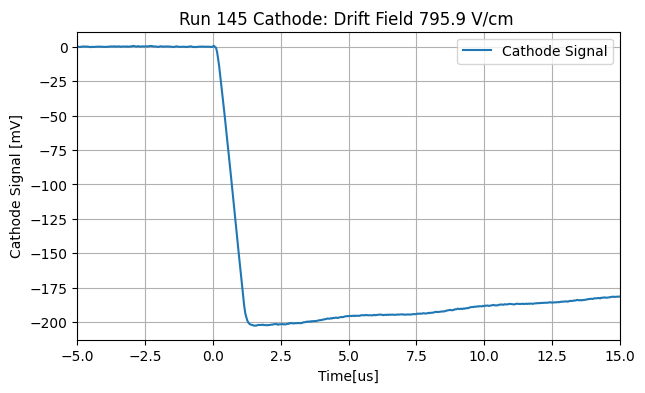

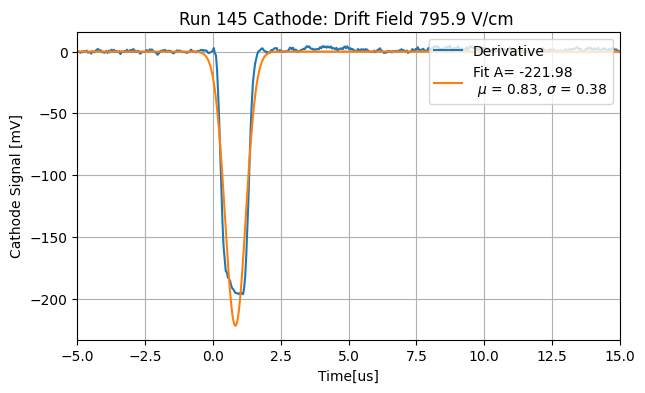

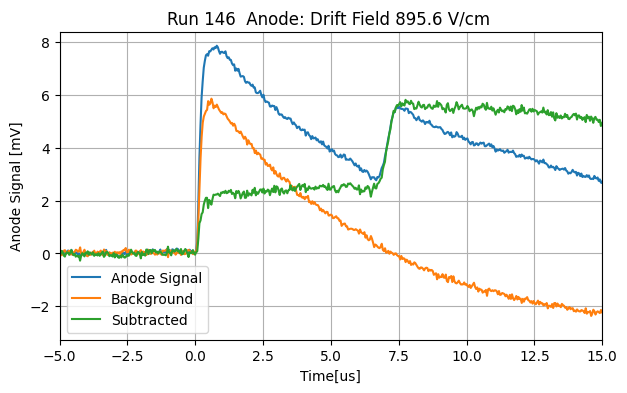

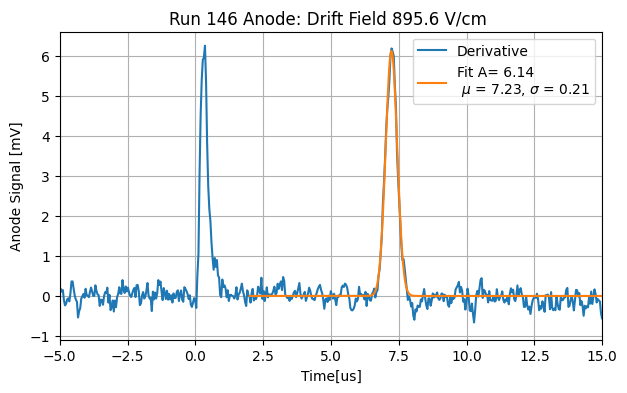

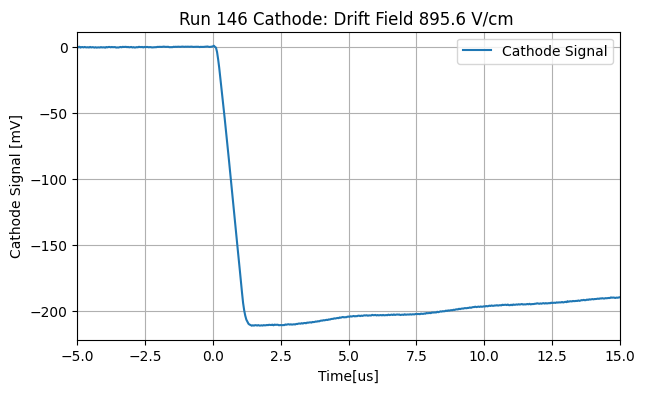

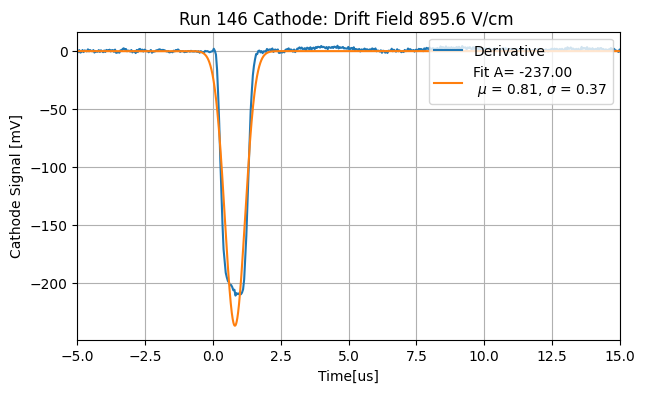

In [29]:
#oct 7th v1s
#runlist= [143     ,144  ,145, 146,]#147]
#bg_runs = [160,159,158,157]

#runlist=[199,200,201,202]
#bg_runs=[226,227,228,229]

runlist=[175,180] # Comparison between  500 hz and 100 hz
bg_runs=[207,212]

runlist=[117] # Comparison between  500 hz and 100 hz
bg_runs=[-1]


runlist   =[143,144,145,146] #+list(map(int,run_to_back[0])) #np.arange(177,181,1)  # List of runs
bg_runs   =[160,159,158,157] #+ list(map(int,run_to_back[1])) #np.arange(209,213,1) # Lis tof back ground runs



stepcount=10
diffsizes =[64]#[64,128,150]


#Prepare figures


#fig_d_E, axs_d_E = plt.subplots(1, figsize=(8,5))
#fig_d_n, axs_d_n = plt.subplots(1, figsize=(8,5))



anode_delay=[]
cathode_delay=[]
drift_field_list=[]
k=0
for k,diffsize in enumerate(diffsizes):

    i=0
    for j,run in enumerate(runlist):
        analysis_dict={}
        print("Run " , run, "  BG- ", bg_runs[j])

        # Need to systematicly determine these
        chann_names=["Avg Cathode","Avg Anode"]
        analysis_dict["Run"] = run
        # Grab the main and background waveforms
        try:
            DF=GetWaveForm(run)

        except:
            print("Issue with run " ,run)
            continue
        
        try:
            if bg_runs[j] ==-1:
                bgDF=pd.DataFrame()
            bgDF=GetWaveForm(bg_runs[j])
        except:
            print("Issue with bg " , bg_runs[j])
            continue


        fig_a, axs_a = plt.subplots(1, figsize=(7,4))
        fig_a2, axs_a2 = plt.subplots(1, figsize=(7,4))
        fig_c, axs_c = plt.subplots(1, figsize=(7,4))
        fig_c2, axs_c2 = plt.subplots(1, figsize=(7,4))


        if type(axs_a)!=type(np.array(0)):
            axs_a=[axs_a]
            axs_a2=[axs_a2]
            axs_c=[axs_c]
            axs_c2=[axs_c2]


        timeresolution = DF["Time"].iloc[1] - DF["Time"].iloc[0]

        RI = GetRunInfo(run)
        drift_field=RI["Drift Field"].iloc[0]
        bgRI = GetRunInfo(bg_runs[j])

        # Find the baseline normalization of each waveform
        anodenorm=np.average(DF[chann_names[1]][:100])
        cathnorm =np.average(DF[chann_names[0]][:100])
        bg_anorm =np.average(bgDF[chann_names[1]][:100])
        bg_cnorm =np.average(bgDF[chann_names[0]][:100])

        #Normalize signal and BG then subtract
        bg_y_factor=1

        anode_sig=DF[chann_names[1]] - anodenorm
        bg_a_sig =bgDF[chann_names[1]] - bg_anorm
        
        if np.max(bg_a_sig[:3000]) > np.max(anode_sig[:3000]):
            print("bg too big")
            bg_y_factor= np.max(anode_sig[:3000])/np.max(bg_a_sig[:3000])

        anode_sub= anode_sig-bg_a_sig[:len(anode_sig)]*bg_y_factor

        #take diff
        rolling= anode_sub.rolling(stepcount).mean()
        anode_diff = rolling.diff(diffsize)/(DF["Time"].iloc[diffsize]-DF["Time"].iloc[0])


        axs_a[i].errorbar(x=DF["Time"][::stepcount],y=anode_sig[::stepcount],  label="Anode Signal")
        axs_a[i].errorbar(x=bgDF["Time"][::stepcount],y=bg_a_sig[::stepcount]*bg_y_factor,  label="Background")


        print(len(anode_sig),len(bg_a_sig))

        print(len(anode_sub), len(DF["Time"]))



        axs_a[i].errorbar(x=DF["Time"][::stepcount],y=anode_sub[::stepcount],  label="Subtracted")

        axs_a2[i].errorbar(x=DF["Time"][::stepcount],y=anode_diff[::stepcount],  label="Derivative")

        #Fit the derivative with a guassian

        fit_start_index = np.where(abs(DF["Time"] - 0) <= 0.005)[0][-1] + int(2/timeresolution) #Time 0 +2

        #P0 for guassian fit
        diff_max=np.max(anode_diff[fit_start_index:]) #Amp value
        max_loc_ind = np.where(anode_diff == diff_max)[0] #index for max location
        max_time= np.array(DF["Time"])[max_loc_ind]    # time for the max location
        half_max_ind=[]
        k=0
        #print(diff_max,max_time)
        while len(half_max_ind) <=1:
            half_max_ind= (np.where(abs(anode_diff[fit_start_index:] - diff_max/2.0) <= 0.01*(k+1)) + fit_start_index)[0] #indexes for simga guess
            k=k+1
            
            if k >=15:
                break
        #print(half_max_ind)
        #print(DF["Time"].iloc[half_max_ind[-1]] , DF["Time"].iloc[half_max_ind[0]])

        half_max_sep = DF["Time"].iloc[half_max_ind[-1]] - DF["Time"].iloc[half_max_ind[0]]  # seperation between first and last index
        
       # axs_a2[i].errorbar(x=DF["Time"].iloc[max_loc_ind],y=anode_diff.iloc[max_loc_ind],fmt=" ", marker="s", label="Amplitude & $\mu$")
       # axs_a2[i].errorbar(x=DF["Time"].iloc[half_max_ind],y=anode_diff.iloc[half_max_ind],fmt=" ", markersize=10,marker="s", label="$\sigma$")

        #anode Fitting data
        xfit = np.array(DF["Time"][fit_start_index:])
        yfit = np.array(anode_diff[fit_start_index:].fillna(0))
        #guess for anode fit
        p0 = [diff_max,max_time[0],half_max_sep/2]
        print("Anode p0 ", p0)
        analysis_dict["Anode P0"]=p0
        
        sigma=10
        Amp=diff_max
        A=0
        xfit_tmp=xfit
        yfit_tmp=yfit
        z=0
        while sigma >=1 or abs((A-Amp))/Amp >= 0.1:
            ppot, pcov = curve_fit(gaussian,xfit_tmp,yfit_tmp, p0=p0,maxfev = 2000)
            z=z+1
            sigma=ppot[2]
            A=ppot[0]
            print(sigma, (A-Amp)/Amp)
            print(pcov[0][0],pcov[i][i],pcov[2][2])

            if z >=10:
                break
            
            yfit_tmp = yfit[np.max([max_loc_ind[0]-(10-z)*500,0]):np.min([max_loc_ind[0]+(10-z)*500,len(yfit)])].copy()
            xfit_tmp = xfit[np.max([max_loc_ind[0]-(10-z)*500,0]):np.min([max_loc_ind[0]+(10-z)*500,len(xfit)])].copy()


        
        analysis_dict["Anode Delay Time"] = ppot[1]
        analysis_dict["Anode Delay Sigma"] = ppot[2]
        analysis_dict["Anode Amp"] = ppot[0]
                

        guass_y = gaussian(xfit,ppot[0],ppot[1],ppot[2])
        axs_a2[i].errorbar(x=xfit,y=guass_y,label="Fit A= %0.2f \n $\mu$ = %0.2f, $\sigma$ = %0.2f"%(ppot[0],ppot[1],ppot[2]))

        
        axs_c[i].errorbar(x=DF["Time"][::stepcount],y=DF[chann_names[0]][::stepcount] - cathnorm,   label="Cathode Signal")

        #Normalize signal and BG then subtract
        cath_sig=DF[chann_names[0]] - cathnorm

        
        cath_diff = cath_sig.diff(diffsize)/(DF["Time"].iloc[diffsize]-DF["Time"].iloc[0])
        
        axs_c2[i].errorbar(x=DF["Time"][::stepcount],y=cath_diff[::stepcount],   label="Derivative")
        
        #Cathode Fitting data
        xfit = np.array(DF["Time"][:])
        yfit = np.array(cath_diff[:].fillna(0))
        #guess for cathode fit

        min_loc_ind = np.where(cath_diff == np.min(cath_diff)) #index for max locaiton
        min_time= np.array(DF["Time"])[min_loc_ind][0]

        k=0
        half_min_ind=[]
        #print(np.min(cath_diff),min_time)
        while len(half_min_ind) <=1:
            #print( np.min(cath_diff)/2.0 ,0.01*k)
            half_min_ind= (np.where(abs(cath_diff - np.min(cath_diff)/2.0) <= 0.2*k) )[0] #indexes for simga guess
            k=k+1
            #print(half_min_ind, k)
            if k >=35:
                break

        #half_min_ind= (np.where(abs(cath_diff - np.min(diff_max)/2.0) <= 0.05) )[0] #indexes for simga guess
        half_min_sep = DF["Time"].iloc[half_min_ind[-1]] - DF["Time"].iloc[half_min_ind[0]]  # seperation between first and last index
        #print("cathode half min ", half_min_ind)
        #axs_c[i].errorbar(x=DF["Time"].iloc[min_loc_ind],y=cath_diff.iloc[min_loc_ind],fmt=" ", marker="s", label="Amplitude & $\mu$")
        #axs_c[i].errorbar(x=DF["Time"].iloc[half_min_ind],y=cath_diff.iloc[half_min_ind],fmt=" ", markersize=10,marker="s", label="$\sigma$") 
        
        p0 = [np.min(yfit),min_time,half_min_sep]
        print("cathode p0", p0)
        analysis_dict["Cathode P0"]=p0
        analysis_dict["fit stepsize"]=stepcount
        analysis_dict["fit diffsize"]=diffsize
        #Fit cathode deriv
        ppot, pcov = curve_fit(gaussian,xfit,yfit, p0=p0)

        analysis_dict["Cathode Delay Time"] = ppot[1]
        analysis_dict["Cathode Delay Sigma"] = ppot[2]
        analysis_dict["Cathode Amp"] = ppot[0]

        guass_y = gaussian(xfit,ppot[0],ppot[1],ppot[2])
        axs_c2[i].errorbar(x=xfit,y=guass_y,label="Fit A= %0.2f \n $\mu$ = %0.2f, $\sigma$ = %0.2f"%(ppot[0],ppot[1],ppot[2]))

        




        axs_a[i].grid()
        axs_a[i].legend()
        axs_a[i].set_xlabel("Time[us]")
        axs_a[i].set_ylabel("Anode Signal [mV]")
        axs_a[i].set_title("Run %i  Anode: Drift Field %0.1f V/cm "%(run,drift_field))
        axs_a[i].set_xlim(-5,15)

        axs_a2[i].grid()
        axs_a2[i].legend()
        axs_a2[i].set_xlabel("Time[us]")
        axs_a2[i].set_ylabel("Anode Signal [mV]")
        axs_a2[i].set_title("Run %i Anode: Drift Field %0.1f V/cm "%(run,drift_field))
        axs_a2[i].set_xlim(-5,15)

        axs_c[i].grid()
        axs_c[i].legend(loc="upper right")
        axs_c[i].set_xlabel("Time[us]")
        axs_c[i].set_ylabel("Cathode Signal [mV]")
        axs_c[i].set_title("Run %i"%(run))
        axs_c[i].set_title("Run %i Cathode: Drift Field %0.1f V/cm "%(run,drift_field))
        axs_c[i].set_xlim(-5,15)
        axs_c2[i].grid()
        axs_c2[i].legend(loc="upper right")
        axs_c2[i].set_xlabel("Time[us]")
        axs_c2[i].set_ylabel("Cathode Signal [mV]")
        axs_c2[i].set_title("Run %i"%(run))
        axs_c2[i].set_title("Run %i Cathode: Drift Field %0.1f V/cm "%(run,drift_field))
        axs_c2[i].set_xlim(-5,15)


    
        drift_field = RI["Drift Field"].iloc[0]#RI["Cathode Grid V."].iloc[0]/(9.14/10)
        extract_field=RI["Extraction Field"].iloc[0]
        analysis_dict["Drift Field"] =drift_field
        analysis_dict["Extraction Field"] =extract_field
        analysis_dict["pressure"] = RI["Target Pressure"].iloc[0]
        analysis_dict["Temp"] = RI["RTD 2"].iloc[0]



        plot_dir="C:/Users/jasonbane/Desktop/nexo_code/Plots/"


        analysis_list.append(analysis_dict)
        anode_1_fig_name= plot_dir + "Run_%i"%(run)+"-Anode.v1_stp%i"%(stepcount)+"-diff%i"%(diffsize)+".png"
        anode_2_fig_name= plot_dir + "Run_%i"%(run)+"-Anode.v2_stp%i"%(stepcount)+"-diff%i"%(diffsize)+".png"
        cath_1_fig_name= plot_dir + "Run_%i"%(run)+"-Cath_stp%i"%(stepcount)+"-diff%i"%(diffsize)+".png"
        cath_2_fig_name= plot_dir + "Run_%i"%(run)+"-Cath.v2_stp%i"%(stepcount)+"-diff%i"%(diffsize)+".png"
        fig_a.savefig(anode_1_fig_name,)

        fig_a2.savefig(anode_2_fig_name)
        fig_c.savefig(cath_1_fig_name)
        fig_c2.savefig(cath_2_fig_name)






In [106]:
n=50000
pd.DataFrame({chann_names[0]: [0] * n, chann_names[1]: [0] * n})  # Replace `n` with the number of rows you want


Avg Cathode  Avg Anode
0                0          0
1                0          0
2                0          0
3                0          0
4                0          0
...            ...        ...
49995            0          0
49996            0          0
49997            0          0
49998            0          0
49999            0          0

[50000 rows x 2 columns]

Run  140   BG-  -1
0.004000000000001336
That run not in list
bg anode norm fact 0.0
modifed diffsize  149
2.0400408505423933 [4348] [7.38599985]
[7.38599985]
Anode p0  [2.0400408505423933, 7.38599985, 0.30599999499999964]
49
cathode p0 [-7.4733056199095715, 2.18599999, 1.9479999399999999]
[[ 1.52186058e-03 -3.40843373e-12  9.95575219e-05]
 [-3.40843373e-12  1.95386497e-05 -3.38012083e-13]
 [ 9.95575219e-05 -3.38012083e-13  1.95386498e-05]]

Run  141   BG-  -1
0.0039999999999995595
That run not in list
bg anode norm fact 0.0
modifed diffsize  150
4.437753147925105 [4353] [7.40479984]
[7.40479984]
Anode p0  [4.437753147925105, 7.40479984, 0.3339999950000001]
50
cathode p0 [-13.599900453330031, 1.9768, 1.9679999400000001]
[[ 1.65243668e-03 -1.83956135e-12  5.77524318e-05]
 [-1.83956135e-12  6.05531834e-06 -9.40744001e-14]
 [ 5.77524318e-05 -9.40744001e-14  6.05531842e-06]]

Run  142   BG-  -1
0.0039999999999995595
That run not in list
bg anode norm fact 0.0
modifed diffsize  150
1.4037446

c:\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


50
cathode p0 [-6.679950222665011, 0.73600003, 46.49999868]
[[ 1.89097908e-02 -3.05293217e-11 -6.01340230e-04]
 [-3.05293217e-11  5.73687060e-05  1.55431543e-12]
 [-6.01340230e-04  1.55431543e-12  5.73687051e-05]]

Run  37   BG-  -1
0.0039999999999995595
That run not in list
bg anode norm fact 0.0
modifed diffsize  150
1.439498047983269 [4136] [6.53599987]
[6.53599987]
Anode p0  [1.439498047983269, 6.53599987, 15.107999575000001]
50
cathode p0 [-8.786683626222795, 0.81200003, 31.151999110000002]
[[ 1.91246842e-02 -2.57281053e-11  6.66668683e-04]
 [-2.57281053e-11  6.97183499e-05 -1.38490714e-12]
 [ 6.66668683e-04 -1.38490714e-12  6.97183494e-05]]

Run  38   BG-  -1
0.0039999999999995595
That run not in list
bg anode norm fact 0.0
modifed diffsize  150
1.5870640529021354 [4156] [6.61599987]
[6.61599987]
Anode p0  [1.5870640529021354, 6.61599987, 8.597999755]
50
cathode p0 [-13.72598379086613, 0.79600003, 0.76799997]
[[ 2.18601383e-02 -1.82228013e-11  3.99826067e-04]
 [-1.82228013e-11  2

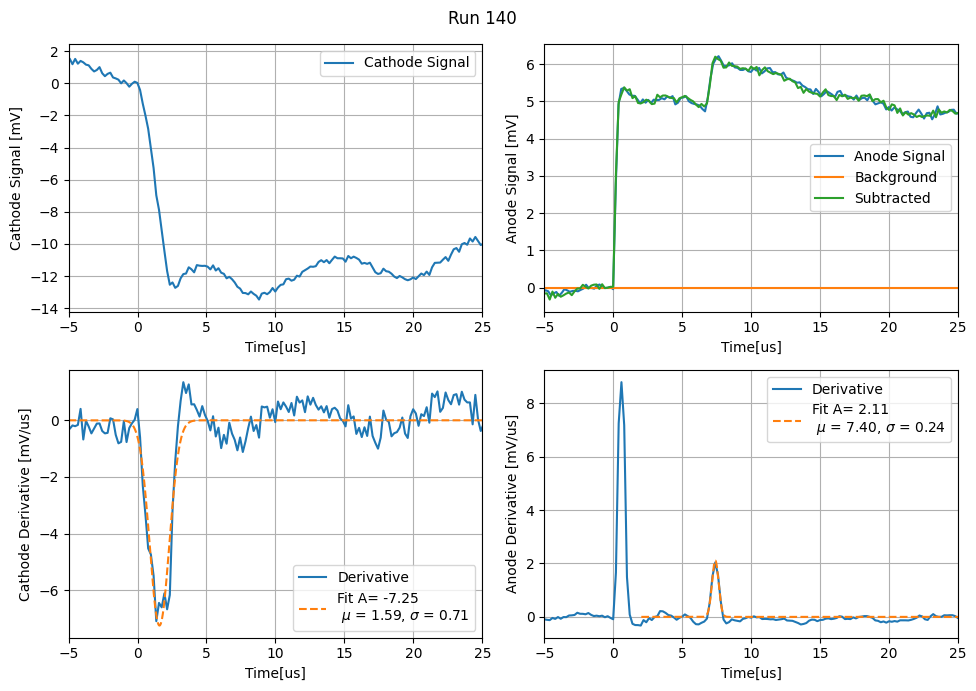

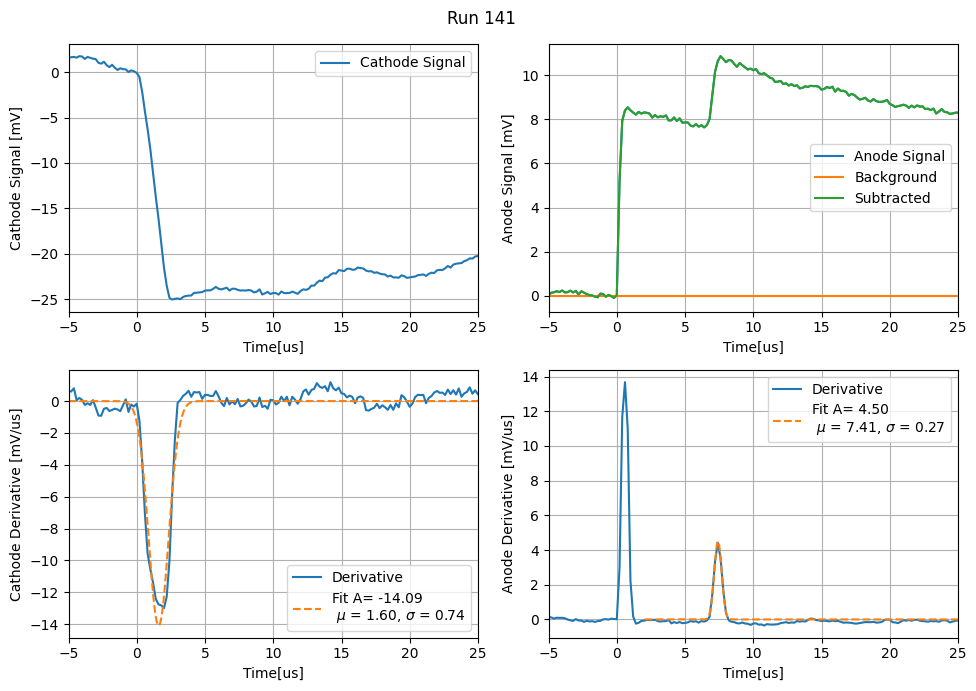

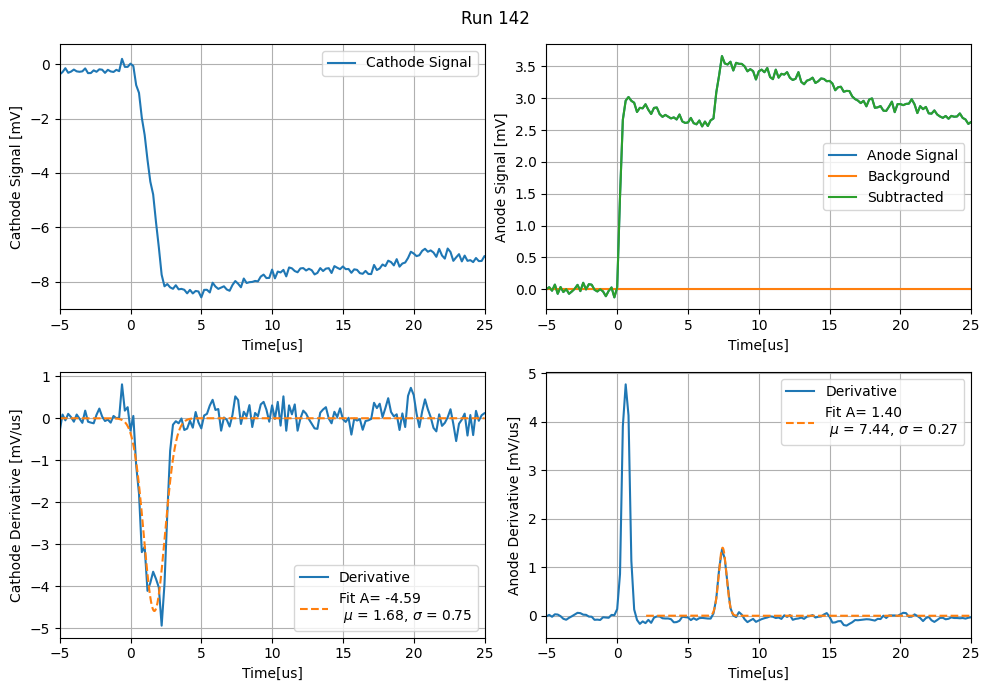

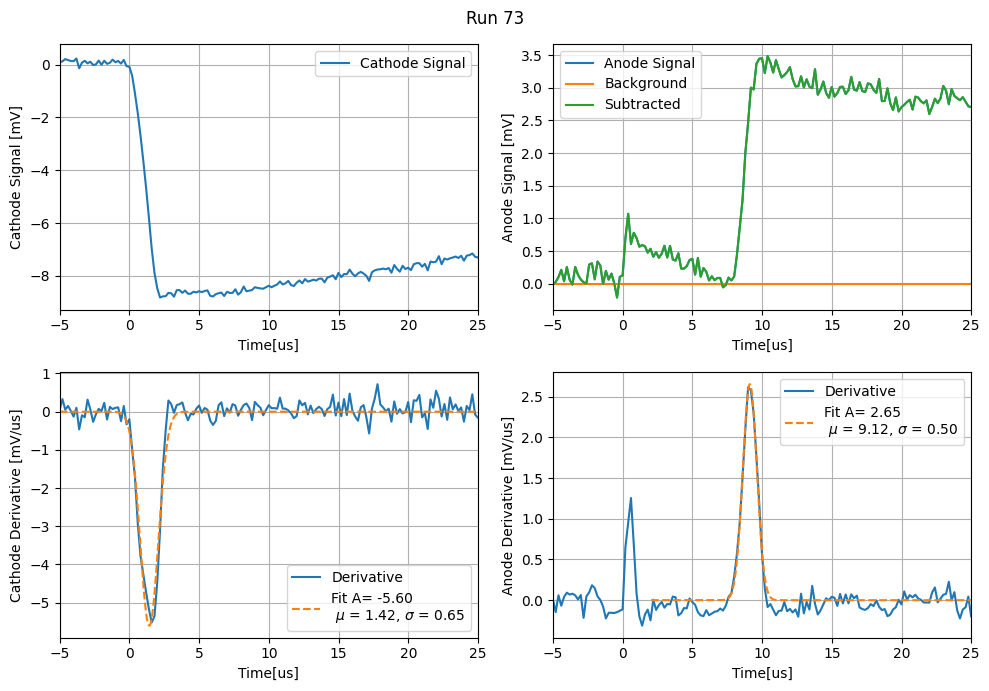

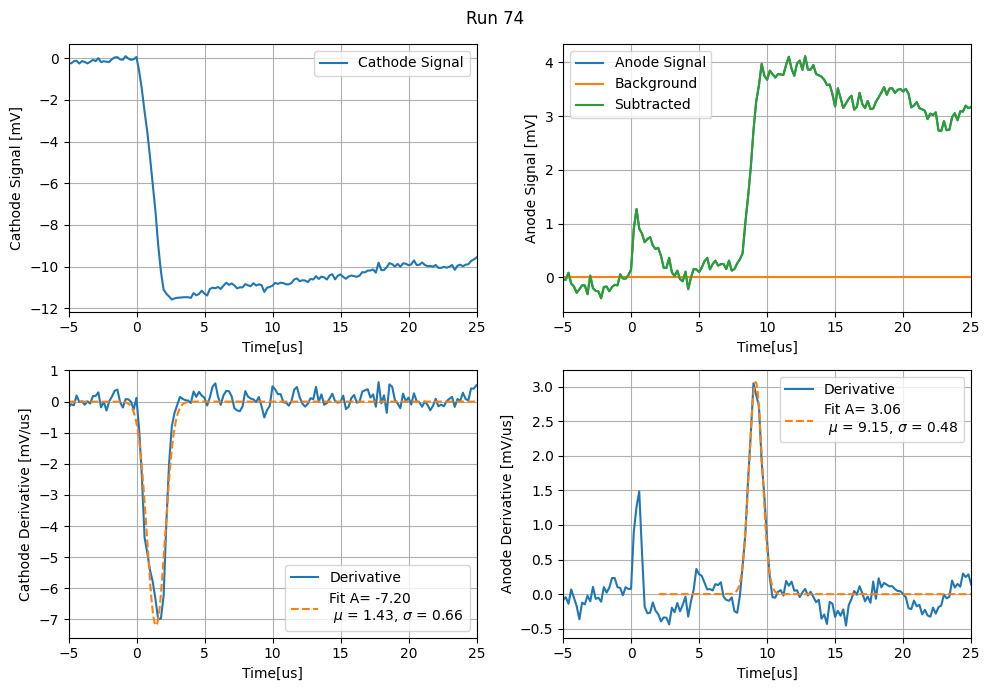

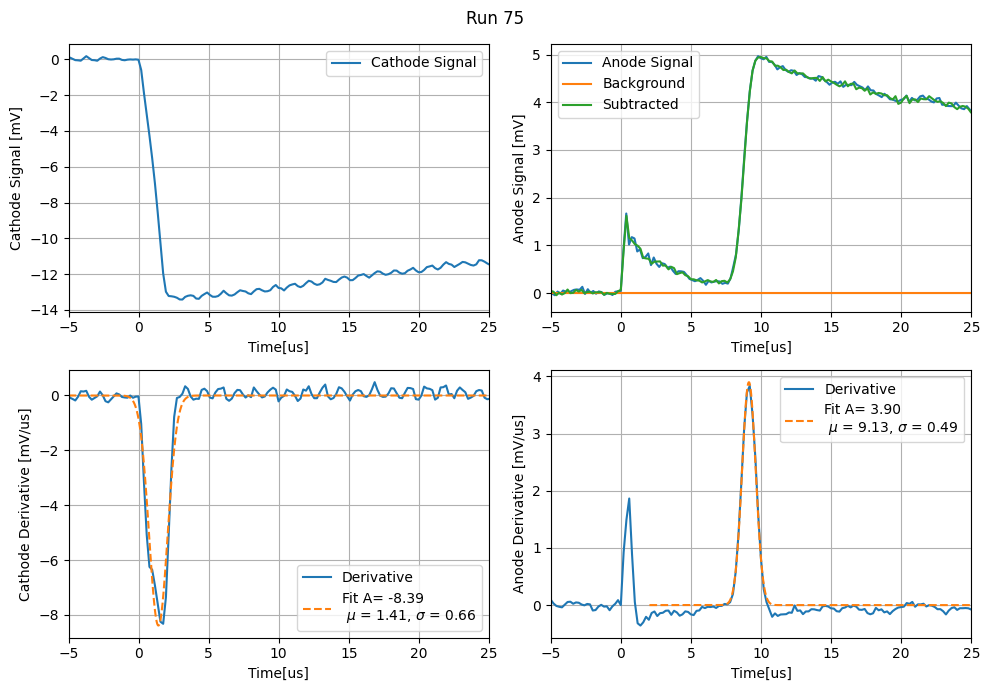

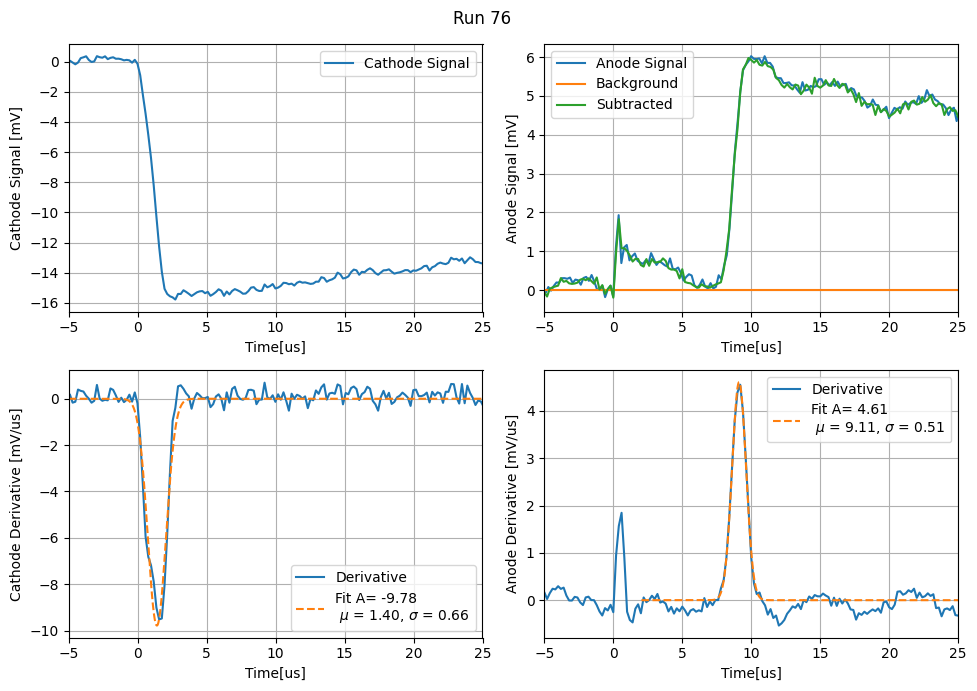

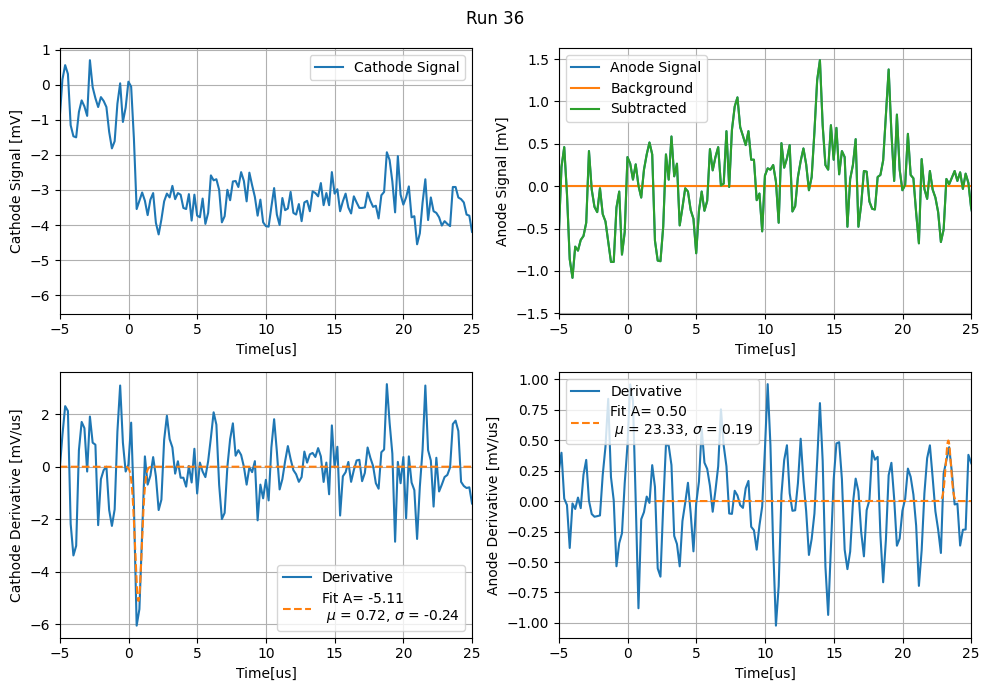

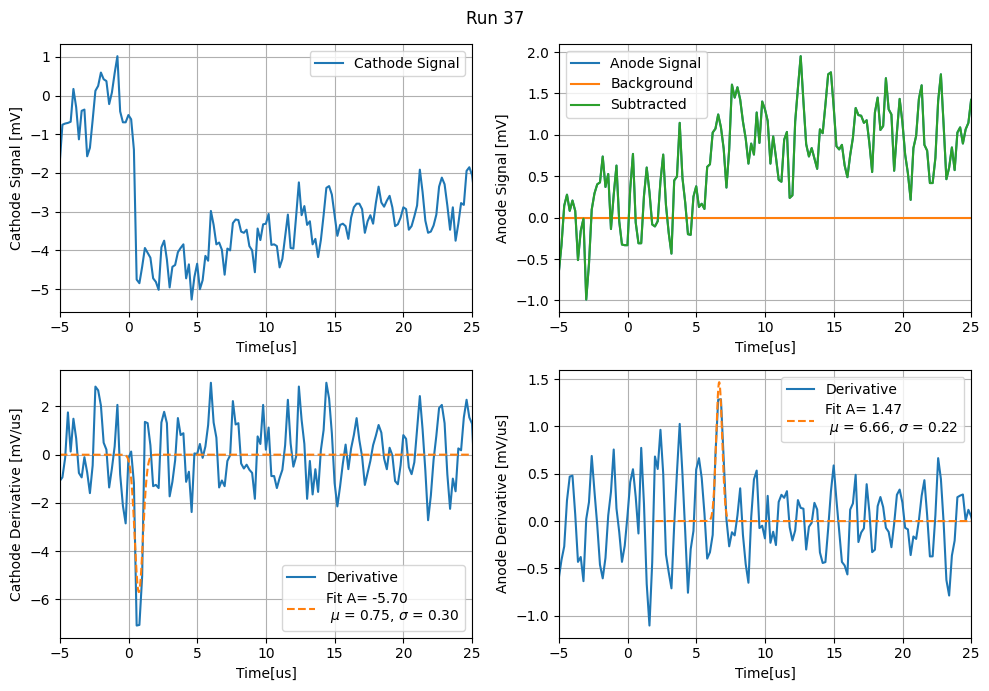

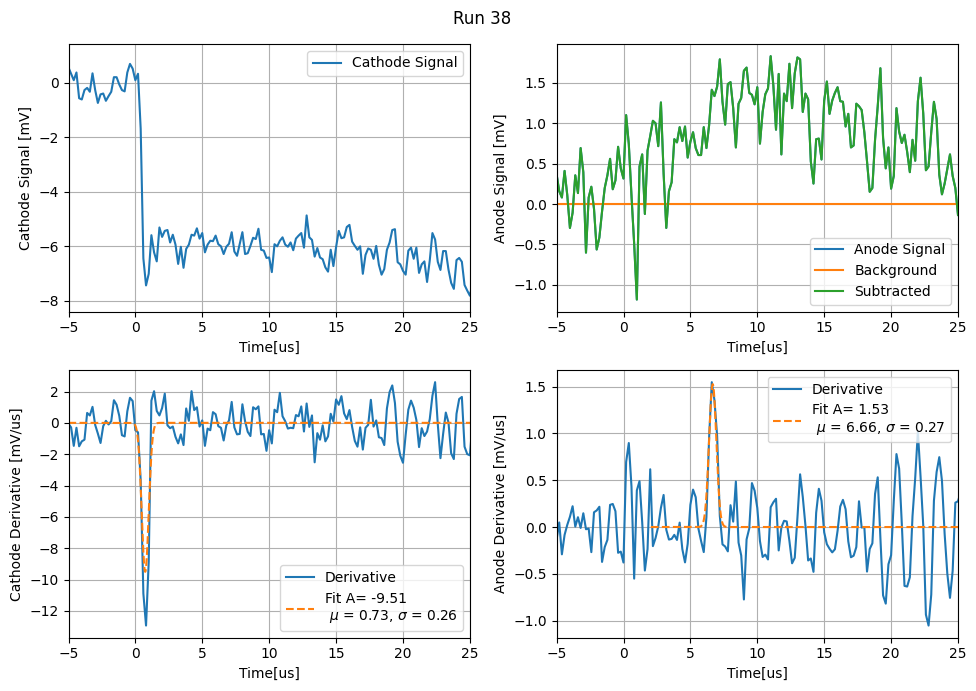

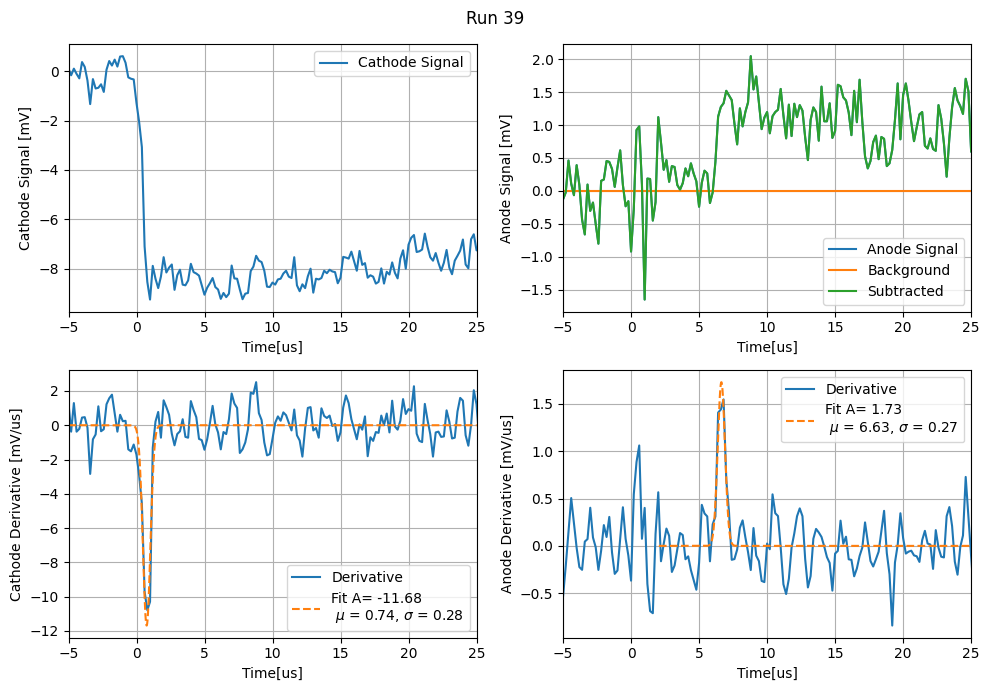

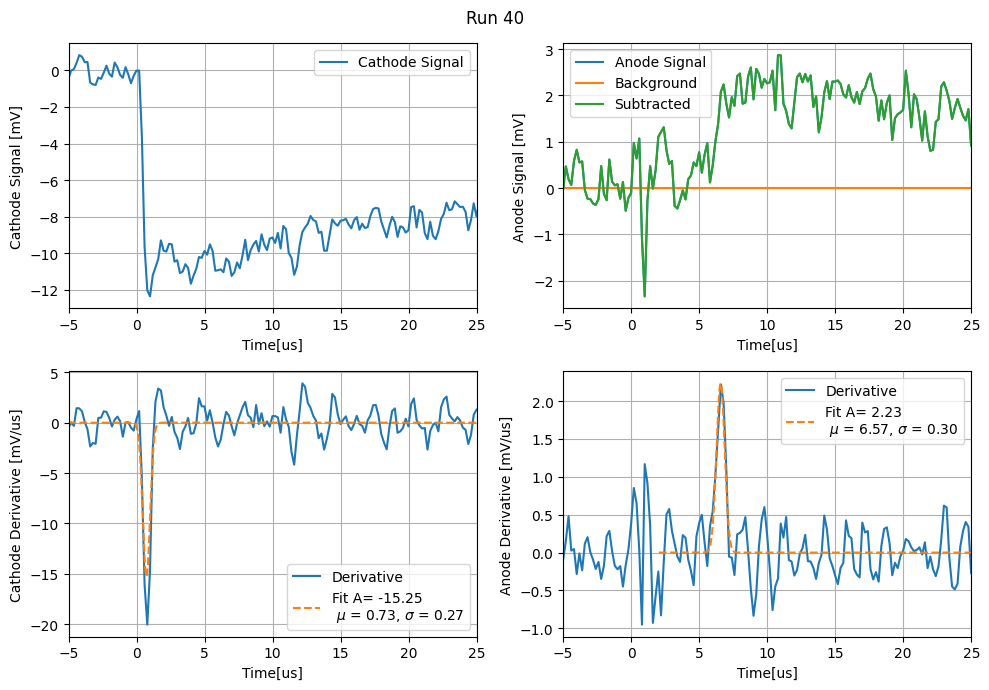

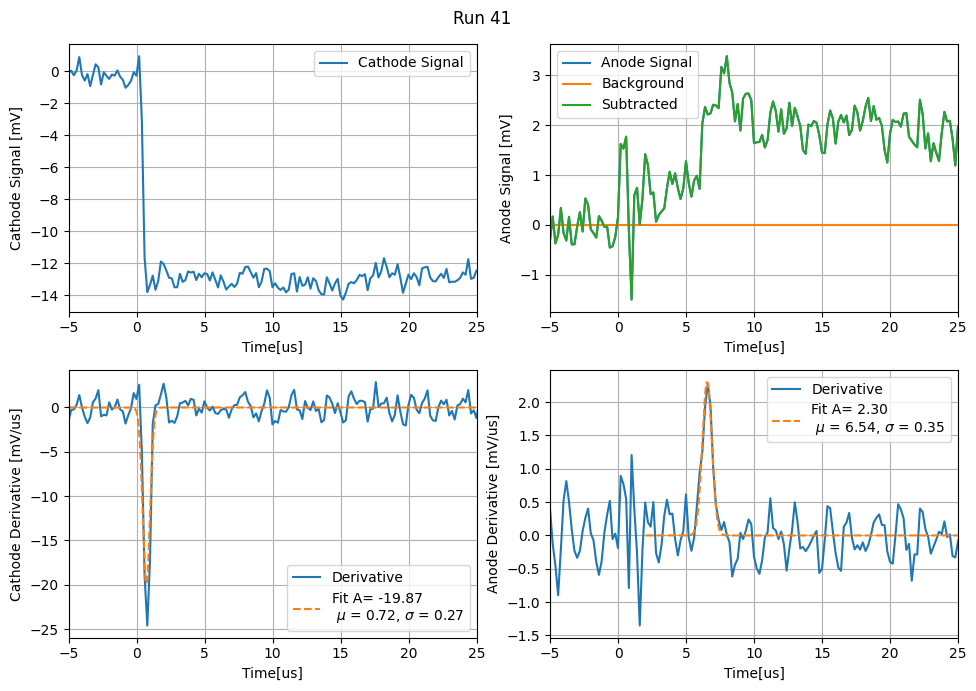

In [301]:
#oct 7th v1s
#runlist= [143     ,144  ,145, 146,]#147]
#bg_runs = [160,159,158,157]

#runlist=[199,200,201,202]
#bg_runs=[226,227,228,229]

#runlist=[175,180] # Comparison between  500 hz and 100 hz
#bg_runs=[207,212]

#runlist=[117] # Comparison between  500 hz and 100 hz
#bg_runs=[-1]


#runlist   =[143,144,145,146] #+list(map(int,run_to_back[0])) #np.arange(177,181,1)  # List of runs
#bg_runs   =[160,159,158,157] #+ list(map(int,run_to_back[1])) #np.arange(209,213,1) # Lis tof back ground runs
runlist=[140,141,142,73,74,75,76,36,37,38,39,40,41]
bg_runs=[-1]*len(runlist)

stepcount=50
diffsizes =[150]#[64,128,150]


#Prepare figures


#fig_d_E, axs_d_E = plt.subplots(1, figsize=(8,5))
#fig_d_n, axs_d_n = plt.subplots(1, figsize=(8,5))



anode_delay=[]
cathode_delay=[]
drift_field_list=[]
k=0
for k,diffsize in enumerate(diffsizes):

    i=0
    for j,run in enumerate(runlist):
        analysis_dict={}
        print("Run " , run, "  BG- ", bg_runs[j])

        # Need to systematicly determine these
        chann_name_options=[["Avg UV","Avg Anode"],["Avg Cathode","Avg Anode"],['Average Cathode (2)', 'Average Anode (2)']]
        chann_names=["Avg UV","Avg Anode"]#["Avg Cathode","Avg Anode"]['Average Anode (2)', 'Average Cathode (2)]
        analysis_dict["Run"] = run
        # Grab the main and background waveforms
        try:
            DF=GetWaveForm(run)

        except:
            print("Issue with run " ,run)
            continue
        
        findnames=0
        m=0
        while findnames==0:
            if chann_name_options[m][0] in DF.keys():
                findnames=1
                chann_names=chann_name_options[m]
            else:         
                m=m+1


        try:
            if bg_runs[j] ==-1:
                n=len(DF["Time"])
                bgDF=pd.DataFrame({chann_names[0]: [0] *n , chann_names[1]: [0] * n})
            else:
                bgDF=GetWaveForm(bg_runs[j])
        except Exception as e:
            print(f"An error occurred: {e}")
            print("Issue with bg " , bg_runs[j])
            continue

        fig, ax = plt.subplots(2,2, figsize=(10,7))
        
        #,figsize=(7,4) )
        # fig_a, axs_a = plt.subplots(1, figsize=(7,4))
        # fig_a2, axs_a2 = plt.subplots(1, figsize=(7,4))
        # fig_c, axs_c = plt.subplots(1, figsize=(7,4))
        # fig_c2, axs_c2 = plt.subplots(1, figsize=(7,4))


        # if type(axs_a)!=type(np.array(0)):
        #     axs_a=[axs_a]
        #     axs_a2=[axs_a2]
        #     axs_c=[axs_c]
        #     axs_c2=[axs_c2]


        timeresolution = DF["Time"].iloc[1] - DF["Time"].iloc[0]
        print(timeresolution)
        RI = GetRunInfo(run)
        drift_field=RI["Drift Field"].iloc[0]
        bgRI = GetRunInfo(bg_runs[j])

        # Find the baseline normalization of each waveform
        mod_step=int((stepcount * 0.004/timeresolution))
        res_mod=0.004/timeresolution
        Zero_time = np.where(abs(DF["Time"] - 0) <= 10*timeresolution)[0][-1] #Time 0 +2


        anodenorm=np.average(DF[chann_names[1]][Zero_time-int(100*res_mod):Zero_time-int(10*res_mod)])
        cathnorm =np.average(DF[chann_names[0]][Zero_time-int(100*res_mod):Zero_time-int(10*res_mod)])
        bg_anorm =np.average(bgDF[chann_names[1]][Zero_time-int(100*res_mod):Zero_time-int(10*res_mod)])
        bg_cnorm =np.average(bgDF[chann_names[0]][Zero_time-int(100*res_mod):Zero_time-int(10*res_mod)])

        print("bg anode norm fact",bg_anorm)
        #Normalize signal and BG then subtract
        bg_y_factor=1

        anode_sig=DF[chann_names[1]] - anodenorm
        bg_a_sig =bgDF[chann_names[1]] - bg_anorm
        
        if np.max(bg_a_sig[:3000]) > np.max(anode_sig[:3000]):
            print("bg too big")
            bg_y_factor= np.max(anode_sig[:3000])/np.max(bg_a_sig[:3000])

        anode_sub= anode_sig-bg_a_sig[:len(anode_sig)]*bg_y_factor

        #take diff
        rolling= anode_sub.rolling(mod_step).mean()
        print("modifed diffsize ",int(diffsize*res_mod))
        anode_diff = rolling.diff(int((diffsize*res_mod)))/(DF["Time"].iloc[int((diffsize*res_mod))]-DF["Time"].iloc[0])


        ax[0][1].errorbar(x=DF["Time"][::mod_step],y=anode_sig[::mod_step],  label="Anode Signal")
        ax[0][1].errorbar(x=DF["Time"][::mod_step],y=bg_a_sig[::mod_step]*bg_y_factor,  label="Background")




        ax[0][1].errorbar(x=DF["Time"][::stepcount],y=anode_sub[::stepcount],  label="Subtracted")

        ax[1][1].errorbar(x=DF["Time"][::stepcount],y=anode_diff[::stepcount],  label="Derivative")

        #Fit the derivative with a guassian
        fit_start_index = np.where(abs(DF["Time"] - 0) <= 10*timeresolution)[0][-1] + int(2/timeresolution) #Time 0 +2
    
        #P0 for guassian fit
        diff_max=np.max(anode_diff[fit_start_index:]) #Amp value
        max_loc_ind = np.where(anode_diff == diff_max)[0] #index for max location
        max_time= np.array(DF["Time"])[max_loc_ind]    # time for the max location

        print(diff_max,max_loc_ind,max_time)
        half_max_ind=[]
        k=0
        #print(diff_max,max_time)
        while len(half_max_ind) <=1:
            half_max_ind= (np.where(abs(anode_diff[fit_start_index:] - diff_max/2.0) <= 0.01*(k+1)) + fit_start_index)[0] #indexes for simga guess
            k=k+1
            
            if k >=25:
                print("Cant find second half max for anode")
                break
        #print(half_max_ind)
        #print(DF["Time"].iloc[half_max_ind[-1]] , DF["Time"].iloc[half_max_ind[0]])
        try :
            half_max_sep = DF["Time"].iloc[half_max_ind[-1]] - DF["Time"].iloc[half_max_ind[0]]  # seperation between first and last index
        except : 
            half_max_sep = timeresolution*4
       # axs_a2[i].errorbar(x=DF["Time"].iloc[max_loc_ind],y=anode_diff.iloc[max_loc_ind],fmt=" ", marker="s", label="Amplitude & $\mu$")
       # axs_a2[i].errorbar(x=DF["Time"].iloc[half_max_ind],y=anode_diff.iloc[half_max_ind],fmt=" ", markersize=10,marker="s", label="$\sigma$")

        #anode Fitting data
        xfit = np.array(DF["Time"][fit_start_index:])
        yfit = np.array(anode_diff[fit_start_index:].fillna(0))
        #guess for anode fit
        print(max_time)
        p0 = [diff_max,max_time[0],half_max_sep/2]
        print("Anode p0 ", p0)
        analysis_dict["Anode P0"]=p0
        
        sigma=10
        Amp=diff_max
        A=0
        xfit_tmp=xfit
        yfit_tmp=yfit
        z=0
        while sigma >=1 or abs((A-Amp))/Amp >= 0.1:
            ppot, pcov = curve_fit(gaussian,xfit_tmp,yfit_tmp, p0=p0,maxfev = 2000)
            z=z+1
            sigma=ppot[2]
            A=ppot[0]
           # print(sigma, (A-Amp)/Amp)
           # print(pcov[0][0],pcov[i][i],pcov[2][2])

            if z >=10:
                break
            
            yfit_tmp = yfit[np.max([max_loc_ind[0]-(10-z)*500,0]):np.min([max_loc_ind[0]+(10-z)*500,len(yfit)])].copy()
            xfit_tmp = xfit[np.max([max_loc_ind[0]-(10-z)*500,0]):np.min([max_loc_ind[0]+(10-z)*500,len(xfit)])].copy()


        
        analysis_dict["Anode Delay Time"] = ppot[1]
        analysis_dict["Anode Delay Sigma"] = ppot[2]
        analysis_dict["Anode Amp"] = ppot[0]
                

        guass_y = gaussian(xfit,ppot[0],ppot[1],ppot[2])
        ax[1][1].errorbar(x=xfit,y=guass_y,fmt="--",
                          label="Fit A= %0.2f \n $\mu$ = %0.2f, $\sigma$ = %0.2f"%(ppot[0],ppot[1],ppot[2]))



        print(mod_step)
        ax[0][0].errorbar(x=DF["Time"][::mod_step],
                          y=DF[chann_names[0]][::mod_step] - cathnorm,   label="Cathode Signal")

        #Normalize signal and BG then subtract
        cath_sig=DF[chann_names[0]] - cathnorm

        
        cath_diff = cath_sig.diff(int(diffsize*res_mod))/(DF["Time"].iloc[int(diffsize*res_mod)]-DF["Time"].iloc[0])
        
        ax[1][0].errorbar(x=DF["Time"][::mod_step],y=cath_diff[::mod_step],   label="Derivative")
        
        #Cathode Fitting data
        xfit = np.array(DF["Time"][:])
        yfit = np.array(cath_diff[:].fillna(0))
        #guess for cathode fit

        min_loc_ind = np.where(cath_diff == np.min(cath_diff)) #index for max locaiton
        min_time= np.array(DF["Time"])[min_loc_ind][0]

        k=0
        half_min_ind=[]
        #print(np.min(cath_diff),min_time)
        while len(half_min_ind) <=1:
            #print( np.min(cath_diff)/2.0 ,0.01*k)
            half_min_ind= (np.where(abs(cath_diff - np.min(cath_diff)/2.0) <= 0.2*k) )[0] #indexes for simga guess
            k=k+1
            #print(half_min_ind, k)
            if k >=45:
                print("Cant find second half max")
                break

        #half_min_ind= (np.where(abs(cath_diff - np.min(diff_max)/2.0) <= 0.05) )[0] #indexes for simga guess
        half_min_sep = DF["Time"].iloc[half_min_ind[-1]] - DF["Time"].iloc[half_min_ind[0]]  # seperation between first and last index
        #print("cathode half min ", half_min_ind)
        #axs_c[i].errorbar(x=DF["Time"].iloc[min_loc_ind],y=cath_diff.iloc[min_loc_ind],fmt=" ", marker="s", label="Amplitude & $\mu$")
        #axs_c[i].errorbar(x=DF["Time"].iloc[half_min_ind],y=cath_diff.iloc[half_min_ind],fmt=" ", markersize=10,marker="s", label="$\sigma$") 
        
        p0 = [np.min(yfit),min_time,half_min_sep]
        print("cathode p0", p0)
        analysis_dict["Cathode P0"]=p0
        analysis_dict["fit stepsize"]=stepcount
        analysis_dict["fit diffsize"]=diffsize
        #Fit cathode deriv
        ppot, pcov = curve_fit(gaussian,xfit,yfit, p0=p0)

        analysis_dict["Cathode Delay Time"] = ppot[1]
        analysis_dict["Cathode Delay Sigma"] = ppot[2]
        analysis_dict["Cathode Amp"] = ppot[0]

        guass_y = gaussian(xfit,ppot[0],ppot[1],ppot[2])
        ax[1][0].errorbar(x=xfit,y=guass_y,fmt="--",
                          label="Fit A= %0.2f \n $\mu$ = %0.2f, $\sigma$ = %0.2f"%(ppot[0],ppot[1],ppot[2]))

        
        print(pcov)



        ax[1][0].grid()
        ax[1][0].legend()
        ax[1][0].set_xlabel("Time[us]")
        ax[1][0].set_ylabel("Cathode Derivative [mV/us]")
        
        ax[1][0].set_xlim(-5,25)

        ax[1][1].grid()
        ax[1][1].legend()
        ax[1][1].set_xlabel("Time[us]")
        ax[1][1].set_ylabel("Anode Derivative [mV/us]")
        
        ax[1][1].set_xlim(-5,25)

        ax[0][0].grid()
        ax[0][0].legend()#loc="upper right")
        ax[0][0].set_xlabel("Time[us]")
        ax[0][0].set_ylabel("Cathode Signal [mV]")
        #ax[0][0].set_title("Run %i"%(run))
        
        ax[0][0].set_xlim(-5,25)
        ax[0][1].grid()
        ax[0][1].legend()#loc="upper right")
        ax[0][1].set_xlabel("Time[us]")
        ax[0][1].set_ylabel("Anode Signal [mV]")
        #ax[0][1].set_title("Run %i"%(run))
        
        ax[0][1].set_xlim(-5,25)
        
        fig.suptitle("Run %i"%(run))
        plt.tight_layout()
    
        drift_field = RI["Drift Field"].iloc[0]#RI["Cathode Grid V."].iloc[0]/(9.14/10)
        extract_field=RI["Extraction Field"].iloc[0]
        analysis_dict["Drift Field"] =drift_field
        analysis_dict["Extraction Field"] =extract_field
        analysis_dict["pressure"] = RI["Target Pressure"].iloc[0]
        analysis_dict["Temp"] = RI["RTD 2"].iloc[0]
        analysis_dict["Laser Current"] = float(RI["Laser Current"].iloc[0])
        analysis_dict["Laser Freq."] = float(RI["Laser Freq."].iloc[0])
        analysis_dict["Cathode V."] = float(RI["Cathode V."].iloc[0])
        

        print("")


        # plot_dir="C:/Users/jasonbane/Desktop/nexo_code/Plots/"


        analysis_list.append(analysis_dict)
        # anode_1_fig_name= plot_dir + "Run_%i"%(run)+"-Anode.v1_stp%i"%(stepcount)+"-diff%i"%(diffsize)+".png"
        # anode_2_fig_name= plot_dir + "Run_%i"%(run)+"-Anode.v2_stp%i"%(stepcount)+"-diff%i"%(diffsize)+".png"
        # cath_1_fig_name= plot_dir + "Run_%i"%(run)+"-Cath_stp%i"%(stepcount)+"-diff%i"%(diffsize)+".png"
        # cath_2_fig_name= plot_dir + "Run_%i"%(run)+"-Cath.v2_stp%i"%(stepcount)+"-diff%i"%(diffsize)+".png"
        # fig_a.savefig(anode_1_fig_name,)

        # fig_a2.savefig(anode_2_fig_name)
        # fig_c.savefig(cath_1_fig_name)
        # fig_c2.savefig(cath_2_fig_name)






In [216]:
analysis_list

[{'Run': 36,
  'Anode P0': [0.9746090324869696, 10.19999977, 18.209999485],
  'Anode Delay Time': 23.33138151724355,
  'Anode Delay Sigma': 0.18772410594528383,
  'Anode Amp': 0.49659853471078613,
  'Cathode P0': [-6.679950222665011, 0.73600003, 46.49999868],
  'fit stepsize': 50,
  'fit diffsize': 150,
  'Cathode Delay Time': 0.7201210753030828,
  'Cathode Delay Sigma': -0.24381260735472776,
  'Cathode Amp': -5.1102531288451365,
  'Drift Field': 500.0,
  'Extraction Field': 1092.896174863388,
  'pressure': 15.2,
  'Temp': nan,
  'Laser Current': 24.5,
  'Laser Freq.': 789.0},
 {'Run': 37,
  'Anode P0': [1.439498047983269, 6.53599987, 15.107999575000001],
  'Anode Delay Time': 6.664254566035809,
  'Anode Delay Sigma': 0.21643424652864007,
  'Anode Amp': 1.467916816198525,
  'Cathode P0': [-8.786683626222795, 0.81200003, 31.151999110000002],
  'fit stepsize': 50,
  'fit diffsize': 150,
  'Cathode Delay Time': 0.7516201610954786,
  'Cathode Delay Sigma': 0.29774992832171554,
  'Cathode A

<ErrorbarContainer object of 3 artists>

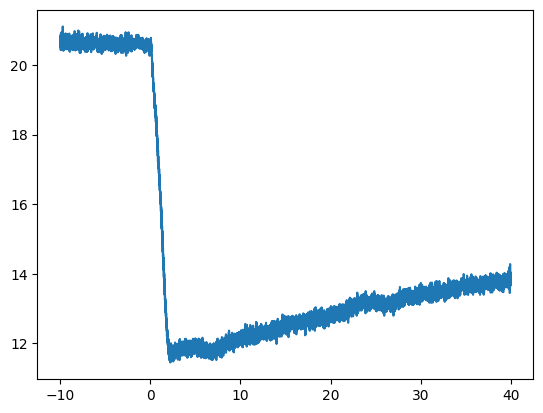

In [253]:
DF=GetWaveForm(73)
plt.errorbar(x=DF["Time"], y=DF[DF.keys()[-1]])

In [302]:
Delay_ana =pd.DataFrame.from_dict(analysis_list).sort_values(by=['Run','fit stepsize','fit diffsize'])
Delay_ana=Delay_ana.drop_duplicates(subset=['Run','fit stepsize','fit diffsize'],keep='last')
Delay_ana


Run                                           Anode P0  Anode Delay Time  \
7    36    [0.9746090324869696, 10.19999977, 18.209999485]         23.331382   
8    37  [1.439498047983269, 6.53599987, 15.10799957500...          6.664255   
9    38      [1.5870640529021354, 6.61599987, 8.597999755]          6.661409   
10   39  [1.843380394779346, 6.67999987, 0.029999995000...          6.630524   
11   40  [2.28815607627187, 6.46799987, 0.3719999900000...          6.572786   
12   41  [2.438526414617549, 6.48399987, 0.357999990000...          6.543688   
3    73  [2.6486340882878032, 9.25599979, 0.61399998499...          9.119977   
4    74       [3.0964667698822264, 9.0479998, 0.601999985]          9.150022   
5    75  [3.8572234550088673, 9.1339998, 0.587999985000...          9.133551   
6    76  [4.560472348625627, 9.1659998, 0.6199999850000...          9.113244   
0   140  [2.0400408505423933, 7.38599985, 0.30599999499...          7.397747   
1   141  [4.437753147925105, 7.40479984, 0.333999995000...          7.406163   
2   142  [1.4037446900624098, 7.47866651, 0.33799999000...          7.440320   

    Anode Delay Sigma  Anode Amp  \
7            0.187724   0.496599   
8            0.216434   1.467917   
9            0.271162   1.525325   
10           0.268305   1.730360   
11           0.304754   2.234848   
12           0.353525   2.299198   
3            0.504266   2.652947   
4            0.480950   3.064841   
5            0.486450   3.899923   
6            0.508452   4.607127   
0            0.239399   2.109873   
1            0.270529   4.501057   
2            0.271607   1.402504   

                                           Cathode P0  fit stepsize  \
7       [-6.679950222665011, 0.73600003, 46.49999868]            50   
8   [-8.786683626222795, 0.81200003, 31.1519991100...            50   
9        [-13.72598379086613, 0.79600003, 0.76799997]            50   
10      [-15.618367187278915, 0.82400003, 0.78799997]            50   
11       [-20.51131735037725, 0.80000003, 0.62399999]            50   
12           [-26.018034200601157, 0.80000003, 0.128]            50   
3   [-5.877816862593895, 1.62400001, 1.77599994999...            50   
4        [-7.433666914455567, 1.58400001, 1.80399995]            50   
5   [-8.409580819113447, 1.65800001, 1.80399995000...            50   
6         [-9.92961442716826, 1.63800001, 1.77599995]            50   
0   [-7.4733056199095715, 2.18599999, 1.9479999399...            50   
1   [-13.599900453330031, 1.9768, 1.9679999400000001]            50   
2         [-5.08973341816222, 2.27066666, 2.09199994]            50   

    fit diffsize  Cathode Delay Time  Cathode Delay Sigma  Cathode Amp  \
7            150            0.720121            -0.243813    -5.110253   
8            150            0.751620             0.297750    -5.695976   
9            150            0.730671             0.260931    -9.509590   
10           150            0.743203             0.275498   -11.684704   
11           150            0.727578             0.268497   -15.254554   
12           150            0.720786             0.268460   -19.865811   
3            150            1.419688             0.654356    -5.601906   
4            150            1.428245             0.661576    -7.196917   
5            150            1.411397             0.661769    -8.388652   
6            150            1.396639             0.663789    -9.783510   
0            150            1.592466             0.711611    -7.252390   
1            150            1.601811             0.738488   -14.086293   
2            150            1.679519             0.745349    -4.587064   

    Drift Field  Extraction Field  pressure   Temp  Laser Current  \
7    500.000000       1092.896175     15.20    NaN           24.5   
8    500.000000       1092.896175     15.20    NaN           25.0   
9    500.000000       1092.896175     15.10    NaN           25.5   
10   500.000000       1092.896175     15.06    NaN           26.0   
1

In [303]:
def line(x,m,b):
    return m*x +b
def square(x,m,b,c):
    return c*x**2+m*x +b


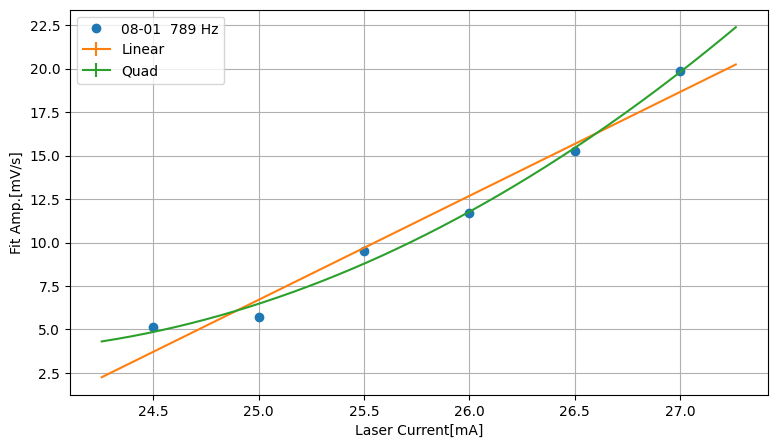

In [309]:
fig,ax= plt.subplots(1, 1, figsize=(9,5))

DF=Delay_ana[:6]


ax.errorbar(x=DF["Laser Current"],y=np.abs(DF["Cathode Amp"]), fmt=" ",marker="o",label="08-01  789 Hz")

xfit=np.arange( np.min(DF["Laser Current"])*0.99,np.max(DF["Laser Current"])*1.01,0.01)
ppot, pcov = curve_fit(line,DF["Laser Current"],np.abs(DF["Cathode Amp"]))
yfit=line(xfit,ppot[0],ppot[1])

ax.errorbar(xfit,yfit, yerr=0.0001, label="Linear")

ppot, pcov = curve_fit(square,DF["Laser Current"],np.abs(DF["Cathode Amp"]))
yfit=square(xfit,ppot[0],ppot[1],ppot[2])

ax.errorbar(xfit,yfit, yerr=0.0001, label="Quad")


# coeff=np.polyfit(DF["Laser Current"],np.abs(DF["Cathode Amp"]),3)
# poly=np.poly1d(coeff)
# yfit=poly(xfit)
# ax.errorbar(xfit,yfit, yerr=0.01, label="Cubic")


# coeff=np.polyfit(DF["Laser Current"],np.abs(DF["Cathode Amp"]),4)
# poly=np.poly1d(coeff)
# yfit=poly(xfit)
# ax.errorbar(xfit,yfit, yerr=0.01, label="Quartic")
# ax.errorbar(x=28,y=5,fmt=" ",label=" ")

# DF=Delay_ana[6:10]


# ax.errorbar(x=DF["Laser Current"],y=np.abs(DF["Cathode Amp"])/DF["Cathode V."], fmt=" ",marker="s",label="09-17 345 Hz")

# xfit=np.arange( np.min(DF["Laser Current"])*0.99,np.max(DF["Laser Current"])*1.01,0.01)
# ppot, pcov = curve_fit(line,DF["Laser Current"],np.abs(DF["Cathode Amp"])/DF["Cathode V."])
# yfit=line(xfit,ppot[0],ppot[1])

# ax.errorbar(xfit,yfit, yerr=0.0001, label="Linear")

# ppot, pcov = curve_fit(square,DF["Laser Current"],np.abs(DF["Cathode Amp"])/DF["Cathode V."])
# yfit=square(xfit,ppot[0],ppot[1],ppot[2])

# ax.errorbar(xfit,yfit, yerr=0.0001, label="Quad")


# coeff=np.polyfit(DF["Laser Current"],np.abs(DF["Cathode Amp"]),3)
# poly=np.poly1d(coeff)
# yfit=poly(xfit)
# ax.errorbar(xfit,yfit, yerr=0.01, label="Cubic")


# coeff=np.polyfit(DF["Laser Current"],np.abs(DF["Cathode Amp"]),4)
# poly=np.poly1d(coeff)
# yfit=poly(xfit)
# ax.errorbar(xfit,yfit, yerr=0.01, label="Quartic")

# DF=Delay_ana[10:]


# ax.errorbar(x=DF["Laser Current"],y=np.abs(DF["Cathode Amp"]), fmt=" ",marker="x",label="10-07 Cold Freq sweep")

# for i,rn in enumerate(DF["Run"]):
#     ax.text((DF["Laser Current"].iloc[i]+0.5),abs(DF["Cathode Amp"].iloc[i]),"Run %i, %0.0fHz"%(rn,DF["Laser Freq."].iloc[i]))


# xfit=np.arange( np.min(DF["Laser Current"])*0.99991,np.max(DF["Laser Current"])*1.0001,0.0001)
# ppot, pcov = curve_fit(line,DF["Laser Current"],np.abs(DF["Cathode Amp"]))
# yfit=line(xfit,ppot[0],ppot[1])

# ax.errorbar(xfit,yfit, yerr=0.1, label="Linear")

# ppot, pcov = curve_fit(square,DF["Laser Current"],np.abs(DF["Cathode Amp"]))
# yfit=square(xfit,ppot[0],ppot[1],ppot[2])

# ax.errorbar(xfit,yfit, yerr=0.01, label="Quad")


# coeff=np.polyfit(DF["Laser Current"],np.abs(DF["Cathode Amp"]),3)
# poly=np.poly1d(coeff)
# yfit=poly(xfit)
# ax.errorbar(xfit,yfit, yerr=0.01, label="Cubic")


# coeff=np.polyfit(DF["Laser Current"],np.abs(DF["Cathode Amp"]),4)
# poly=np.poly1d(coeff)
# yfit=poly(xfit)
# ax.errorbar(xfit,yfit, yerr=0.01, label="Quartic")







ax.grid()
ax.set_xlabel("Laser Current[mA]")
ax.set_ylabel("Fit Amp.[mV/s]")
ax.legend(ncol=1)



# Collection of other data


In [24]:

# Njoya et. al., NIMA 972,21  2020

#Njoya  velocties vs field [mm/us]. [V/cm]
njyl=np.array([1.24,1.31,1.36,1.4,1.64,1.79,1.9,1.99,2.154,2.2685])
njxl=np.array([70,80,90,100,200,300,400,500,750,1000])

njoya_x=njxl
njoya_y=njyl


# Phys. Rev. 166, 871 - data

# L. S. Miller, S. Howe, and W. E. Spear
# Phys. Rev. 166, 871 – Published 15 February 1968
ChT_Vs=np.array([41.368,128.825, 194.984, 395.063, 579.874, 794.328])
ChT_dv= np.array([0.763 ,1.416, 1.59, 1.813, 1.899, 2.052])


# J. Yoo and W.F. Jaskierny 2015 JINST 10 P08011    --Data
AAA = [200, 0.148 , 0.003, 0.181 , 0.003, 1.22,
250, 0.157 , 0.004, 0.200 , 0.004, 1.27,
300, 0.162 , 0.003, 0.227 , 0.004, 1.40,
350, 0.166 , 0.003, 0.245 , 0.005, 1.48,
400, 0.167 , 0.003, 0.255 , 0.004, 1.53,
450, 0.174 , 0.004, 0.266 , 0.004, 1.53,
500, 0.177 , 0.003, 0.274 , 0.004, 1.55,
550, 0.180 , 0.004, 0.288 , 0.005, 1.60,
600, 0.184 , 0.003, 0.302 , 0.006, 1.64,
650, 0.186 , 0.003, 0.325 , 0.006, 1.74,
700, 0.189 , 0.006, 0.343 , 0.005, 1.82,
750, 0.191 , 0.003, 0.357 , 0.005, 1.87,
800, 0.193 , 0.003, 0.382 , 0.007, 1.98,
850, 0.194 , 0.003, 0.390 , 0.007, 2.01,
900, 0.193 , 0.003, 0.397 , 0.006, 2.05]


JINST_2015_dict={}

vs=[]
lds=[]
lds_e=[]
for i in np.arange(0,15,1):
    vs.append(AAA[i*6])
    lds.append(AAA[i*6+1]*10)
    lds_e.append(AAA[i*6+2])
JINST_2015_dict["Voltage"]=vs
JINST_2015_dict["DriftSpeed"]=lds
JINST_2015_dict["Error"]=lds_e


#J. B. Albert et al. (EXO-200 Collaboration) Phys. Rev. C 95, 025502 – Published 14 February 2017
EXO200= np.array([ [614.706, 565.686, 378.431, 186.275, 74.51, 38.235, 19.608],
          [1.981, 1.946, 1.784, 1.576, 1.271, 0.899, 0.484]])






In [138]:
DF["Time"].iloc[15]-DF["Time"].iloc[0]

0.05999999999999872

In [296]:
runs1 =np.arange(194,199,1)
searchstr=""
for run in runs1:
    searchstr= searchstr+" %i,"%(run)
print(searchstr)

rungroup= Delay_ana.query("Run in [%s]"%(searchstr))



rungroup["Drift Distance"] = 9.18

rungroup["Drift Vel"] = rungroup["Drift Distance"]/(rungroup["Anode Delay Time"] -(rungroup["Cathode Delay Time"]+np.abs(rungroup["Cathode Delay Sigma"])))
for run in runs1:
    rungroup.loc[rungroup.query("Run == %s"%(run)).index,"Drift Vel Avg"]=np.average(rungroup.query("Run == %s"%(run))["Drift Vel"])
    rungroup.loc[rungroup.query("Run == %s"%(run)).index,"Drift Vel std"]=np.std(rungroup.query("Run == %s"%(run))["Drift Vel"])

rungroup1=rungroup

 194, 195, 196, 197, 198,


C:\Users\jasonbane\AppData\Local\Temp\ipykernel_23120\1507858305.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rungroup["Drift Distance"] = 9.18
C:\Users\jasonbane\AppData\Local\Temp\ipykernel_23120\1507858305.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rungroup["Drift Vel"] = rungroup["Drift Distance"]/(rungroup["Anode Delay Time"] -(rungroup["Cathode Delay Time"]+np.abs(rungroup["Cathode Delay Sigma"])))
C:\Users\jasonbane\AppData\Local\Temp\ipykernel_23120\1507858305.py:15: SettingWithCop

In [310]:
runs2 =np.arange(176,194,1)
searchstr=""
for run in runs2:
    searchstr= searchstr+" %i,"%(run)

searchstr=searchstr.replace(" 183,","")
print(searchstr)

rungroup= Delay_ana.query("Run in [%s]"%(searchstr))



rungroup["Drift Distance"] = 9.18

rungroup["Drift Vel"] = rungroup["Drift Distance"]/(rungroup["Anode Delay Time"] -(rungroup["Cathode Delay Time"]+np.abs(rungroup["Cathode Delay Sigma"])))
for run in runs2:
    rungroup.loc[rungroup.query("Run == %s"%(run)).index,"Drift Vel Avg"]=np.average(rungroup.query("Run == %s"%(run))["Drift Vel"])
    rungroup.loc[rungroup.query("Run == %s"%(run)).index,"Drift Vel std"]=np.std(rungroup.query("Run == %s"%(run))["Drift Vel"])

rungroup2=rungroup

 176, 177, 178, 179, 180, 181, 182, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,


C:\Users\jasonbane\AppData\Local\Temp\ipykernel_23120\3835954432.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rungroup["Drift Distance"] = 9.18
C:\Users\jasonbane\AppData\Local\Temp\ipykernel_23120\3835954432.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rungroup["Drift Vel"] = rungroup["Drift Distance"]/(rungroup["Anode Delay Time"] -(rungroup["Cathode Delay Time"]+np.abs(rungroup["Cathode Delay Sigma"])))
C:\Users\jasonbane\AppData\Local\Temp\ipykernel_23120\3835954432.py:17: SettingWithCop

In [293]:


runs3 =[144,145,146]
searchstr=""
for run in runs3:
    searchstr= searchstr+" %i,"%(run)
print(searchstr)

rungroup= Delay_ana.query("Run in [%s]"%(searchstr))



rungroup["Drift Distance"] = 9.18

rungroup["Drift Vel"] = rungroup["Drift Distance"]/(rungroup["Anode Delay Time"] -(rungroup["Cathode Delay Time"]+np.abs(rungroup["Cathode Delay Sigma"])))

for run in runs3:
    rungroup.loc[rungroup.query("Run == %s"%(run)).index,"Drift Vel Avg"]=np.average(rungroup.query("Run == %s"%(run))["Drift Vel"])
    rungroup.loc[rungroup.query("Run == %s"%(run)).index,"Drift Vel std"]=np.std(rungroup.query("Run == %s"%(run))["Drift Vel"])



rungroup3=rungroup

 144, 145, 146,


C:\Users\jasonbane\AppData\Local\Temp\ipykernel_23120\317741829.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rungroup["Drift Distance"] = 9.18
C:\Users\jasonbane\AppData\Local\Temp\ipykernel_23120\317741829.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rungroup["Drift Vel"] = rungroup["Drift Distance"]/(rungroup["Anode Delay Time"] -(rungroup["Cathode Delay Time"]+np.abs(rungroup["Cathode Delay Sigma"])))
C:\Users\jasonbane\AppData\Local\Temp\ipykernel_23120\317741829.py:16: SettingWithCopyWa

In [416]:

runs_ext =[171,172,173,174,175]
searchstr=""
for run in runs_ext:
    searchstr= searchstr+" %i,"%(run)
print(searchstr)

rungroup= Delay_ana.query("Run in [%s]"%(searchstr))



#rungroup["Drift Distance"] = 9.18

rungroup.loc[:,"Drift Vel"] = rungroup["Drift Length"]/(rungroup["Anode Delay Time"] -(rungroup["Cathode Delay Time"]+np.abs(rungroup["Cathode Delay Sigma"])))

for run in runs_ext:
    rungroup.loc[rungroup.query("Run == %s"%(run)).index,"Drift Vel Avg"]=np.average(rungroup.query("Run == %s"%(run))["Drift Vel"])
    rungroup.loc[rungroup.query("Run == %s"%(run)).index,"Drift Vel std"]=np.std(rungroup.query("Run == %s"%(run))["Drift Vel"])



rungroup_ext=rungroup

 171, 172, 173, 174, 175,


KeyError: 'Drift Length'

In [295]:
rungroup_ext[:3]

Run                                           Anode P0  Anode Delay Time  \
128  171  [4.565312678332514, 7.98199983, 0.012000000000...          8.017099   
164  171  [3.8223243680595473, 8.14599982, 0.29399999500...          8.147000   
200  171  [3.517000117233343, 8.23799982, 0.291999989999...          8.191705   

     Anode Delay Sigma  Anode Amp  \
128           0.196997   4.286628   
164           0.222758   3.640394   
200           0.236470   3.376517   

                                            Cathode P0  fit stepsize  \
128  [-552.480880956282, 0.82600003, 0.975999969999...             1   
164  [-546.7157635435841, 0.91400003, 0.96399997000...             1   
200  [-542.015284733843, 1.00200003, 0.971999969999...             1   

     fit diffsize  Cathode Delay Time  Cathode Delay Sigma  Cathode Amp  \
128            64            0.786494             0.356676  -612.545222   
164           128            0.914747             0.370444  -582.197848   
200           150            0.958895             0.378536  -567.190679   

     Drift Field  Extraction Field  pressure   Temp  Drift Distance  \
128   401.969365       3997.814208      23.9  173.3            9.18   
164   401.969365       3997.814208      23.9  173.3            9.18   
200   401.969365       3997.814208      23.9  173.3            9.18   

     Drift Vel  Drift Vel Avg  Drift Vel std  
128   1.335481       1.337544       0.001577  
164   1.337840       1.337544       0.001577  
200   1.339310       1.337544       0.001577

In [322]:
rungroup2[-5:]

Run                                           Anode P0  Anode Delay Time  \
185  192  [3.9333595286468666, 9.0079998, 0.032000000000...          9.008000   
221  192  [3.87553346251778, 8.9359998, 0.03000000000000...          8.936000   
150  193  [2.9919923043747207, 9.56399978, 0.26799998999...          9.564000   
186  193  [2.4435743142021216, 9.72799978, 0.08599999499...          9.728000   
222  193  [2.331466744382235, 9.58399978, 0.453999985000...          9.590164   

     Anode Delay Sigma  Anode Amp  \
185           0.032000   3.933360   
221           0.030000   3.875533   
150           0.268000   2.991992   
186           0.086000   2.443574   
222           0.414056   2.107148   

                                            Cathode P0  fit stepsize  \
185    [-19.62378592280418, 1.884, 1.7679999499999999]             1   
221            [-19.452182315072754, 1.86, 1.71199995]             1   
150      [-16.351445951228392, 0.28800005, 2.05999994]             1   
186      [-12.747570810452013, 0.91200003, 1.89999995]             1   
222  [-11.449468714982295, 1.27200002, 1.8159999500...             1   

     fit diffsize  Cathode Delay Time  Cathode Delay Sigma  Cathode Amp  \
185           128            1.487266             0.621737   -19.869464   
221           150            1.529729             0.625730   -19.700711   
150            64            1.448088             0.659808   -11.832222   
186           128            1.573486             0.666149   -11.665745   
222           150            1.616250             0.669439   -11.583226   

     Drift Field  Extraction Field  pressure   Temp  Drift Distance  \
185   297.413793        295.081967      23.6  173.2            9.18   
221   297.413793        295.081967      23.6  173.2            9.18   
150   198.275862        196.721311      23.6  173.2            9.18   
186   198.275862        196.721311      23.6  173.2            9.18   
222   198.275862        196.721311      23.6  173.2            9.18   

     Drift Vel  Drift Vel Avg  Drift Vel std  
185   1.330628       1.346200       0.011011  
221   1.353874       1.346200       0.011011  
150   1.231206       1.237957       0.013473  
186   1.225902       1.237957       0.013473  
222   1.256764       1.237957       0.013473

# using the analysis list to plot drift velocities

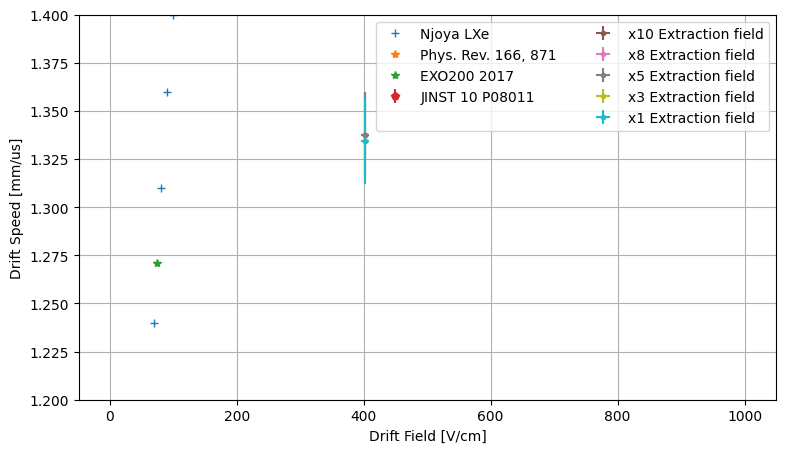

In [291]:
fig,ax= plt.subplots(1, 1, figsize=(9,5))


#print(bx)
colors=["r","blue","darkgrey","green","cyan","purple"]
marker=["o","x","p","s","h","*"]
markersize=7

sec=0





ax.errorbar(x=njoya_x,y=njoya_y,fmt=" ",marker="+",label="Njoya LXe")

ax.errorbar(x=ChT_Vs,y=ChT_dv,fmt=" ", marker="*",label="Phys. Rev. 166, 871 ")

ax.errorbar(x=EXO200[0],y=EXO200[1],fmt=" ", marker="*",label="EXO200 2017")


ax.errorbar(x= JINST_2015_dict["Voltage"],y=JINST_2015_dict["DriftSpeed"],fmt=" ",marker="p",
            yerr=JINST_2015_dict["Error"],label="JINST 10 P08011 ")
ax.errorbar(x=1, y=1, fmt=" ", marker=".", markersize=0.001,label=" ")
# ax.errorbar(x=1, y=1, fmt=" ", marker=".", markersize=0.001,label=" ")



# ax.errorbar( x = rungroup2["Drift Field"] , y=rungroup2["Drift Vel Avg"],
#             xerr= np.sqrt((0.001)**2 + (0.15/9.185)**2)*rungroup2["Drift Field"],
#             yerr= np.sqrt((rungroup2["Drift Vel std"]*2/rungroup2["Drift Vel Avg"])**2 + (0.15/9.185)**2)*rungroup2["Drift Vel Avg"],
#              fmt =" ",marker=".", label="UMass 11th 1x Ext")



# ax.errorbar( x = rungroup1["Drift Field"] , y=rungroup1["Drift Vel Avg"],
#              xerr= np.sqrt((0.001)**2 + (0.15/9.185)**2)*rungroup1["Drift Field"],
#              yerr= np.sqrt((rungroup1["Drift Vel std"]*2/rungroup1["Drift Vel Avg"])**2 + (0.15/9.185)**2)*rungroup1["Drift Vel Avg"],
#              fmt =" ",marker=".", label="UMass 11th 3x Ext")



# ax.errorbar( x = rungroup3["Drift Field"] , y=rungroup3["Drift Vel Avg"],
#             xerr= np.sqrt((0.001)**2 + (0.15/9.185)**2)*rungroup3["Drift Field"], 
#             yerr= np.sqrt((rungroup3["Drift Vel std"]*2/rungroup3["Drift Vel Avg"])**2 + (0.15/9.185)**2)*rungroup3["Drift Vel Avg"],
#              fmt =" ",marker=".", label="UMass 7th 3x Ext")

extlist=[10,8,5,3,1]
DF=rungroup_ext
for i in np.arange(0,len(runs_ext),1):
    ax.errorbar( x = DF["Drift Field"].iloc[i], y=DF["Drift Vel Avg"].iloc[i],
            xerr= np.sqrt((0.001)**2 + (0.15/9.185)**2)*DF["Drift Field"].iloc[i], 
            yerr= np.sqrt((DF["Drift Vel std"].iloc[i]*2/DF["Drift Vel Avg"].iloc[i])**2 + (0.15/9.185)**2)*DF["Drift Vel Avg"].iloc[i],
              fmt =" ",marker=".", label="x%i Extraction field"%(extlist[i]))

ax.set_ylabel("Drift Speed [mm/us]")
ax.set_xlabel("Drift Field [V/cm]")


ax.set_ylim(1.2,1.4)
ax.grid()
ax.legend(ncol=2)#,loc="upper left")

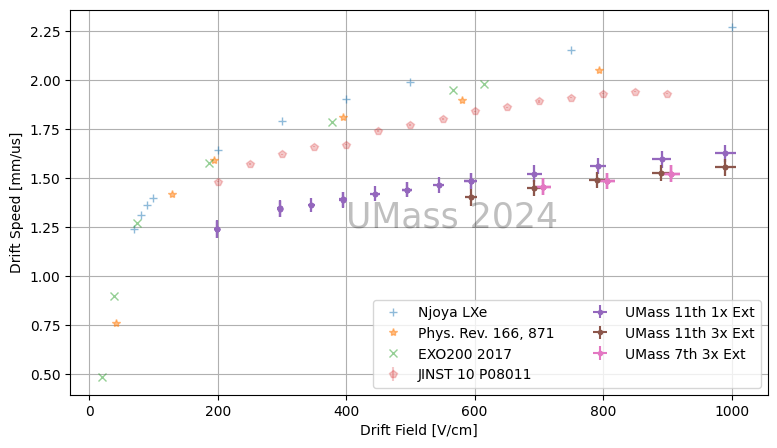

In [324]:
fig,ax= plt.subplots(1, 1, figsize=(9,5))


#print(bx)
colors=["r","blue","darkgrey","green","cyan","purple"]
marker=["o","x","p","s","h","*"]
markersize=7

sec=0





ax.errorbar(x=njoya_x,y=njoya_y,fmt=" ",marker="+",alpha=0.5,label="Njoya LXe")

ax.errorbar(x=ChT_Vs,y=ChT_dv,fmt=" ", marker="*",alpha=0.5,label="Phys. Rev. 166, 871 ")

ax.errorbar(x=EXO200[0],y=EXO200[1],fmt=" ", marker="x",alpha=0.5,label="EXO200 2017")


ax.errorbar(x= JINST_2015_dict["Voltage"],y=JINST_2015_dict["DriftSpeed"],fmt=" ",marker="p",
            yerr=JINST_2015_dict["Error"],alpha=0.25,label="JINST 10 P08011 ")
# ax.errorbar(x=1, y=1, fmt=" ", marker=".", markersize=0.001,label=" ")
# ax.errorbar(x=1, y=1, fmt=" ", marker=".", markersize=0.001,label=" ")



ax.errorbar( x = rungroup2["Drift Field"] , y=rungroup2["Drift Vel Avg"],
            xerr= np.sqrt((0.001)**2 + (0.15/9.185)**2)*rungroup2["Drift Field"],
            yerr= np.sqrt((rungroup2["Drift Vel std"]*2/rungroup2["Drift Vel Avg"])**2 + (0.25/9.185)**2)*rungroup2["Drift Vel Avg"],
             fmt =" ",marker=".", label="UMass 11th 1x Ext")



ax.errorbar( x = rungroup1["Drift Field"] , y=rungroup1["Drift Vel Avg"],
             xerr= np.sqrt((0.001)**2 + (0.15/9.185)**2)*rungroup1["Drift Field"],
             yerr= np.sqrt((rungroup1["Drift Vel std"]*2/rungroup1["Drift Vel Avg"])**2 + (0.25/9.185)**2)*rungroup1["Drift Vel Avg"],
             fmt =" ",marker=".", label="UMass 11th 3x Ext")





ax.errorbar( x = rungroup3["Drift Field"]+10 , y=rungroup3["Drift Vel Avg"],
            xerr= np.sqrt((0.001)**2 + (0.15/9.185)**2)*rungroup3["Drift Field"], 
            yerr= np.sqrt((rungroup3["Drift Vel std"]*2/rungroup3["Drift Vel Avg"])**2 + (0.25/9.185)**2)*rungroup3["Drift Vel Avg"],
             fmt =" ",marker=".", label="UMass 7th 3x Ext")
# ax.errorbar( x = rungroup3["Drift Field"] , y=rungroup3["Drift Vel Avg"],
#             xerr= np.sqrt((0.001)**2 + (0.15/9.185)**2)*rungroup3["Drift Field"], 
#             yerr= np.sqrt((rungroup3["Drift Vel std"]/rungroup3["Drift Vel Avg"])**2 + (0.15/9.185)**2)*rungroup3["Drift Vel Avg"],
#              fmt =" ",marker=".", label="UMass 7th 3x Ext")

# extlist=[10,8,5,3,1]
# DF=rungroup_ext
# for i in np.arange(0,len(runs_ext),1):
#     ax.errorbar( x = DF["Drift Field"].iloc[i], y=DF["Drift Vel Avg"].iloc[i],
#             xerr= np.sqrt((0.001)**2 + (0.15/9.185)**2)*DF["Drift Field"].iloc[i], 
#             yerr= np.sqrt((DF["Drift Vel std"].iloc[i]*2/DF["Drift Vel Avg"].iloc[i])**2 + (0.15/9.185)**2)*DF["Drift Vel Avg"].iloc[i],
#               fmt =" ",marker=".", label="x%i Extraction field"%(extlist[i]))

ax.set_ylabel("Drift Speed [mm/us]")
ax.set_xlabel("Drift Field [V/cm]")

ax.text(400,1.25, "UMass 2024",size=25,alpha=0.25)

#ax.set_ylim(1.2,1.91)
ax.grid()
ax.legend(ncol=2)#,loc="upper left")

In [273]:
rungroup3[-5:]

Run                                           Anode P0  Anode Delay Time  \
19   146  [5.337269739737113, 7.31279985, 0.299999994999...          7.354352   
23   146  [4.816800160560009, 7.40079984, 0.329999995000...          7.397904   
95   146  [6.199140867153958, 7.25279985, 0.247999989999...          7.246937   
99   146  [5.223632039985638, 7.35279985, 0.002000000000...          7.374338   
103  146  [4.782321826077397, 7.40079984, 0.335999989999...          7.417881   

     Anode Delay Sigma  Anode Amp  \
19            0.251380   5.192994   
23            0.269443   4.844455   
95            0.213527   6.109674   
99            0.252055   5.177846   
103           0.270036   4.832478   

                                            Cathode P0  fit stepsize  \
19       [-209.26838708079686, 1.08480002, 1.01199997]            10   
23   [-207.90613526353792, 1.06080002, 1.0159999700...            10   
95   [-211.44321138450098, 0.92880003, 0.0040000000...            20   
99       [-209.26838708079686, 1.08480002, 1.01199997]            20   
103  [-207.90613526353792, 1.06080002, 1.0159999700...            20   

     fit diffsize  Cathode Delay Time  Cathode Delay Sigma  Cathode Amp  \
19            128            0.939662             0.385122  -226.396444   
23            150            0.983552             0.392489  -221.114515   
95             64            0.811986             0.372605  -237.003592   
99            128            0.939662             0.385122  -226.396444   
103           150            0.983552             0.392489  -221.114515   

     Drift Field  Extraction Field  pressure   Temp  Drift Distance  \
19    895.590637       2701.639344      23.7  173.0            9.18   
23    895.590637       2701.639344      23.7  173.0            9.18   
95    895.590637       2701.639344      23.7  173.0            9.18   
99    895.590637       2701.639344      23.7  173.0            9.18   
103   895.590637       2701.639344      23.7  173.0            9.18   

     Drift Vel  Drift Vel Avg  Drift Vel std  
19    1.522497       1.521914       0.004456  
23    1.524445       1.521914       0.004456  
95    1.514265       1.521914       0.004456  
99    1.517467       1.521914       0.004456  
103   1.519405       1.521914       0.004456

<ErrorbarContainer object of 3 artists>

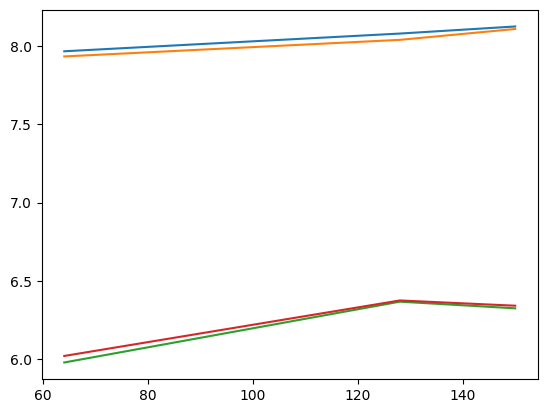

In [281]:
DF = rungroup3.query("Run == 143 and `fit stepsize` == 40")
plt.errorbar( x =DF["fit diffsize"] , y=DF["Anode Delay Time"])  


# DF = rungroup3.query("Run == 143 and `fit stepsize` == 30")
# plt.errorbar( x =DF["fit diffsize"] , y=DF["Anode Delay Time"])   

DF = rungroup3.query("Run == 143 and `fit stepsize` == 20")
plt.errorbar( x =DF["fit diffsize"] , y=DF["Anode Delay Time"])            

DF = rungroup3.query("Run == 143 and `fit stepsize` == 10")
plt.errorbar( x =DF["fit diffsize"] , y=DF["Anode Delay Time"]) 

DF = rungroup3.query("Run == 143 and `fit stepsize` == 1")
plt.errorbar( x =DF["fit diffsize"] , y=DF["Anode Delay Time"])            

<ErrorbarContainer object of 3 artists>

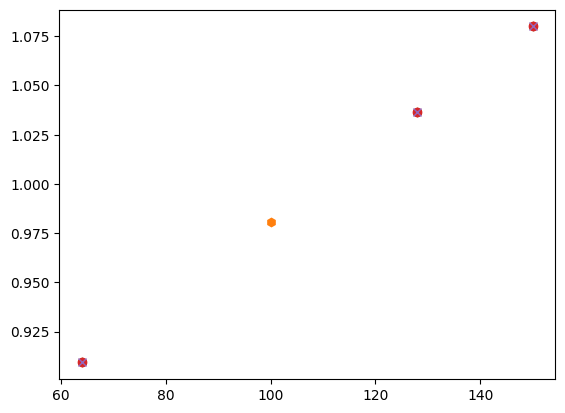

In [274]:
DF = rungroup3.query("Run == 143 and `fit stepsize` == 40")

plt.errorbar( x =DF["fit diffsize"] , y=DF["Cathode Delay Time"],fmt =" ",marker="h")  

DF = rungroup3.query("Run == 143 and `fit stepsize` == 30")

plt.errorbar( x =DF["fit diffsize"] , y=DF["Cathode Delay Time"],fmt =" ",marker="h")   

DF = rungroup3.query("Run == 143 and `fit stepsize` == 20")

plt.errorbar( x =DF["fit diffsize"] , y=DF["Cathode Delay Time"],fmt =" ",marker="+")            
DF = rungroup3.query("Run == 143 and `fit stepsize` == 10")

plt.errorbar( x =DF["fit diffsize"] , y=DF["Cathode Delay Time"],fmt =" ",marker="o") 
DF = rungroup3.query("Run == 143 and `fit stepsize` == 1")

plt.errorbar( x =DF["fit diffsize"] , y=DF["Cathode Delay Time"],fmt =" ",marker="x")          

In [276]:
import wget,requests
Pressure,TempHigh,TempLow,TempStep)
url ="https://webbook.nist.gov/cgi/fluid.cgi?Action=Data&Wide=on&ID=C7440633&Type=IsoBar&Digits=5&P=%0.2f&THigh=%0.2f&TLow=%0.2f&TInc=%0.2f&RefState=DEF&TUnit=K&PUnit=psia&DUnit=g%%2Fml&HUnit=kJ%%2Fmol&WUnit=m%%2Fs&VisUnit=uPa*s&STUnit=N%%2Fm"%(Pressure,TempHigh,TempLow,TempStep)

In [278]:
density=2.8884 #[g/ml] # Average for 173K 22.6-26psia
M=131.29  #[g/mol]
NA = 6.022*10**(23) #[1/mol]


N=(density/M * NA)

N

1.324849173585193e+22

In [ ]:
fig,ax= plt.subplots(1, 1, figsize=(9,5))


#print(bx)
colors=["r","blue","darkgrey","green","cyan","purple"]
marker=["o","x","p","s","h","*"]
markersize=7

sec=0





ax.errorbar(x=njoya_x,y=njoya_y,yerr=0.025,fmt=" ",marker="+",label="Njoya LXe")

ax.errorbar(x=ChT_Vs,y=ChT_dv,yerr=0.025,fmt=" ", marker="*",label="Phys. Rev. 166, 871 ")

ax.errorbar(x= JINST_2015_dict["Voltage"],y=JINST_2015_dict["DriftSpeed"],fmt=" ",marker="p",
            yerr=JINST_2015_dict["Error"],label="JINST 10 P08011 ")

ax.errorbar( x = rungroup["Drift Field"] , y=rungroup["Drift Vel"], fmt =" ",marker=".", label="UMass 20241011")

ax.set_ylabel("Drift Speed [mm/us]")
ax.set_xlabel("Drift Field [V/cm]")


#ax.set_ylim(0.1,2.42)
ax.grid()
ax.legend(ncol=2)

# Runs 154,153,156

In [ ]:
fig,ax= plt.subplots(1, 1, figsize=(9,5))


#print(bx)
colors=["r","blue","darkgrey","green","cyan","purple"]
marker=["o","x","p","s","h","*"]
markersize=7

sec=0





ax.errorbar(x=njoya_x,y=njoya_y,yerr=0.025,fmt=" ",marker="+",label="Njoya LXe")

ax.errorbar(x=ChT_Vs,y=ChT_dv,yerr=0.025,fmt=" ", marker="*",label="Phys. Rev. 166, 871 ")

ax.errorbar(x= JINST_2015_dict["Voltage"],y=JINST_2015_dict["DriftSpeed"],fmt=" ",marker="p",
            yerr=JINST_2015_dict["Error"],label="JINST 10 P08011 ")

ax.errorbar( x = rungroup["Drift Field"] , y=rungroup["Drift Vel"], fmt =" ",marker=".", label="UMass 20241011")

ax.set_ylabel("Drift Speed [mm/us]")
ax.set_xlabel("Drift Field [V/cm]")


#ax.set_ylim(0.1,2.42)
ax.grid()
ax.legend(ncol=2)

## Oct 7th data

154
12502 12503
Not equal
Run 00154   Field 1088.731628  time Delay  7.52133317
2.04933333
0



153
12502 12502
Run 00153   Field 1088.731628  time Delay  7.57599984
2.30799999
1



156
12502 12502
Run 00156   Field 1088.731628  time Delay  7.67333317
2.47733332
2



cath
[2.04933333, 2.30799999, 2.47733332]
anode
[7.52133317, 7.57599984, 7.67333317]
Drift time
[5.47199984 5.26799985 5.19599985]
[1088.7316276537833, 1088.7316276537833, 1088.7316276537833]


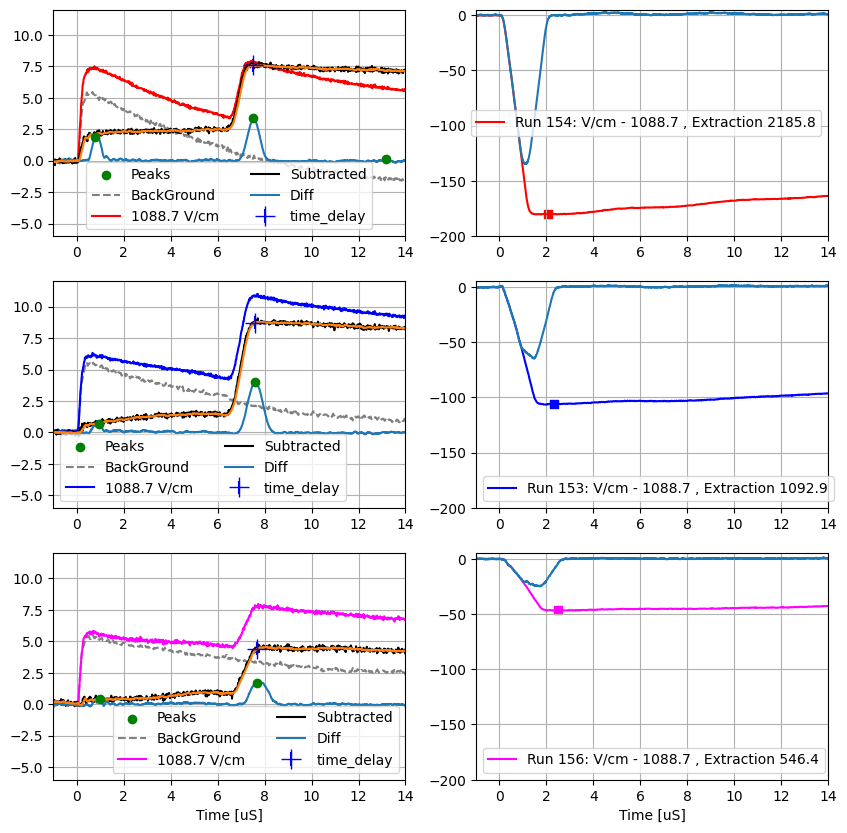

In [366]:

wafeform_path="C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/data/waveforms/" # Path for data On left pc

dates =     [20241007,20241007,20241007]
runnumbers= [154,153,156]
labels=[400,500,500,400,400,500,600,700]
bg_runs = [164,163,166]
c=["red","blue","magenta","cyan","brown","grey","skyblue","teal"]

chann_names=["Avg Cathode","Avg Anode"]

anode_time_delay=[]
catho_delay=[]
drift_field_list=[]
fig, axs = plt.subplots(len(runnumbers), 2,figsize=(10,10))


for i,rn  in enumerate(runnumbers):
    
    RI = GetRunInfo(rn)
    
    waveform_date ="%i"%(RI["Date"].iloc[0])
    runnumber="00%i"%(rn)
    stepcount=5
    waveform_dir=wafeform_path+waveform_date+"/"+waveform_date+"-"+runnumber
    waveform_wavenumber="10"
    waveform_filename=waveform_date+"-"+runnumber+"_"+waveform_wavenumber
    waveform_fullpath=waveform_dir+"/"+waveform_filename+".csv"
    DF=pd.read_csv(waveform_fullpath,skiprows=[1])
    
    print(rn)

    ###Background

    bg_runnumber="00%i"%(bg_runs[i])
    BG_dir =wafeform_path +waveform_date+"/"+waveform_date+"-"+bg_runnumber
    bg_filename=waveform_date+"-"+bg_runnumber+"_"+waveform_wavenumber
    bg_fullpath= BG_dir + "/"+bg_filename + ".csv"
    bgDF=pd.read_csv(bg_fullpath,skiprows=[1])
    bg_anodenorm=np.average(bgDF[chann_names[1]][:100])
    ####



    drift_field = RI["Drift Field"].iloc[0]#RI["Cathode Grid V."].iloc[0]/(9.14/10)
    extract_field=RI["Extraction Field"].iloc[0]


    #print(drift_field)

    anodenorm=np.average(DF[chann_names[1]][:100])
    cathnorm=np.average(DF[chann_names[0]][:100])

    bg_norm=1# np.max(DF[chann_names[1]][::stepcount] - anodenorm) / np.max(bgDF[chann_names[1]][::stepcount*2] - bg_anodenorm)



    bg_y=(bgDF[chann_names[1]]- bg_anodenorm)*bg_norm


    sub = (DF[chann_names[1]] - anodenorm) - bg_y
    
    ##BG
    axs[i][0].errorbar(x=bgDF["Time"][::stepcount*2], fmt="--",
        y=(bgDF[chann_names[1]][::stepcount*2] - bg_anodenorm)*bg_norm, 
        color="grey", label="BackGround")
    ##

    axs[i][0].errorbar(x=DF["Time"][::stepcount],y=DF[chann_names[1]][::stepcount] - anodenorm, color= c[i], label="%0.1f V/cm "%(drift_field))
    
    #axs[1].errorbar(x=DF["Time"][::stepcount],y=DF["average(Cathode)"][::stepcount] - cathnorm, color= c[i], label="%i V/cm"%(labels[i]))
    
    ## Plot subtracted version
    axs[i][0].errorbar(x = DF["Time"][::stepcount],y=sub[::stepcount] , color="black", label="Subtracted")

    

    stepsize=25
    diffsize=100

    xdata=np.array(DF["Time"])
    ydata= sub                 #DF[chann_names[1]]-np.average(DF[chann_names[1]][:20])
    yrolling= sub.rolling(stepsize).mean()              #ydata.rolling(stepsize).mean()
    yprime=np.roll(np.array(yrolling.diff(diffsize)),diffsize)
    ydata_nparray=np.array(ydata)



    local_minima_indices = argrelextrema(np.array(yprime), np.greater,order=1050)
    #local_minima_indices = argrelextrema(np.array(yprime), np.less,order=350)

    #print(local_minima_indices)
    # Get the x and y values of the local minima
    x_minima = xdata[local_minima_indices]
    y_minima = yprime[local_minima_indices]
    axs[i][0].scatter(x_minima, y_minima, color='green', label='Peaks', zorder=5)


    print(len(xdata),len(yprime))

    if len(xdata) == len(yprime):
        axs[i][0].errorbar(xdata,yprime,label="Diff")
        axs[i][0].errorbar(xdata,yrolling)#,label="Smoothing")
    else :
        print("Not equal")
        max_ind= int(np.min([len(xdata),len(yprime)]))
        axs[i][0].errorbar(xdata[:max_ind],yprime[:max_ind],label="Diff")
        axs[i][0].errorbar(xdata[:max_ind],yrolling[:max_ind])#,label="Smoothing")
    
    
    ydata_minima = ydata_nparray[local_minima_indices[0][0]]
    #axs[i].scatter(x_minima[1], ydata_minima, color=c[i])
    
    time_delay_ind=0
    time_delay=xdata[np.array(local_minima_indices)[0][0]]
    while time_delay <3.5 :
        time_delay_ind=1 +time_delay_ind
        time_delay=xdata[np.array(local_minima_indices)[0][time_delay_ind]]
        if time_delay_ind > len(np.array(local_minima_indices)[0]) -1:
            print("Breaking out of while loop")
            break
        

    print("Run %s"%(runnumber), "  Field %f"%(drift_field) , " time Delay ",xdata[np.array(local_minima_indices)[0][time_delay_ind]] )


    anode_time_delay.append(xdata[np.array(local_minima_indices)[0][time_delay_ind]])
    ydata_minima = ydata_nparray[local_minima_indices[0][time_delay_ind]]


    #print( x_minima[time_delay_ind], ydata_minima )
    axs[i][0].errorbar(x_minima[time_delay_ind], ydata_minima,yerr=0.5, markersize=15,
                       fmt=" ", marker="+", color="blue", label="time_delay")



    axs[i][0].grid()
    axs[i][0].legend()

##cathods

    axs[i][1].errorbar(x=DF["Time"][::stepcount],y=DF[chann_names[0]][::stepcount] - cathnorm, color= c[i]
                       , label="Run %i: V/cm - %0.1f , Extraction %0.1f"%(rn, drift_field,extract_field))
    axs[i][1].grid()
    axs[i][1].legend()

    Time=np.array(DF["Time"])
    Cath =DF[chann_names[0]] - cathnorm
    diff = Cath.diff(200)

    axs[i][1].errorbar(Time,diff,label="Diff")


    #cond= np.abs(diff)== np.max(np.abs(diff))
    cond= np.abs(diff)>=5


    print(Time[np.where(cond)][-1])
    cd=Time[np.where(cond)][-1]
    cd_amp=np.array(Cath.iloc[np.where(cond)])[-1]
    catho_delay.append(cd)
    

    axs[i][1].scatter(cd,cd_amp,marker="s",color=c[i])
    #catho_delay.append(Time[np.where(Cath == Cath_min)][0])
    #axs[i].set_xlim(-1,3)
    drift_field_list.append(drift_field)
    print(i)
    axs[i][0].legend(ncol=2)

    axs[i][1].set_xlim(-1,14)

    axs[i][0].set_xlim(-1,14)
    axs[i][0].set_ylim(-6,12)

    axs[i][1].set_ylim(-200,5)

    print("\n\n")

axs[i][1].set_xlabel("Time [uS]")




print("cath")
print(catho_delay)
print("anode")
print(anode_time_delay)

Drift_time=np.array(anode_time_delay)-np.array(catho_delay)

print("Drift time")
print(Drift_time)
print(drift_field_list)



    

#axs[0].set_xlabel("Time [uS]")
#axs[0].set_ylabel("Preamp Signal [mV]")

#axs[0].grid()
#axs[0][0].set_ylim(-5,8)


axs[i][0].set_xlabel("Time [uS]")
#axs[1].set_ylabel("Preamp Signal [mV]")
#axs[1].grid()
#axs[1].legend()

    #plt.title("Signal on 20240926")
#plt.xlim(-1000,10000)
drift_time_Oct7th_v3=np.array(Drift_time)
drift_field_list_Oct7th_v3=drift_field_list

In [369]:
drift_field_list_Oct7th_v3, 9.185/drift_time_Oct7th_v3

([1088.7316276537833, 1088.7316276537833, 1088.7316276537833],
 array([1.67854537, 1.74354599, 1.76770598]))

In [331]:
xdata[100]-xdata[0]

0.39999998999999953

NameError: name 'drift_field_list_Oct7th_v2' is not defined

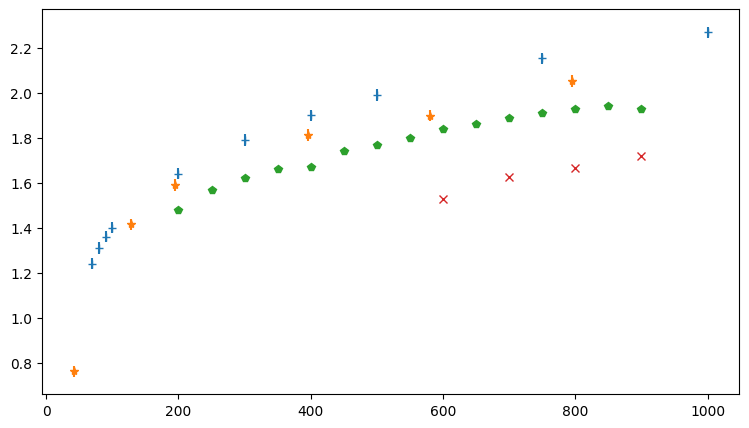

In [536]:
fig,ax= plt.subplots(1, 1, figsize=(9,5))


#print(bx)
colors=["r","blue","darkgrey","green","cyan","purple"]
marker=["o","x","p","s","h","*"]
markersize=7

sec=0

##Njoya liquid data
#njoya_y1=np.array([20,20/1.1,20/1.3,20/1.4,20/1.5,20/1.7])-1
#njoya_y2=np.array([20,20/1.1,20/1.3,20/1.4,20/1.5,20/1.7])+1
njyl=np.array([1.24,1.31,1.36,1.4,1.64,1.79,1.9,1.99,2.154,2.2685])
njxl=np.array([70,80,90,100,200,300,400,500,750,1000])
#njoya_x=[200*2,200*2,300*2,400*2,500*2,1000*2]

njoya_x=njxl
njoya_y=njyl


ax.errorbar(x=njoya_x,y=njoya_y,yerr=0.025,fmt=" ",marker="+",label="Njoya LXe")

ax.errorbar(x=ChT_Vs,y=ChT_dv,yerr=0.025,fmt=" ", marker="*",label="Phys. Rev. 166, 871 ")

ax.errorbar(x= JINST_2015_dict["Voltage"],y=JINST_2015_dict["DriftSpeed"],fmt=" ",marker="p",
            yerr=JINST_2015_dict["Error"],label="JINST 10 P08011 ")



voltages_raw=np.array(labels)

offset=[0,0,0,0]


ax.errorbar(x=drift_field_list_Oct7th_v1,
            y=9.185/drift_time_Oct7th_v1
           # ,xerr=drift_field_error[3:]
           #,yerr=delta_v_1[3:]
           ,fmt=" ",marker="x",label="UMass LXe 20241007")


ax.errorbar(x=drift_field_list_Oct7th_v2[:1],
            y=9.185/drift_time_Oct7th_v2[:1]
           # ,xerr=drift_field_error[3:]
           #,yerr=delta_v_1[3:]
           ,fmt=" ",marker="x",label="UMass LXe 20241007 - extraction 1X")
ax.errorbar(x=drift_field_list_Oct7th_v2[1:],
            y=9.185/drift_time_Oct7th_v2[1:]
           # ,xerr=drift_field_error[3:]
           #,yerr=delta_v_1[3:]
           ,fmt=" ",marker="x",label="UMass LXe 20241007 - extraction 3X")



ax.errorbar(x=drift_field_list_Oct7th_v3,
            y=9.185/drift_time_Oct7th_v3
           # ,xerr=drift_field_error[3:]
           #,yerr=delta_v_1[3:]
           ,fmt=" ",marker="x",label="UMass LXe 20241007")




ax.errorbar(x=voltages_raw[3:]+offset[3:],y=9.14/drift_time_LXe_Sept[3:]
            ,xerr=drift_field_error[3:]
           ,yerr=delta_v_1[3:],fmt=" ",marker="x",label="UMass LXe 20240926")
ax.errorbar(x=voltages_raw[:3] +offset[:3],y=9.14/drift_time_LXe_Sept[:3]
           ,xerr=drift_field_error[:3]
           ,yerr=delta_v_1[:3],fmt=" ",marker="s",label="UMass LXe 20240920")

ax.set_ylabel("Drift Speed [mm/us]")
ax.set_xlabel("Drift Field [V/cm]")


#ax.set_ylim(0.1,2.42)
ax.grid()
ax.legend(ncol=2)

In [530]:
drift_field_list_Oct7th_v3

[1088.7316276537833, 1088.7316276537833, 1088.7316276537833]

In [533]:
mu_e=(( (0.9185) /(drift_time_Oct7th_v3)) / drift_field_list_Oct7th_v3 ) #[cm/us/(v/cm)]
e_ch= 1.602E-19 #[C]
e_mass =9.109E-31 #[kg]

Tau= e_mass*mu_e/(e_ch) 
Tau

array([8.76638289e-16, 9.10585557e-16, 9.23203371e-16])

In [535]:
mu_e

array([0.00015417, 0.00016014, 0.00016236])

In [300]:
( (9.185/1000) /(drift_time_Oct7th_v1*10**(-6))) 


array([1527.77782098, 1626.23942284, 1665.15595838, 1718.75004824])

In [613]:
#120/6.84 ,  48/1.37
#60/6.84 ,  23/1.37
23/6.84 , 12/1.37

20/120, 9/50



(0.16666666666666666, 0.18)

C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/data/waveforms/20241011/20241011-00175/20241011-00175_10.csv
C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/data/waveforms/20241011/20241011-00180/20241011-00180_10.csv


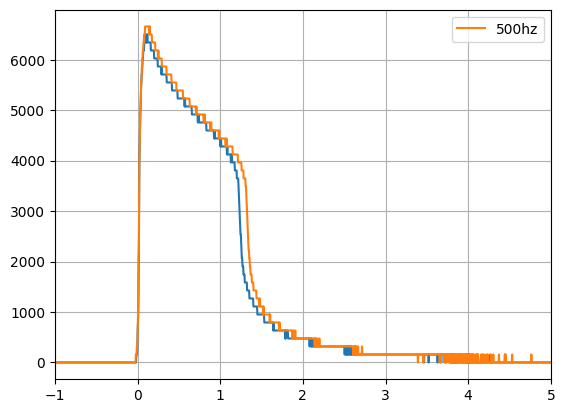

In [325]:
df = GetWaveForm(175)

plt.errorbar(x=df["Time"], y=df["Channel Trigger"])

df = GetWaveForm(180)
plt.errorbar(x=df["Time"], y=df["Channel Trigger"], label="500hz")

plt.legend()
plt.xlim(-1,5)
plt.grid()

In [47]:
analysis_list=[]

Run  330   BG-  335
0.0039999999999995595
bg anode norm fact 30.738403333333338
modifed diffsize  128
1.7182736999325705 [6124] [14.48959964]
[14.48959964]
Anode p0  [1.7182736999325705, 14.48959964, 0.6019999850000008]
200
cathode p0 [-56.09394750366996, 1.66560001, 0.008000000000000007]
[[ 1.68587054e-02 -3.64862429e-12  1.12070367e-04]
 [-3.64862429e-12  2.23500565e-06 -3.53093869e-14]
 [ 1.12070367e-04 -3.53093869e-14  2.23500567e-06]]

Run  331   BG-  336
0.0039999999999995595
bg anode norm fact 29.598009222222224
modifed diffsize  128
1.002654902395604 [6224] [14.8906663]
[14.8906663]
Anode p0  [1.002654902395604, 14.8906663, 0.5859999799999995]
200
cathode p0 [-45.13611416281475, 1.72266667, 1.5639999500000001]
[[ 1.03111830e-02 -3.06236145e-12  8.92560422e-05]
 [-3.06236145e-12  2.31786432e-06 -3.99483057e-14]
 [ 8.92560422e-05 -3.99483057e-14  2.31786435e-06]]

Run  332   BG-  337
0.0039999999999995595
bg anode norm fact 29.651677777777778
modifed diffsize  128
1.1835880345151

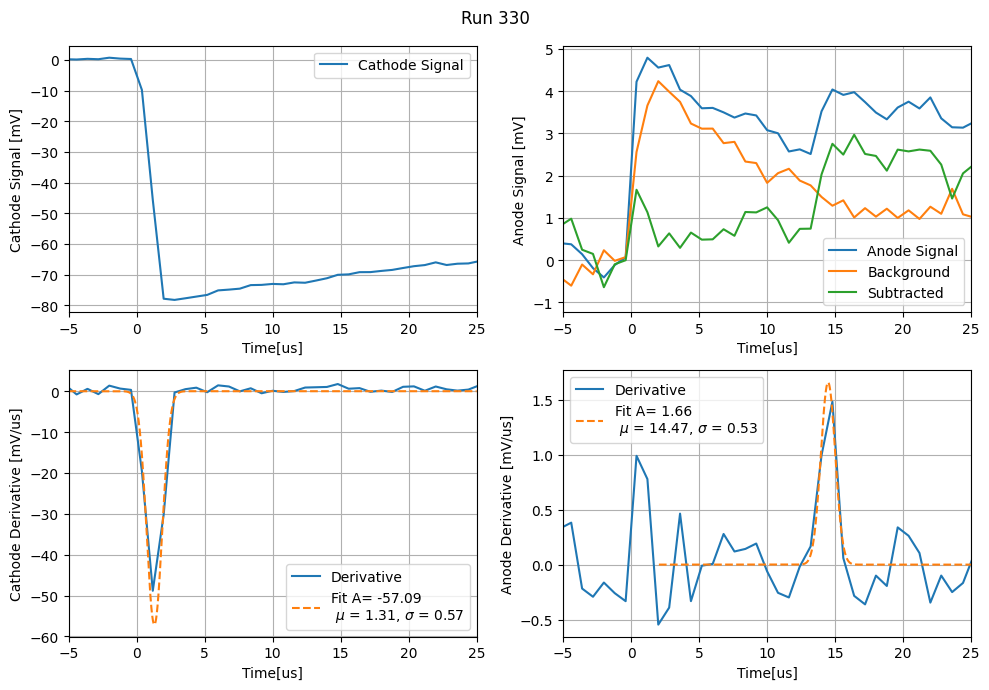

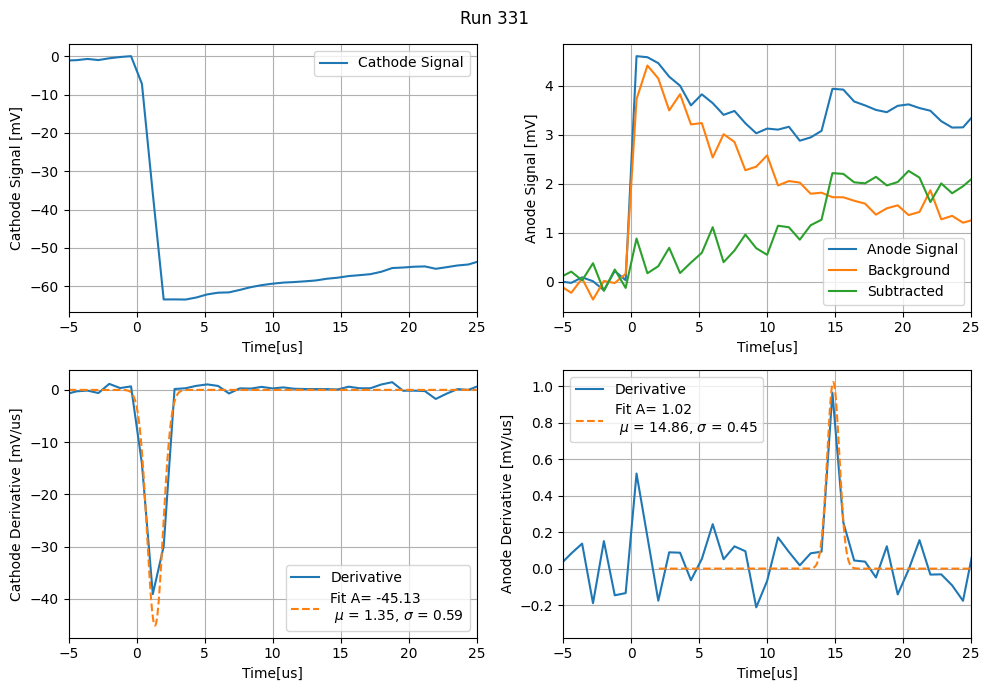

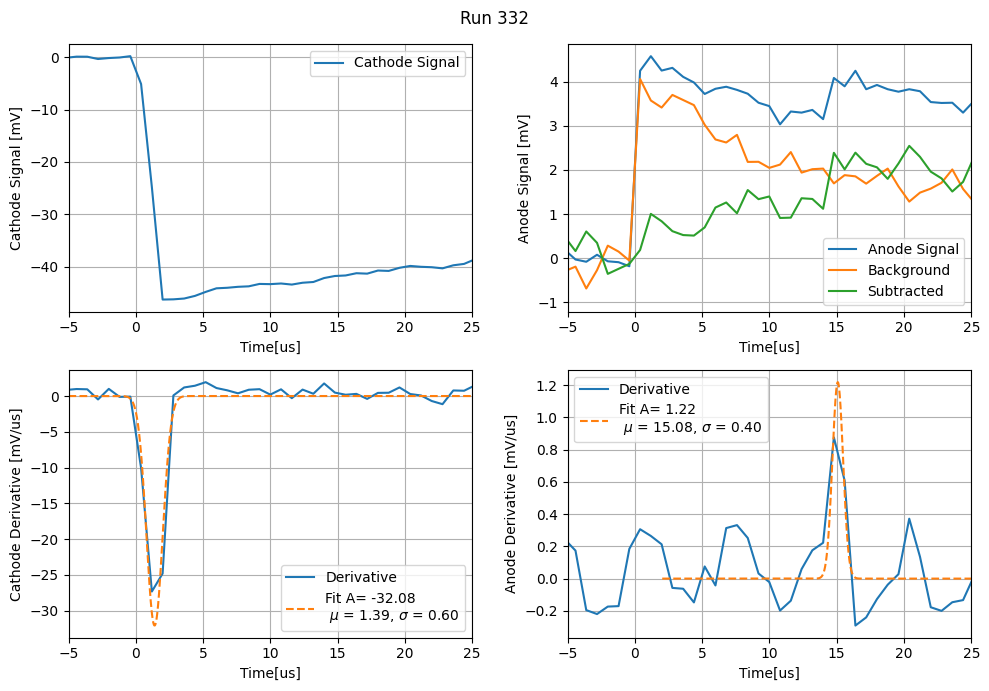

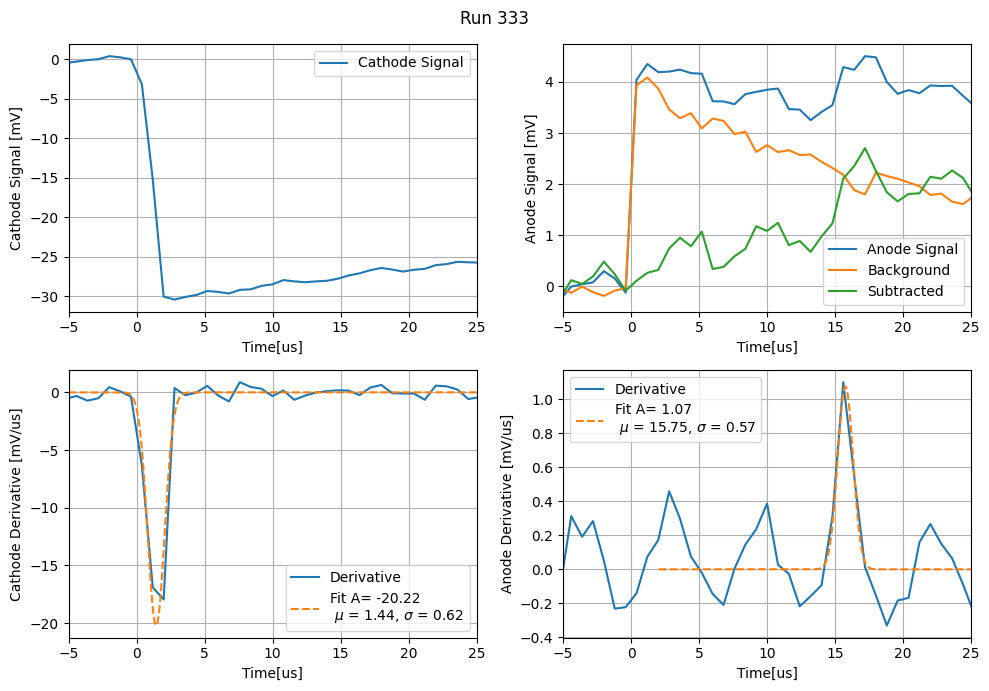

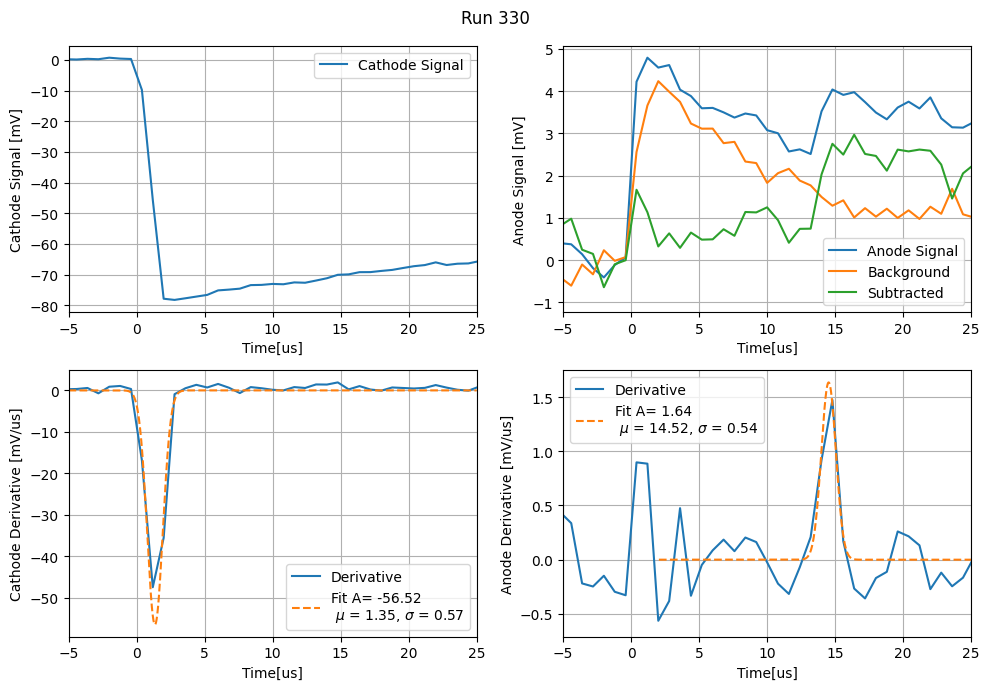

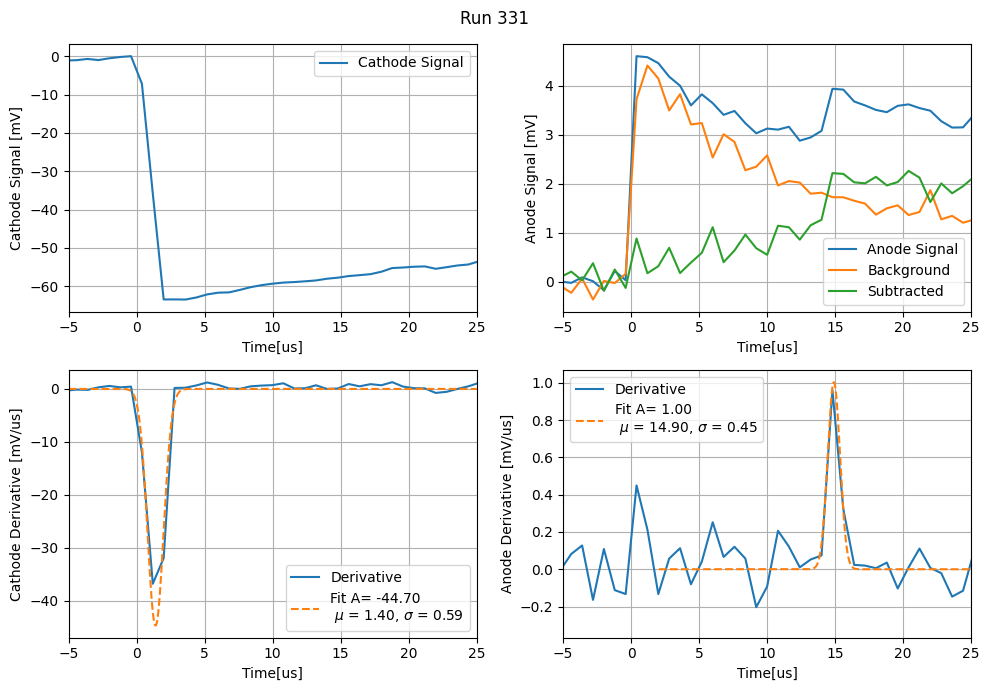

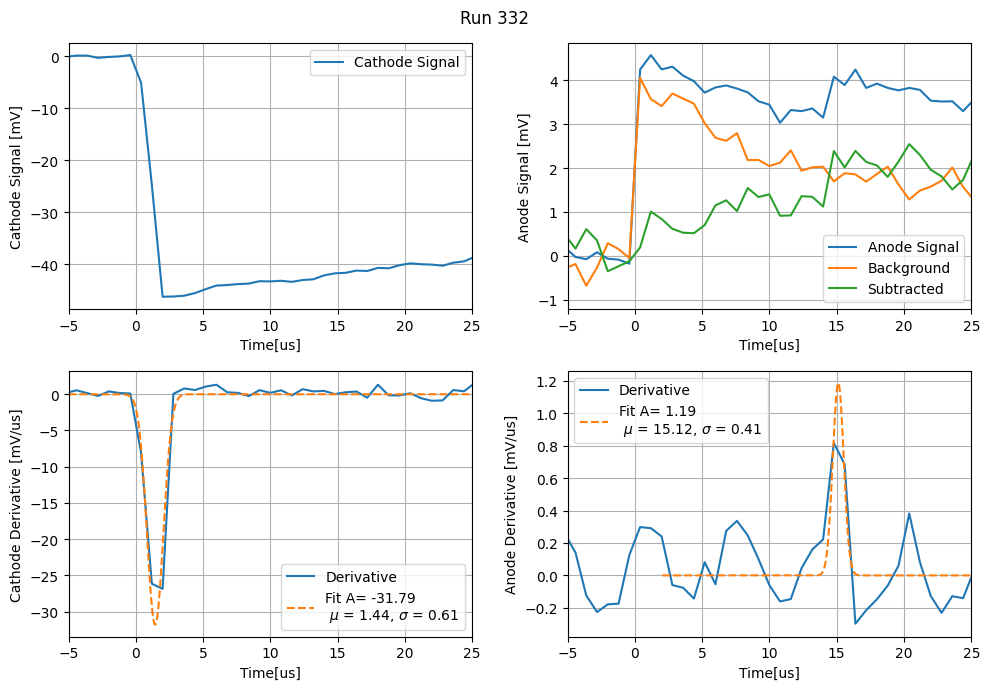

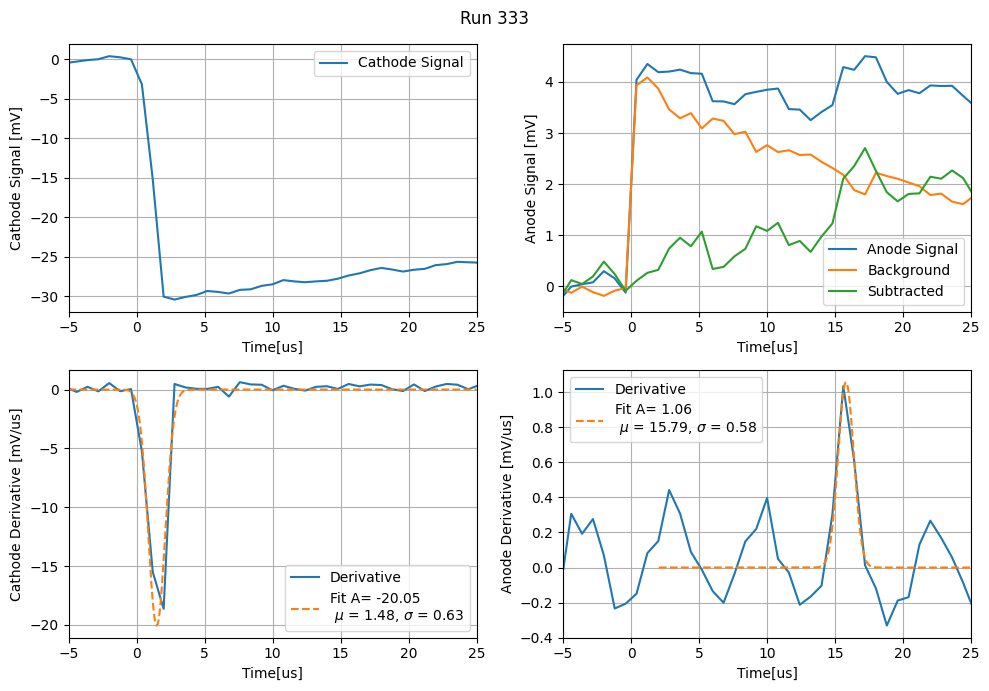

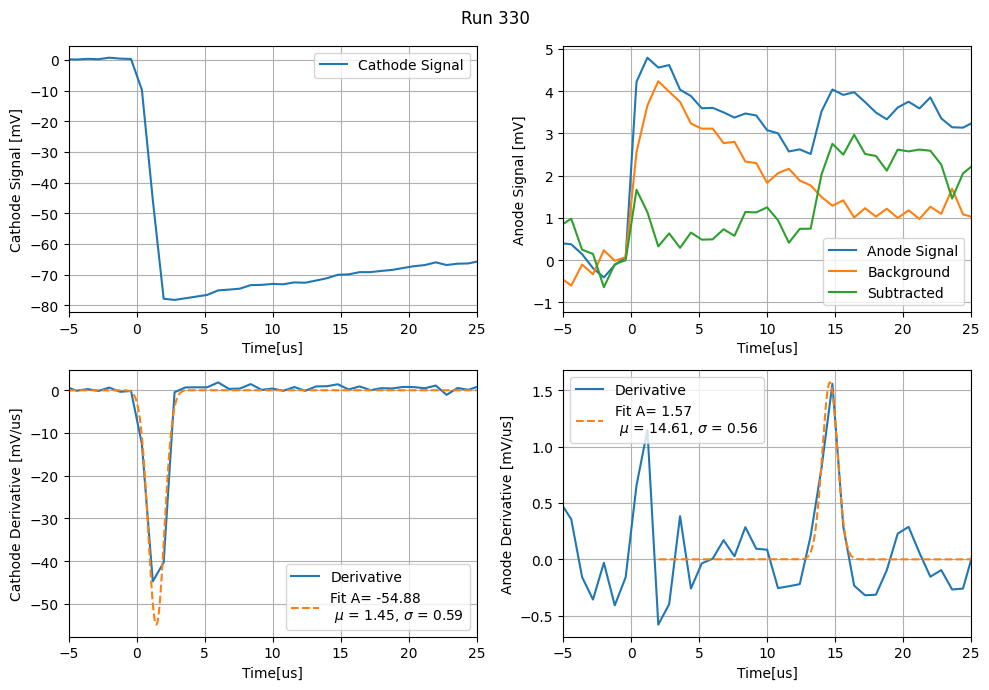

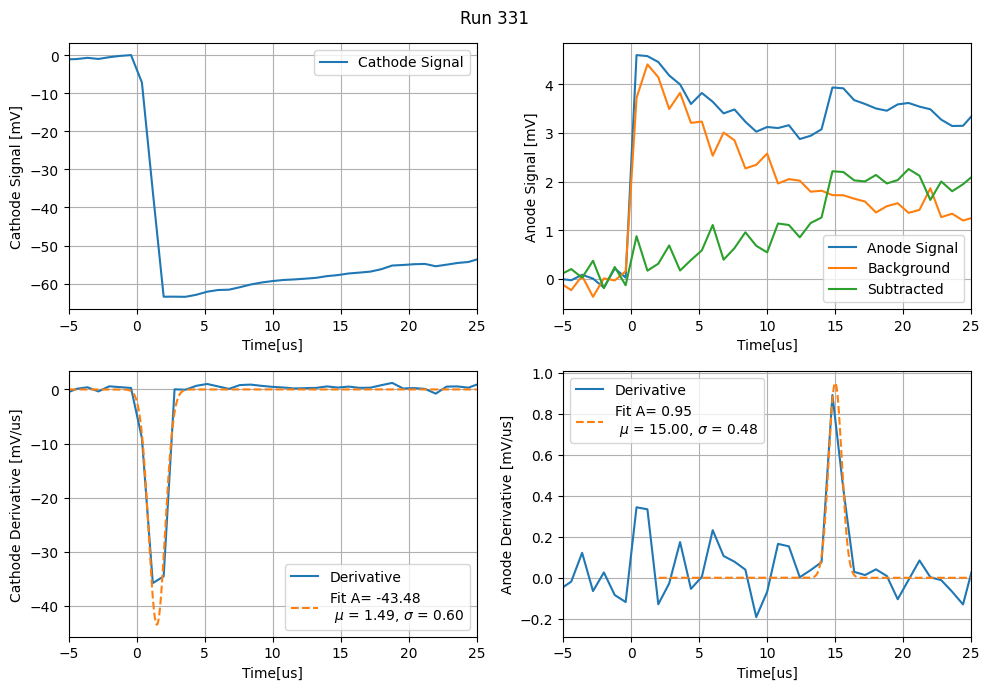

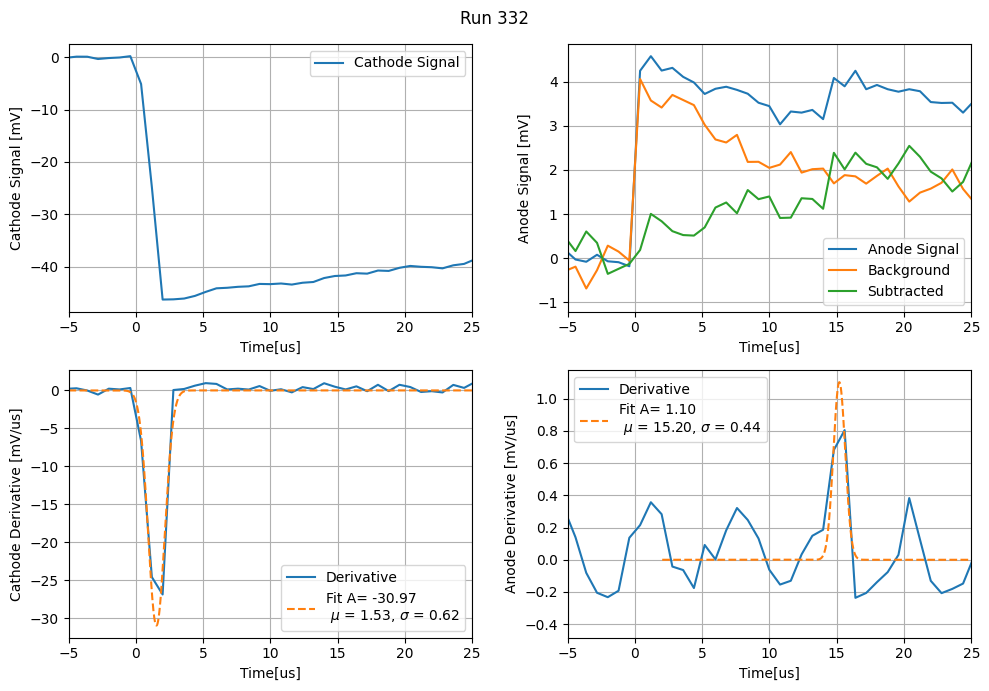

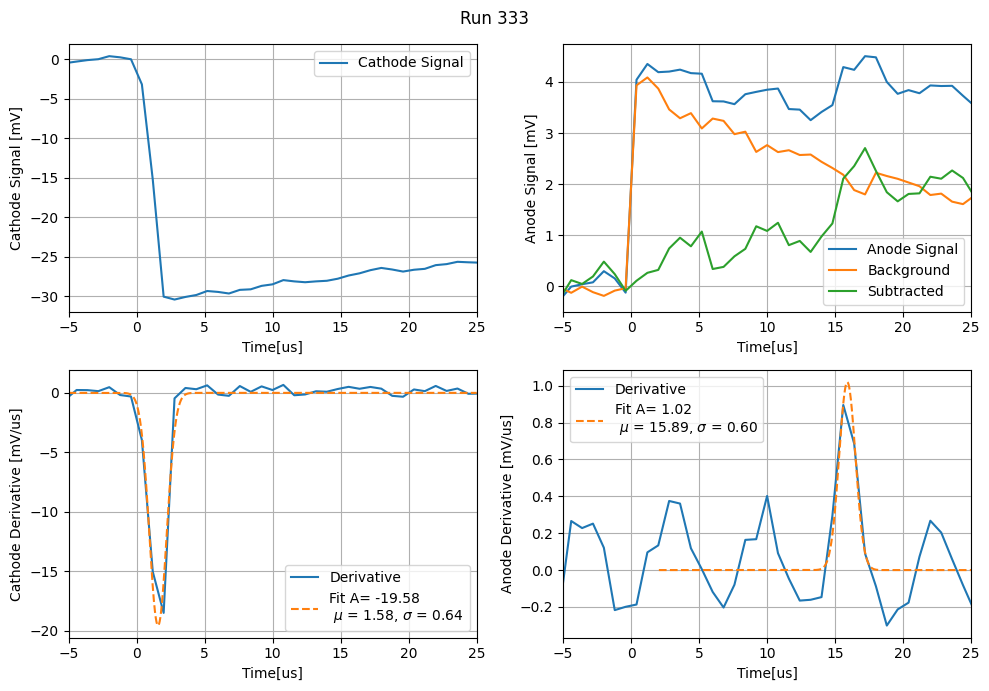

In [150]:
#oct 7th v1s
#runlist= [143     ,144  ,145, 146,]#147]
#bg_runs = [160,159,158,157]

#runlist=[199,200,201,202]
#bg_runs=[226,227,228,229]

#runlist=[175,180] # Comparison between  500 hz and 100 hz
#bg_runs=[207,212]

#runlist=[117] # Comparison between  500 hz and 100 hz
#bg_runs=[-1]


#runlist   =[143,144,145,146] #+list(map(int,run_to_back[0])) #
#bg_runs   =[160,159,158,157] #+ list(map(int,run_to_back[1])) #np.arange(209,213,1) # Lis tof back ground runs
#runlist=np.arange(177,181,1)  # List of runs
#bg_runs=np.arange(209,213,1) # Lis tof back ground run
runlist=[330,331,332,333]
bg_runs=[335,336,337,338]

stepcount=200
diffsizes =[128,150,200]


#Prepare figures


#fig_d_E, axs_d_E = plt.subplots(1, figsize=(8,5))
#fig_d_n, axs_d_n = plt.subplots(1, figsize=(8,5))



anode_delay=[]
cathode_delay=[]
drift_field_list=[]
k=0
for k,diffsize in enumerate(diffsizes):

    i=0
    for j,run in enumerate(runlist):
        analysis_dict={}
        print("Run " , run, "  BG- ", bg_runs[j])

        # Need to systematicly determine these
        chann_name_options=[["Avg UV","Avg Anode"],["Avg Cathode","Avg Anode"],['Average Cathode (2)', 'Average Anode (2)']]
        chann_names=["Avg UV","Avg Anode"]#["Avg Cathode","Avg Anode"]['Average Anode (2)', 'Average Cathode (2)]
        analysis_dict["Run"] = run
        # Grab the main and background waveforms
        try:
            DF=GetWaveForm(run)

        except:
            print("Issue with run " ,run)
            continue
        
        findnames=0
        m=0
        while findnames==0:
            if chann_name_options[m][0] in DF.keys():
                findnames=1
                chann_names=chann_name_options[m]
            else:         
                m=m+1


        try:
            if bg_runs[j] ==-1:
                n=len(DF["Time"])
                bgDF=pd.DataFrame({chann_names[0]: [0] *n , chann_names[1]: [0] * n})
            else:
                bgDF=GetWaveForm(bg_runs[j])
        except Exception as e:
            print(f"An error occurred: {e}")
            print("Issue with bg " , bg_runs[j])
            continue

        fig, ax = plt.subplots(2,2, figsize=(10,7))
        
        #,figsize=(7,4) )
        # fig_a, axs_a = plt.subplots(1, figsize=(7,4))
        # fig_a2, axs_a2 = plt.subplots(1, figsize=(7,4))
        # fig_c, axs_c = plt.subplots(1, figsize=(7,4))
        # fig_c2, axs_c2 = plt.subplots(1, figsize=(7,4))


        # if type(axs_a)!=type(np.array(0)):
        #     axs_a=[axs_a]
        #     axs_a2=[axs_a2]
        #     axs_c=[axs_c]
        #     axs_c2=[axs_c2]


        timeresolution = DF["Time"].iloc[1] - DF["Time"].iloc[0]
        print(timeresolution)
        RI = GetRunInfo(run)
        drift_field=RI["Drift Field"].iloc[0]
        bgRI = GetRunInfo(bg_runs[j])

        # Find the baseline normalization of each waveform
        mod_step=int((stepcount * 0.004/timeresolution))
        res_mod=0.004/timeresolution
        Zero_time = np.where(abs(DF["Time"] - 0) <= 10*timeresolution)[0][-1] #Time 0 +2


        anodenorm=np.average(DF[chann_names[1]][Zero_time-int(100*res_mod):Zero_time-int(10*res_mod)])
        cathnorm =np.average(DF[chann_names[0]][Zero_time-int(100*res_mod):Zero_time-int(10*res_mod)])
        bg_anorm =np.average(bgDF[chann_names[1]][Zero_time-int(100*res_mod):Zero_time-int(10*res_mod)])
        bg_cnorm =np.average(bgDF[chann_names[0]][Zero_time-int(100*res_mod):Zero_time-int(10*res_mod)])

        print("bg anode norm fact",bg_anorm)
        #Normalize signal and BG then subtract
        bg_y_factor=1

        anode_sig=DF[chann_names[1]] - anodenorm
        bg_a_sig =bgDF[chann_names[1]] - bg_anorm
        
        if np.max(bg_a_sig[:3000]) > np.max(anode_sig[:3000]):
            print("bg too big")
            bg_y_factor= np.max(anode_sig[:3000])/np.max(bg_a_sig[:3000])

        anode_sub= anode_sig-bg_a_sig[:len(anode_sig)]*bg_y_factor

        #take diff
        rolling= anode_sub.rolling(mod_step).mean()
        print("modifed diffsize ",int(diffsize*res_mod))
        anode_diff = rolling.diff(int((diffsize*res_mod)))/(DF["Time"].iloc[int((diffsize*res_mod))]-DF["Time"].iloc[0])


        ax[0][1].errorbar(x=DF["Time"][::mod_step],y=anode_sig[::mod_step],  label="Anode Signal")
        ax[0][1].errorbar(x=DF["Time"][::mod_step],y=bg_a_sig[::mod_step]*bg_y_factor,  label="Background")




        ax[0][1].errorbar(x=DF["Time"][::stepcount],y=anode_sub[::stepcount],  label="Subtracted")

        ax[1][1].errorbar(x=DF["Time"][::stepcount],y=anode_diff[::stepcount],  label="Derivative")

        #Fit the derivative with a guassian
        fit_start_index = np.where(abs(DF["Time"] - 0) <= 10*timeresolution)[0][-1] + int(2/timeresolution) #Time 0 +2
    
        #P0 for guassian fit
        diff_max=np.max(anode_diff[fit_start_index:]) #Amp value
        max_loc_ind = np.where(anode_diff == diff_max)[0] #index for max location
        max_time= np.array(DF["Time"])[max_loc_ind]    # time for the max location

        print(diff_max,max_loc_ind,max_time)
        half_max_ind=[]
        k=0
        #print(diff_max,max_time)
        while len(half_max_ind) <=1:
            half_max_ind= (np.where(abs(anode_diff[fit_start_index:] - diff_max/2.0) <= 0.01*(k+1)) + fit_start_index)[0] #indexes for simga guess
            k=k+1
            
            if k >=25:
                print("Cant find second half max for anode")
                break
        #print(half_max_ind)
        #print(DF["Time"].iloc[half_max_ind[-1]] , DF["Time"].iloc[half_max_ind[0]])
        try :
            half_max_sep = DF["Time"].iloc[half_max_ind[-1]] - DF["Time"].iloc[half_max_ind[0]]  # seperation between first and last index
        except : 
            half_max_sep = timeresolution*4
       # axs_a2[i].errorbar(x=DF["Time"].iloc[max_loc_ind],y=anode_diff.iloc[max_loc_ind],fmt=" ", marker="s", label="Amplitude & $\mu$")
       # axs_a2[i].errorbar(x=DF["Time"].iloc[half_max_ind],y=anode_diff.iloc[half_max_ind],fmt=" ", markersize=10,marker="s", label="$\sigma$")

        #anode Fitting data
        xfit = np.array(DF["Time"][fit_start_index:])
        yfit = np.array(anode_diff[fit_start_index:].fillna(0))
        #guess for anode fit
        print(max_time)
        p0 = [diff_max,max_time[0],half_max_sep/2]
        print("Anode p0 ", p0)
        analysis_dict["Anode P0"]=p0
        
        sigma=10
        Amp=diff_max
        A=0
        xfit_tmp=xfit
        yfit_tmp=yfit
        z=0
        while sigma >=1 or abs((A-Amp))/Amp >= 0.1:
            ppot, pcov = curve_fit(gaussian,xfit_tmp,yfit_tmp, p0=p0,maxfev = 2000)
            z=z+1
            sigma=ppot[2]
            A=ppot[0]
           # print(sigma, (A-Amp)/Amp)
           # print(pcov[0][0],pcov[i][i],pcov[2][2])

            if z >=10:
                break
            
            yfit_tmp = yfit[np.max([max_loc_ind[0]-(10-z)*500,0]):np.min([max_loc_ind[0]+(10-z)*500,len(yfit)])].copy()
            xfit_tmp = xfit[np.max([max_loc_ind[0]-(10-z)*500,0]):np.min([max_loc_ind[0]+(10-z)*500,len(xfit)])].copy()

        if ppot[0] <0:
            print("Bad fit skipping run ", run)
            continue
        
        analysis_dict["Anode Delay Time"] = ppot[1]
        analysis_dict["Anode Delay Sigma"] = ppot[2]
        analysis_dict["Anode Amp"] = ppot[0]
                

        guass_y = gaussian(xfit,ppot[0],ppot[1],ppot[2])
        ax[1][1].errorbar(x=xfit,y=guass_y,fmt="--",
                          label="Fit A= %0.2f \n $\mu$ = %0.2f, $\sigma$ = %0.2f"%(ppot[0],ppot[1],ppot[2]))



        print(mod_step)
        ax[0][0].errorbar(x=DF["Time"][::mod_step],
                          y=DF[chann_names[0]][::mod_step] - cathnorm,   label="Cathode Signal")

        #Normalize signal and BG then subtract
        cath_sig=DF[chann_names[0]] - cathnorm

        
        cath_diff = cath_sig.diff(int(diffsize*res_mod))/(DF["Time"].iloc[int(diffsize*res_mod)]-DF["Time"].iloc[0])
        
        ax[1][0].errorbar(x=DF["Time"][::mod_step],y=cath_diff[::mod_step],   label="Derivative")
        
        #Cathode Fitting data
        xfit = np.array(DF["Time"][:])
        yfit = np.array(cath_diff[:].fillna(0))
        #guess for cathode fit

        min_loc_ind = np.where(cath_diff == np.min(cath_diff)) #index for max locaiton
        min_time= np.array(DF["Time"])[min_loc_ind][0]

        k=0
        half_min_ind=[]
        #print(np.min(cath_diff),min_time)
        while len(half_min_ind) <=1:
            #print( np.min(cath_diff)/2.0 ,0.01*k)
            half_min_ind= (np.where(abs(cath_diff - np.min(cath_diff)/2.0) <= 0.2*k) )[0] #indexes for simga guess
            k=k+1
            #print(half_min_ind, k)
            if k >=45:
                print("Cant find second half max")
                break

        #half_min_ind= (np.where(abs(cath_diff - np.min(diff_max)/2.0) <= 0.05) )[0] #indexes for simga guess
        half_min_sep = DF["Time"].iloc[half_min_ind[-1]] - DF["Time"].iloc[half_min_ind[0]]  # seperation between first and last index
        #print("cathode half min ", half_min_ind)
        #axs_c[i].errorbar(x=DF["Time"].iloc[min_loc_ind],y=cath_diff.iloc[min_loc_ind],fmt=" ", marker="s", label="Amplitude & $\mu$")
        #axs_c[i].errorbar(x=DF["Time"].iloc[half_min_ind],y=cath_diff.iloc[half_min_ind],fmt=" ", markersize=10,marker="s", label="$\sigma$") 
        
        p0 = [np.min(yfit),min_time,half_min_sep]
        print("cathode p0", p0)
        analysis_dict["Cathode P0"]=p0
        analysis_dict["fit stepsize"]=stepcount
        analysis_dict["fit diffsize"]=diffsize
        #Fit cathode deriv
        ppot, pcov = curve_fit(gaussian,xfit,yfit, p0=p0)

        analysis_dict["Cathode Delay Time"] = ppot[1]
        analysis_dict["Cathode Delay Sigma"] = ppot[2]
        analysis_dict["Cathode Amp"] = ppot[0]

        guass_y = gaussian(xfit,ppot[0],ppot[1],ppot[2])
        ax[1][0].errorbar(x=xfit,y=guass_y,fmt="--",
                          label="Fit A= %0.2f \n $\mu$ = %0.2f, $\sigma$ = %0.2f"%(ppot[0],ppot[1],ppot[2]))

        
        print(pcov)



        ax[1][0].grid()
        ax[1][0].legend()
        ax[1][0].set_xlabel("Time[us]")
        ax[1][0].set_ylabel("Cathode Derivative [mV/us]")
        
        ax[1][0].set_xlim(-5,25)

        ax[1][1].grid()
        ax[1][1].legend()
        ax[1][1].set_xlabel("Time[us]")
        ax[1][1].set_ylabel("Anode Derivative [mV/us]")
        
        ax[1][1].set_xlim(-5,25)

        ax[0][0].grid()
        ax[0][0].legend()#loc="upper right")
        ax[0][0].set_xlabel("Time[us]")
        ax[0][0].set_ylabel("Cathode Signal [mV]")
        #ax[0][0].set_title("Run %i"%(run))
        
        ax[0][0].set_xlim(-5,25)
        ax[0][1].grid()
        ax[0][1].legend()#loc="upper right")
        ax[0][1].set_xlabel("Time[us]")
        ax[0][1].set_ylabel("Anode Signal [mV]")
        #ax[0][1].set_title("Run %i"%(run))
        
        ax[0][1].set_xlim(-5,25)
        
        fig.suptitle("Run %i"%(run))
        plt.tight_layout()
    
        drift_field = RI["Drift Field"].iloc[0]#RI["Cathode Grid V."].iloc[0]/(9.14/10)
        extract_field=RI["Extraction Field"].iloc[0]
        analysis_dict["Drift Field"] =drift_field
        analysis_dict["Extraction Field"] =extract_field
        analysis_dict["pressure"] = RI["Target Pressure"].iloc[0]
        analysis_dict["Temp"] = RI["RTD 2"].iloc[0]
        analysis_dict["Laser Current"] = float(RI["Laser Current"].iloc[0])
        analysis_dict["Laser Freq."] = float(RI["Laser Freq."].iloc[0])
        analysis_dict["Cathode V."] = float(RI["Cathode V."].iloc[0])
        analysis_dict["Drift Length"] = float(RI["Drift Length"].iloc[0])
        

        print("")


        # plot_dir="C:/Users/jasonbane/Desktop/nexo_code/Plots/"


        analysis_list.append(analysis_dict)
        # anode_1_fig_name= plot_dir + "Run_%i"%(run)+"-Anode.v1_stp%i"%(stepcount)+"-diff%i"%(diffsize)+".png"
        # anode_2_fig_name= plot_dir + "Run_%i"%(run)+"-Anode.v2_stp%i"%(stepcount)+"-diff%i"%(diffsize)+".png"
        # cath_1_fig_name= plot_dir + "Run_%i"%(run)+"-Cath_stp%i"%(stepcount)+"-diff%i"%(diffsize)+".png"
        # cath_2_fig_name= plot_dir + "Run_%i"%(run)+"-Cath.v2_stp%i"%(stepcount)+"-diff%i"%(diffsize)+".png"
        # fig_a.savefig(anode_1_fig_name,)

        # fig_a2.savefig(anode_2_fig_name)
        # fig_c.savefig(cath_1_fig_name)
        # fig_c2.savefig(cath_2_fig_name)






In [117]:
rungroup_1[:3]

Run                                           Anode P0  Anode Delay Time  \
22  330  [2.0857170695239047, 14.48959964, 0.0120000000...         14.489600   
27  330  [1.8535995695099832, 14.16559965, 0.5319999849...         14.324393   
41  330  [1.981314530520103, 14.39759965, 0.52599998500...         14.288446   

    Anode Delay Sigma  Anode Amp  \
22           0.012000   2.085717   
27           0.511293   1.719937   
41           0.482125   1.813122   

                                           Cathode P0  fit stepsize  \
22  [-55.217401840580095, 1.68560001, 1.4999999599...            50   
27       [-53.40470200267632, 1.70960001, 1.49999996]            50   
41  [-56.09394750366996, 1.66560001, 0.00800000000...           100   

    fit diffsize  Cathode Delay Time  Cathode Delay Sigma  ...  \
22           150            1.353213             0.573631  ...   
27           200            1.449489             0.587018  ...   
41           128            1.310659             0.569321  ...   

    Extraction Field  pressure   Temp  Laser Current  Laser Freq.  Cathode V.  \
22        698.360656      25.7  173.5           28.0        500.0      1597.8   
27        698.360656      25.7  173.5           28.0        500.0      1597.8   
41        698.360656      25.7  173.5           28.0        500.0      1597.8   

    Drift Length  Drift Vel  Drift Vel Avg  Drift Vel std  
22      20.90857   1.591653       1.609972       0.010376  
27      20.90857   1.623979       1.609972       0.010376  
41      20.90857   1.611104       1.609972       0.010376  

[3 rows x 22 columns]

In [122]:
rungroup_1.groupby("Run")["Drift Vel std"].mean(),

(Run
 330    0.010376
 331    0.005947
 332    0.005503
 333    0.013405
 Name: Drift Vel std, dtype: float64,)

In [109]:
Delay_ana =pd.DataFrame.from_dict(analysis_list).sort_values(by=['Run','fit stepsize','fit diffsize'])
Delay_ana=Delay_ana.drop_duplicates(subset=['Run','fit stepsize','fit diffsize'],keep='last')
Delay_ana=Delay_ana.query("`Anode Amp` >= 0")
Delay_ana[:3]


Run                                           Anode P0  Anode Delay Time  \
53  177  [7.574651858384849, 8.14799982, 0.387999989999...          8.164500   
57  177  [7.197908874918332, 8.26799982, 0.399999990000...          8.293052   
61  177  [6.9953948998465005, 8.30799982, 0.40999998999...          8.337150   

    Anode Delay Sigma  Anode Amp  \
53           0.300919   7.982545   
57           0.322633   7.377302   
61           0.334497   7.098997   

                                           Cathode P0  fit stepsize  \
53  [-58.2709397762087, 1.71200001, 0.039999999999...            50   
57        [-55.8790002296486, 1.66800001, 0.18399999]            50   
61  [-55.87903519596786, 1.62800001, 1.45599995000...            50   

    fit diffsize  Cathode Delay Time  Cathode Delay Sigma  Cathode Amp  \
53            64            1.228041             0.561930   -58.127931   
57           128            1.352602             0.569992   -56.974382   
61           150            1.395021             0.574257   -56.402973   

    Drift Field  Extraction Field  pressure   Temp  Laser Current  \
53   549.809472        551.912568      23.6  173.2           28.0   
57   549.809472        551.912568      23.6  173.2           28.0   
61   549.809472        551.912568      23.6  173.2           28.0   

    Laser Freq.  Cathode V.  Drift Length  
53        500.0       606.0         9.185  
57        500.0       606.0         9.185  
61        500.0       606.0         9.185

In [147]:

runs_ext =[330,331,332,333]
#runs_ext  =np.arange(177,181,1)#
searchstr=""
for run in runs_ext:
    searchstr= searchstr+" %i,"%(run)
print(searchstr)

rungroup= Delay_ana.query("Run in [%s]"%(searchstr))



#rungroup["Drift Distance"] = 9.18
#+np.abs(rungroup["Cathode Delay Sigma"])
rungroup.loc[:,"Drift Vel"] = rungroup["Drift Length"]/(rungroup["Anode Delay Time"] -(rungroup["Cathode Delay Time"]))


rungroup["V_2"]=rungroup.apply(lambda row: row["Drift Length"]/ (row["Anode P0"][1]-row["Cathode P0"][1]) ,axis=1)
    


for run in runs_ext:
    rungroup.loc[rungroup.query("Run == %s"%(run)).index,"Drift Vel Avg"]=np.average(rungroup.query("Run == %s"%(run))["Drift Vel"])
    rungroup.loc[rungroup.query("Run == %s"%(run)).index,"Drift Vel std"]=np.std(rungroup.query("Run == %s"%(run))["Drift Vel"])
    rungroup.loc[rungroup.query("Run == %s"%(run)).index,"V_2 Avg"]=np.average(rungroup.query("Run == %s"%(run))["V_2"])


rungroup_1=rungroup


 330, 331, 332, 333,


C:\Users\jasonbane\AppData\Local\Temp\ipykernel_14864\322254517.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rungroup.loc[:,"Drift Vel"] = rungroup["Drift Length"]/(rungroup["Anode Delay Time"] -(rungroup["Cathode Delay Time"]))
C:\Users\jasonbane\AppData\Local\Temp\ipykernel_14864\322254517.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rungroup["V_2"]=rungroup.apply(lambda row: row["Drift Length"]/ (row["Anode P0"][1]-row["Cathode P0"][1]) ,axis=1)
C:\Users\jasonbane\AppData\Local\Temp\ipyke

In [149]:
rungroup_1[:2]

Run                                           Anode P0  Anode Delay Time  \
22  330  [2.0857170695239047, 14.48959964, 0.0120000000...         14.489600   
27  330  [1.8535995695099832, 14.16559965, 0.5319999849...         14.324393   

    Anode Delay Sigma  Anode Amp  \
22           0.012000   2.085717   
27           0.511293   1.719937   

                                           Cathode P0  fit stepsize  \
22  [-55.217401840580095, 1.68560001, 1.4999999599...            50   
27       [-53.40470200267632, 1.70960001, 1.49999996]            50   

    fit diffsize  Cathode Delay Time  Cathode Delay Sigma  ...   Temp  \
22           150            1.353213             0.573631  ...  173.5   
27           200            1.449489             0.587018  ...  173.5   

    Laser Current  Laser Freq.  Cathode V.  Drift Length  Drift Vel       V_2  \
22           28.0        500.0      1597.8      20.90857   1.591653  1.632972   
27           28.0        500.0      1597.8      20.90857   1.623979  1.678594   

    Drift Vel Avg  Drift Vel std   V_2 Avg  
22       1.609972       0.010376  1.650957  
27       1.609972       0.010376  1.650957  

[2 rows x 24 columns]

### 20241101 drift field sweep

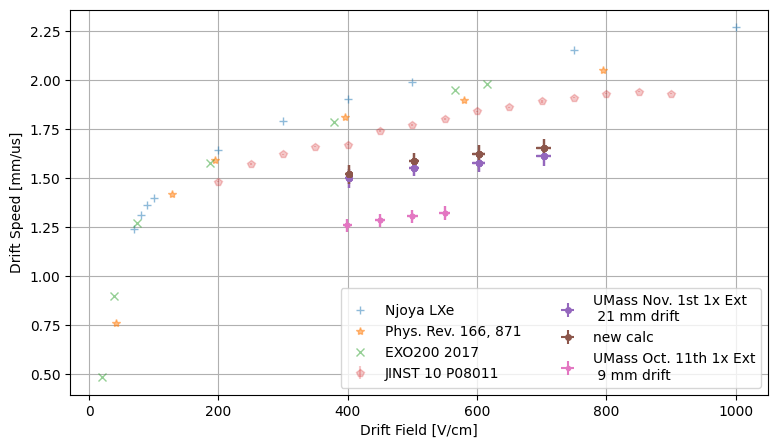

In [148]:
fig,ax= plt.subplots(1, 1, figsize=(9,5))


#print(bx)
colors=["r","blue","darkgrey","green","cyan","purple"]
marker=["o","x","p","s","h","*"]
markersize=7

sec=0





ax.errorbar(x=njoya_x,y=njoya_y,fmt=" ",marker="+",alpha=0.5,label="Njoya LXe")

ax.errorbar(x=ChT_Vs,y=ChT_dv,fmt=" ", marker="*",alpha=0.5,label="Phys. Rev. 166, 871 ")

ax.errorbar(x=EXO200[0],y=EXO200[1],fmt=" ", marker="x",alpha=0.5,label="EXO200 2017")


ax.errorbar(x= JINST_2015_dict["Voltage"],y=JINST_2015_dict["DriftSpeed"],fmt=" ",marker="p",
            yerr=JINST_2015_dict["Error"],alpha=0.25,label="JINST 10 P08011 ")
# ax.errorbar(x=1, y=1, fmt=" ", marker=".", markersize=0.001,label=" ")
# ax.errorbar(x=1, y=1, fmt=" ", marker=".", markersize=0.001,label=" ")



ax.errorbar( x = rungroup_1["Drift Field"] , y=rungroup_1["Drift Vel Avg"],
            xerr= np.sqrt((0.001)**2 + (0.15/9.185)**2)*rungroup_1["Drift Field"],
            yerr= np.sqrt((rungroup_1["Drift Vel std"]*2/rungroup_1["Drift Vel Avg"])**2 + (0.25/9.185)**2)*rungroup_1["Drift Vel Avg"],
             fmt =" ",marker="o",markersize=4, label="UMass Nov. 1st 1x Ext\n 21 mm drift")


ax.errorbar( x = rungroup_1["Drift Field"] , y=rungroup_1["V_2 Avg"],
            xerr= np.sqrt((0.001)**2 + (0.15/9.185)**2)*rungroup_1["Drift Field"],
            yerr= np.sqrt((rungroup_1["Drift Vel std"]*2/rungroup_1["Drift Vel Avg"])**2 + (0.25/9.185)**2)*rungroup_1["Drift Vel Avg"],
             fmt =" ",marker="o",markersize=4, label="new calc")


DF=rungroup_2

ax.errorbar( x = DF["Drift Field"] , y=DF["Drift Vel Avg"],
            xerr= np.sqrt((0.001)**2 + (0.15/9.185)**2)*DF["Drift Field"],
            yerr= np.sqrt((DF["Drift Vel std"]*2/DF["Drift Vel Avg"])**2 + (0.25/9.185)**2)*DF["Drift Vel Avg"],
             fmt =" ",marker=".", label="UMass Oct. 11th 1x Ext\n 9 mm drift")




ax.set_ylabel("Drift Speed [mm/us]")
ax.set_xlabel("Drift Field [V/cm]")

#ax.text(400,1.25, "UMass 2024",size=25,alpha=0.25)

#ax.set_ylim(1.2,1.91)
ax.grid()
ax.legend(ncol=2)#,loc="upper left")

In [145]:
DF=rungroup_1

DF.apply(lambda row: row["Drift Length"]/ (row["Anode P0"][1]-row["Cathode P0"][1]) ,axis=1)

#rungroup_1["Drift Length"]/(rungroup_1["Anode P0"][1]-rungroup_1["Cathode P0"].iloc[0][1])

22    1.632972
27    1.678594
41    1.642206
45    1.648421
49    1.652590
18    1.662049
23    1.621322
28    1.596562
42    1.629409
46    1.626367
50    1.596562
19    1.611326
24    1.602926
29    1.559875
43    1.595587
47    1.581108
51    1.559875
20    1.524837
25    1.531988
30    1.523504
44    1.511609
48    1.513359
52    1.507250
dtype: float64

In [143]:
DF[:3]

Run                                           Anode P0  Anode Delay Time  \
22  330  [2.0857170695239047, 14.48959964, 0.0120000000...         14.489600   
27  330  [1.8535995695099832, 14.16559965, 0.5319999849...         14.324393   
41  330  [1.981314530520103, 14.39759965, 0.52599998500...         14.288446   

    Anode Delay Sigma  Anode Amp  \
22           0.012000   2.085717   
27           0.511293   1.719937   
41           0.482125   1.813122   

                                           Cathode P0  fit stepsize  \
22  [-55.217401840580095, 1.68560001, 1.4999999599...            50   
27       [-53.40470200267632, 1.70960001, 1.49999996]            50   
41  [-56.09394750366996, 1.66560001, 0.00800000000...           100   

    fit diffsize  Cathode Delay Time  Cathode Delay Sigma  ...  \
22           150            1.353213             0.573631  ...   
27           200            1.449489             0.587018  ...   
41           128            1.310659             0.569321  ...   

    Extraction Field  pressure   Temp  Laser Current  Laser Freq.  Cathode V.  \
22        698.360656      25.7  173.5           28.0        500.0      1597.8   
27        698.360656      25.7  173.5           28.0        500.0      1597.8   
41        698.360656      25.7  173.5           28.0        500.0      1597.8   

    Drift Length  Drift Vel  Drift Vel Avg  Drift Vel std  
22      20.90857   1.591653       1.609972       0.010376  
27      20.90857   1.623979       1.609972       0.010376  
41      20.90857   1.611104       1.609972       0.010376  

[3 rows x 22 columns]